# Burgers equation

This code is modified from the code https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics

The paper about this work can ref https://www.researchgate.net/publication/359480166_Discontinuity_Computing_with_Physics-Informed_Neural_Network

In [127]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
torch.manual_seed(124)
np.random.seed(124)

In [128]:
def train(epoch):
    model.train()
    model.it = epoch
    def closure():
        optimizer.zero_grad()                                              
        loss_pde = model.loss_pde(x_int)                                   
        loss_ic = model.loss_ic(x_ic, u_ic)  
        loss = loss_pde + 10*loss_ic                                       

        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}')
        model.it = model.it + 1
        outputfile = open('loss_history_burgers.dat','a+')
        print(f'{model.it}  {loss_pde:.6f}  {loss_ic:.6f}  {loss:.6f}',file=outputfile)
        outputfile.close() 
        loss.backward()
        return loss

    loss = optimizer.step(closure)
    loss_value = loss.item() if not isinstance(loss, float) else loss
    print(f'epoch {epoch}: loss {loss_value:.6f}')
    
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

def IC(x):
    N = len(x)
    u_init = np.zeros((x.shape[0]))                                                
    for i in range(N):
        u_init[i] = -np.sin(np.pi*(x[i,1]-1))
    return u_init

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))                     
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              

        for num in range(2, 5):                                                     
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 
        self.net.add_module('Linear_layer_final', nn.Linear(30, 1))                 

    def forward(self, x):
        return self.net(x)

    def loss_pde(self, x):
        y = self.net(x)                                                
        u = y[:, 0:1]
        
        U = u**2/2

        dU_g = gradients(U, x)[0]                                  
        U_x = dU_g[:, 1:]
        du_g = gradients(u, x)[0]                                 
        u_t,u_x = du_g[:, :1],du_g[:,1:]
        d = 0.1*(abs(u_x)-u_x) + 1
      #  d = 1
        f = (((u_t + U_x)/d)**2).mean() 
         
        return f
    def res_pde(self,x):
        y = self.net(x)
        Res = np.zeros((x.shape[0]))                                  
        
        u = y[:, 0:1]
        U = u**2/2
        dU_g = gradients(U, x)[0]                                 
        U_x = dU_g[:, 1:]
        du_g = gradients(u, x)[0]                                  
        u_t,u_x = du_g[:, :1],du_g[:,1:]
        Res = (u_t + U_x)**2 
        return Res 
    
    def lambda_pde(self,x):
        y = self.net(x)
        Res = np.zeros((x.shape[0]))                                  
        
        u = y[:, 0:1]
        du_g = gradients(u, x)[0]                                  
        u_t,u_x = du_g[:, :1],du_g[:,1:]
        d = 0.1*(abs(u_x)-u_x) + 1
        return  d
        

    def loss_ic(self, x_ic, u_ic):
        y_ic = self.net(x_ic)                                                      
        u_ic_nn = y_ic[:, 0]
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean()
        return loss_ics

In [129]:

device = torch.device('cuda')                                      
num_x = 100                                                        
num_t = 100                                                        
num_i_train = 100                                           
num_f_train = 10000                                            
x = np.linspace(0, 2, num_x)                                   
t = np.linspace(0, 1, num_t)                                   
t_grid, x_grid = np.meshgrid(t, x)                             
T = t_grid.flatten()[:, None]                                  
X = x_grid.flatten()[:, None]                                  

id_ic = np.random.choice(num_x, num_i_train, replace=False)    
id_f = np.random.choice(num_x*num_t, num_f_train, replace=False)

x_ic = x_grid[id_ic, 0][:, None]                               
t_ic = t_grid[id_ic, 0][:, None]                               
x_ic_train = np.hstack((t_ic, x_ic))                               
u_ic_train = IC(x_ic_train)                 

x_int = X[:, 0][id_f, None]                                        
t_int = T[:, 0][id_f, None]                                        
x_int_train = np.hstack((t_int, x_int))                            

x_ic = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
u_ic = torch.tensor(u_ic_train, dtype=torch.float32).to(device)

model = DNN().to(device)

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print('Start training...')

Start training...


In [130]:
epochs = 15000
tic = time.time()
for epoch in range(1, epochs+1):
    train(epoch)
    
toc = time.time()

epoch 1 loss_pde:0.00246717, loss_ic:0.60424066
epoch 1: loss 6.044874
epoch 2 loss_pde:0.00189522, loss_ic:0.57413322
epoch 2: loss 5.743227
epoch 3 loss_pde:0.00150410, loss_ic:0.54862404
epoch 3: loss 5.487744
epoch 4 loss_pde:0.00124494, loss_ic:0.52708662
epoch 4: loss 5.272111
epoch 5 loss_pde:0.00109077, loss_ic:0.50895387
epoch 5: loss 5.090630
epoch 6 loss_pde:0.00101769, loss_ic:0.49369460
epoch 6: loss 4.937963
epoch 7 loss_pde:0.00101272, loss_ic:0.48082033
epoch 7: loss 4.809216
epoch 8 loss_pde:0.00106850, loss_ic:0.46988609
epoch 8: loss 4.699930
epoch 9 loss_pde:0.00118435, loss_ic:0.46048328
epoch 9: loss 4.606017
epoch 10 loss_pde:0.00136381, loss_ic:0.45223513
epoch 10: loss 4.523715
epoch 11 loss_pde:0.00161240, loss_ic:0.44479454
epoch 11: loss 4.449558
epoch 12 loss_pde:0.00193583, loss_ic:0.43784225
epoch 12: loss 4.380359
epoch 13 loss_pde:0.00233882, loss_ic:0.43108511
epoch 13: loss 4.313190
epoch 14 loss_pde:0.00282433, loss_ic:0.42425835
epoch 14: loss 4.245

epoch 116: loss 1.770777
epoch 117 loss_pde:0.11713828, loss_ic:0.16471641
epoch 117: loss 1.764302
epoch 118 loss_pde:0.11626286, loss_ic:0.16413628
epoch 118: loss 1.757626
epoch 119 loss_pde:0.11533386, loss_ic:0.16354069
epoch 119: loss 1.750741
epoch 120 loss_pde:0.11436453, loss_ic:0.16292770
epoch 120: loss 1.743641
epoch 121 loss_pde:0.11336692, loss_ic:0.16229542
epoch 121: loss 1.736321
epoch 122 loss_pde:0.11235224, loss_ic:0.16164179
epoch 122: loss 1.728770
epoch 123 loss_pde:0.11133119, loss_ic:0.16096462
epoch 123: loss 1.720977
epoch 124 loss_pde:0.11031384, loss_ic:0.16026182
epoch 124: loss 1.712932
epoch 125 loss_pde:0.10930942, loss_ic:0.15953115
epoch 125: loss 1.704621
epoch 126 loss_pde:0.10832561, loss_ic:0.15877067
epoch 126: loss 1.696032
epoch 127 loss_pde:0.10736792, loss_ic:0.15797849
epoch 127: loss 1.687153
epoch 128 loss_pde:0.10643906, loss_ic:0.15715306
epoch 128: loss 1.677970
epoch 129 loss_pde:0.10553863, loss_ic:0.15629312
epoch 129: loss 1.668470


epoch 248: loss 0.589957
epoch 249 loss_pde:0.16396289, loss_ic:0.04249890
epoch 249: loss 0.588952
epoch 250 loss_pde:0.16402209, loss_ic:0.04239235
epoch 250: loss 0.587946
epoch 251 loss_pde:0.16408886, loss_ic:0.04228484
epoch 251: loss 0.586937
epoch 252 loss_pde:0.16416401, loss_ic:0.04217622
epoch 252: loss 0.585926
epoch 253 loss_pde:0.16424823, loss_ic:0.04206636
epoch 253: loss 0.584912
epoch 254 loss_pde:0.16434216, loss_ic:0.04195514
epoch 254: loss 0.583894
epoch 255 loss_pde:0.16444643, loss_ic:0.04184242
epoch 255: loss 0.582871
epoch 256 loss_pde:0.16456164, loss_ic:0.04172809
epoch 256: loss 0.581842
epoch 257 loss_pde:0.16468826, loss_ic:0.04161200
epoch 257: loss 0.580808
epoch 258 loss_pde:0.16482668, loss_ic:0.04149408
epoch 258: loss 0.579768
epoch 259 loss_pde:0.16497712, loss_ic:0.04137422
epoch 259: loss 0.578719
epoch 260 loss_pde:0.16513960, loss_ic:0.04125235
epoch 260: loss 0.577663
epoch 261 loss_pde:0.16531399, loss_ic:0.04112842
epoch 261: loss 0.576598


epoch 376: loss 0.297876
epoch 377 loss_pde:0.16708614, loss_ic:0.01291112
epoch 377: loss 0.296197
epoch 378 loss_pde:0.16666491, loss_ic:0.01278832
epoch 378: loss 0.294548
epoch 379 loss_pde:0.16627403, loss_ic:0.01266520
epoch 379: loss 0.292926
epoch 380 loss_pde:0.16591907, loss_ic:0.01254094
epoch 380: loss 0.291328
epoch 381 loss_pde:0.16560440, loss_ic:0.01241484
epoch 381: loss 0.289753
epoch 382 loss_pde:0.16533358, loss_ic:0.01228628
epoch 382: loss 0.288196
epoch 383 loss_pde:0.16510986, loss_ic:0.01215474
epoch 383: loss 0.286657
epoch 384 loss_pde:0.16493584, loss_ic:0.01201981
epoch 384: loss 0.285134
epoch 385 loss_pde:0.16481324, loss_ic:0.01188119
epoch 385: loss 0.283625
epoch 386 loss_pde:0.16474265, loss_ic:0.01173878
epoch 386: loss 0.282130
epoch 387 loss_pde:0.16472326, loss_ic:0.01159264
epoch 387: loss 0.280650
epoch 388 loss_pde:0.16475323, loss_ic:0.01144298
epoch 388: loss 0.279183
epoch 389 loss_pde:0.16483009, loss_ic:0.01129012
epoch 389: loss 0.277731


epoch 505: loss 0.203998
epoch 506 loss_pde:0.16566779, loss_ic:0.00380970
epoch 506: loss 0.203765
epoch 507 loss_pde:0.16556093, loss_ic:0.00379720
epoch 507: loss 0.203533
epoch 508 loss_pde:0.16545308, loss_ic:0.00378493
epoch 508: loss 0.203302
epoch 509 loss_pde:0.16534735, loss_ic:0.00377257
epoch 509: loss 0.203073
epoch 510 loss_pde:0.16524477, loss_ic:0.00376001
epoch 510: loss 0.202845
epoch 511 loss_pde:0.16514224, loss_ic:0.00374757
epoch 511: loss 0.202618
epoch 512 loss_pde:0.16503735, loss_ic:0.00373549
epoch 512: loss 0.202392
epoch 513 loss_pde:0.16493012, loss_ic:0.00372375
epoch 513: loss 0.202168
epoch 514 loss_pde:0.16482231, loss_ic:0.00371217
epoch 514: loss 0.201944
epoch 515 loss_pde:0.16471510, loss_ic:0.00370064
epoch 515: loss 0.201722
epoch 516 loss_pde:0.16460857, loss_ic:0.00368914
epoch 516: loss 0.201500
epoch 517 loss_pde:0.16450231, loss_ic:0.00367771
epoch 517: loss 0.201279
epoch 518 loss_pde:0.16439496, loss_ic:0.00366648
epoch 518: loss 0.201060


epoch 636 loss_pde:0.15151694, loss_ic:0.00264606
epoch 636: loss 0.177978
epoch 637 loss_pde:0.15140586, loss_ic:0.00263871
epoch 637: loss 0.177793
epoch 638 loss_pde:0.15129557, loss_ic:0.00263129
epoch 638: loss 0.177608
epoch 639 loss_pde:0.15118475, loss_ic:0.00262392
epoch 639: loss 0.177424
epoch 640 loss_pde:0.15107299, loss_ic:0.00261666
epoch 640: loss 0.177240
epoch 641 loss_pde:0.15095986, loss_ic:0.00260954
epoch 641: loss 0.177055
epoch 642 loss_pde:0.15084606, loss_ic:0.00260250
epoch 642: loss 0.176871
epoch 643 loss_pde:0.15073267, loss_ic:0.00259543
epoch 643: loss 0.176687
epoch 644 loss_pde:0.15062025, loss_ic:0.00258827
epoch 644: loss 0.176503
epoch 645 loss_pde:0.15050800, loss_ic:0.00258109
epoch 645: loss 0.176319
epoch 646 loss_pde:0.15039475, loss_ic:0.00257402
epoch 646: loss 0.176135
epoch 647 loss_pde:0.15028022, loss_ic:0.00256709
epoch 647: loss 0.175951
epoch 648 loss_pde:0.15016489, loss_ic:0.00256024
epoch 648: loss 0.175767
epoch 649 loss_pde:0.1500

epoch 763: loss 0.155341
epoch 764 loss_pde:0.13687322, loss_ic:0.00183029
epoch 764: loss 0.155176
epoch 765 loss_pde:0.13676293, loss_ic:0.00182482
epoch 765: loss 0.155011
epoch 766 loss_pde:0.13665107, loss_ic:0.00181954
epoch 766: loss 0.154847
epoch 767 loss_pde:0.13653870, loss_ic:0.00181436
epoch 767: loss 0.154682
epoch 768 loss_pde:0.13642736, loss_ic:0.00180912
epoch 768: loss 0.154519
epoch 769 loss_pde:0.13631681, loss_ic:0.00180383
epoch 769: loss 0.154355
epoch 770 loss_pde:0.13620661, loss_ic:0.00179855
epoch 770: loss 0.154192
epoch 771 loss_pde:0.13609692, loss_ic:0.00179326
epoch 771: loss 0.154030
epoch 772 loss_pde:0.13598637, loss_ic:0.00178809
epoch 772: loss 0.153867
epoch 773 loss_pde:0.13587427, loss_ic:0.00178313
epoch 773: loss 0.153706
epoch 774 loss_pde:0.13576245, loss_ic:0.00177817
epoch 774: loss 0.153544
epoch 775 loss_pde:0.13565294, loss_ic:0.00177303
epoch 775: loss 0.153383
epoch 776 loss_pde:0.13554540, loss_ic:0.00176773
epoch 776: loss 0.153223


epoch 891: loss 0.137975
epoch 892 loss_pde:0.12456511, loss_ic:0.00133043
epoch 892: loss 0.137869
epoch 893 loss_pde:0.12448408, loss_ic:0.00132804
epoch 893: loss 0.137765
epoch 894 loss_pde:0.12440541, loss_ic:0.00132546
epoch 894: loss 0.137660
epoch 895 loss_pde:0.12432889, loss_ic:0.00132270
epoch 895: loss 0.137556
epoch 896 loss_pde:0.12425157, loss_ic:0.00132007
epoch 896: loss 0.137452
epoch 897 loss_pde:0.12417258, loss_ic:0.00131764
epoch 897: loss 0.137349
epoch 898 loss_pde:0.12409353, loss_ic:0.00131526
epoch 898: loss 0.137246
epoch 899 loss_pde:0.12401415, loss_ic:0.00131295
epoch 899: loss 0.137144
epoch 900 loss_pde:0.12393510, loss_ic:0.00131065
epoch 900: loss 0.137042
epoch 901 loss_pde:0.12385927, loss_ic:0.00130807
epoch 901: loss 0.136940
epoch 902 loss_pde:0.12378503, loss_ic:0.00130537
epoch 902: loss 0.136839
epoch 903 loss_pde:0.12370852, loss_ic:0.00130294
epoch 903: loss 0.136738
epoch 904 loss_pde:0.12362973, loss_ic:0.00130078
epoch 904: loss 0.136638


epoch 1021: loss 0.127192
epoch 1022 loss_pde:0.11616489, loss_ic:0.00109619
epoch 1022: loss 0.127127
epoch 1023 loss_pde:0.11611348, loss_ic:0.00109485
epoch 1023: loss 0.127062
epoch 1024 loss_pde:0.11605983, loss_ic:0.00109376
epoch 1024: loss 0.126997
epoch 1025 loss_pde:0.11600620, loss_ic:0.00109269
epoch 1025: loss 0.126933
epoch 1026 loss_pde:0.11595344, loss_ic:0.00109155
epoch 1026: loss 0.126869
epoch 1027 loss_pde:0.11590134, loss_ic:0.00109037
epoch 1027: loss 0.126805
epoch 1028 loss_pde:0.11584961, loss_ic:0.00108917
epoch 1028: loss 0.126741
epoch 1029 loss_pde:0.11579804, loss_ic:0.00108798
epoch 1029: loss 0.126678
epoch 1030 loss_pde:0.11574555, loss_ic:0.00108690
epoch 1030: loss 0.126615
epoch 1031 loss_pde:0.11569228, loss_ic:0.00108592
epoch 1031: loss 0.126551
epoch 1032 loss_pde:0.11564036, loss_ic:0.00108482
epoch 1032: loss 0.126489
epoch 1033 loss_pde:0.11559086, loss_ic:0.00108351
epoch 1033: loss 0.126426
epoch 1034 loss_pde:0.11554202, loss_ic:0.00108215

epoch 1151 loss_pde:0.11040129, loss_ic:0.00097609
epoch 1151: loss 0.120162
epoch 1152 loss_pde:0.11036356, loss_ic:0.00097532
epoch 1152: loss 0.120117
epoch 1153 loss_pde:0.11032550, loss_ic:0.00097459
epoch 1153: loss 0.120071
epoch 1154 loss_pde:0.11028673, loss_ic:0.00097394
epoch 1154: loss 0.120026
epoch 1155 loss_pde:0.11024919, loss_ic:0.00097317
epoch 1155: loss 0.119981
epoch 1156 loss_pde:0.11021240, loss_ic:0.00097235
epoch 1156: loss 0.119936
epoch 1157 loss_pde:0.11017391, loss_ic:0.00097170
epoch 1157: loss 0.119891
epoch 1158 loss_pde:0.11013480, loss_ic:0.00097112
epoch 1158: loss 0.119846
epoch 1159 loss_pde:0.11009695, loss_ic:0.00097043
epoch 1159: loss 0.119801
epoch 1160 loss_pde:0.11005974, loss_ic:0.00096969
epoch 1160: loss 0.119757
epoch 1161 loss_pde:0.11002196, loss_ic:0.00096901
epoch 1161: loss 0.119712
epoch 1162 loss_pde:0.10998417, loss_ic:0.00096834
epoch 1162: loss 0.119668
epoch 1163 loss_pde:0.10994619, loss_ic:0.00096770
epoch 1163: loss 0.119623

epoch 1280 loss_pde:0.10597380, loss_ic:0.00089988
epoch 1280: loss 0.114973
epoch 1281 loss_pde:0.10594424, loss_ic:0.00089926
epoch 1281: loss 0.114937
epoch 1282 loss_pde:0.10591339, loss_ic:0.00089878
epoch 1282: loss 0.114901
epoch 1283 loss_pde:0.10588132, loss_ic:0.00089842
epoch 1283: loss 0.114866
epoch 1284 loss_pde:0.10585070, loss_ic:0.00089793
epoch 1284: loss 0.114830
epoch 1285 loss_pde:0.10582053, loss_ic:0.00089739
epoch 1285: loss 0.114794
epoch 1286 loss_pde:0.10578936, loss_ic:0.00089696
epoch 1286: loss 0.114759
epoch 1287 loss_pde:0.10576046, loss_ic:0.00089631
epoch 1287: loss 0.114724
epoch 1288 loss_pde:0.10573121, loss_ic:0.00089570
epoch 1288: loss 0.114688
epoch 1289 loss_pde:0.10569899, loss_ic:0.00089539
epoch 1289: loss 0.114653
epoch 1290 loss_pde:0.10566810, loss_ic:0.00089496
epoch 1290: loss 0.114618
epoch 1291 loss_pde:0.10563950, loss_ic:0.00089430
epoch 1291: loss 0.114583
epoch 1292 loss_pde:0.10560840, loss_ic:0.00089390
epoch 1292: loss 0.114547

epoch 1410 loss_pde:0.10237239, loss_ic:0.00084176
epoch 1410: loss 0.110790
epoch 1411 loss_pde:0.10234869, loss_ic:0.00084125
epoch 1411: loss 0.110761
epoch 1412 loss_pde:0.10232399, loss_ic:0.00084085
epoch 1412: loss 0.110732
epoch 1413 loss_pde:0.10230114, loss_ic:0.00084027
epoch 1413: loss 0.110704
epoch 1414 loss_pde:0.10227739, loss_ic:0.00083977
epoch 1414: loss 0.110675
epoch 1415 loss_pde:0.10225077, loss_ic:0.00083957
epoch 1415: loss 0.110647
epoch 1416 loss_pde:0.10222661, loss_ic:0.00083913
epoch 1416: loss 0.110618
epoch 1417 loss_pde:0.10220427, loss_ic:0.00083851
epoch 1417: loss 0.110589
epoch 1418 loss_pde:0.10217926, loss_ic:0.00083817
epoch 1418: loss 0.110561
epoch 1419 loss_pde:0.10215443, loss_ic:0.00083781
epoch 1419: loss 0.110532
epoch 1420 loss_pde:0.10213098, loss_ic:0.00083731
epoch 1420: loss 0.110504
epoch 1421 loss_pde:0.10210584, loss_ic:0.00083699
epoch 1421: loss 0.110476
epoch 1422 loss_pde:0.10208108, loss_ic:0.00083664
epoch 1422: loss 0.110447

epoch 1541: loss 0.107398
epoch 1542 loss_pde:0.09942601, loss_ic:0.00079486
epoch 1542: loss 0.107375
epoch 1543 loss_pde:0.09940460, loss_ic:0.00079467
epoch 1543: loss 0.107351
epoch 1544 loss_pde:0.09938566, loss_ic:0.00079423
epoch 1544: loss 0.107328
epoch 1545 loss_pde:0.09936487, loss_ic:0.00079398
epoch 1545: loss 0.107305
epoch 1546 loss_pde:0.09934383, loss_ic:0.00079376
epoch 1546: loss 0.107281
epoch 1547 loss_pde:0.09932625, loss_ic:0.00079320
epoch 1547: loss 0.107258
epoch 1548 loss_pde:0.09930656, loss_ic:0.00079285
epoch 1548: loss 0.107235
epoch 1549 loss_pde:0.09928472, loss_ic:0.00079272
epoch 1549: loss 0.107212
epoch 1550 loss_pde:0.09926480, loss_ic:0.00079240
epoch 1550: loss 0.107189
epoch 1551 loss_pde:0.09924403, loss_ic:0.00079217
epoch 1551: loss 0.107166
epoch 1552 loss_pde:0.09922351, loss_ic:0.00079192
epoch 1552: loss 0.107143
epoch 1553 loss_pde:0.09920427, loss_ic:0.00079154
epoch 1553: loss 0.107120
epoch 1554 loss_pde:0.09918298, loss_ic:0.00079137

epoch 1670 loss_pde:0.09698271, loss_ic:0.00075954
epoch 1670: loss 0.104578
epoch 1671 loss_pde:0.09696464, loss_ic:0.00075927
epoch 1671: loss 0.104557
epoch 1672 loss_pde:0.09694690, loss_ic:0.00075897
epoch 1672: loss 0.104537
epoch 1673 loss_pde:0.09692836, loss_ic:0.00075875
epoch 1673: loss 0.104516
epoch 1674 loss_pde:0.09690986, loss_ic:0.00075853
epoch 1674: loss 0.104495
epoch 1675 loss_pde:0.09689093, loss_ic:0.00075836
epoch 1675: loss 0.104474
epoch 1676 loss_pde:0.09687269, loss_ic:0.00075811
epoch 1676: loss 0.104454
epoch 1677 loss_pde:0.09685567, loss_ic:0.00075775
epoch 1677: loss 0.104433
epoch 1678 loss_pde:0.09683741, loss_ic:0.00075751
epoch 1678: loss 0.104412
epoch 1679 loss_pde:0.09681887, loss_ic:0.00075730
epoch 1679: loss 0.104392
epoch 1680 loss_pde:0.09680099, loss_ic:0.00075702
epoch 1680: loss 0.104371
epoch 1681 loss_pde:0.09678277, loss_ic:0.00075678
epoch 1681: loss 0.104351
epoch 1682 loss_pde:0.09676493, loss_ic:0.00075650
epoch 1682: loss 0.104330

epoch 1801: loss 0.101893
epoch 1802 loss_pde:0.09462047, loss_ic:0.00072521
epoch 1802: loss 0.101873
epoch 1803 loss_pde:0.09460267, loss_ic:0.00072492
epoch 1803: loss 0.101852
epoch 1804 loss_pde:0.09458436, loss_ic:0.00072468
epoch 1804: loss 0.101831
epoch 1805 loss_pde:0.09456800, loss_ic:0.00072424
epoch 1805: loss 0.101810
epoch 1806 loss_pde:0.09455045, loss_ic:0.00072392
epoch 1806: loss 0.101790
epoch 1807 loss_pde:0.09453168, loss_ic:0.00072372
epoch 1807: loss 0.101769
epoch 1808 loss_pde:0.09451422, loss_ic:0.00072339
epoch 1808: loss 0.101748
epoch 1809 loss_pde:0.09449552, loss_ic:0.00072319
epoch 1809: loss 0.101727
epoch 1810 loss_pde:0.09447787, loss_ic:0.00072288
epoch 1810: loss 0.101707
epoch 1811 loss_pde:0.09445917, loss_ic:0.00072267
epoch 1811: loss 0.101686
epoch 1812 loss_pde:0.09443942, loss_ic:0.00072257
epoch 1812: loss 0.101665
epoch 1813 loss_pde:0.09442354, loss_ic:0.00072207
epoch 1813: loss 0.101644
epoch 1814 loss_pde:0.09440491, loss_ic:0.00072186

epoch 1929: loss 0.099193
epoch 1930 loss_pde:0.09230683, loss_ic:0.00068646
epoch 1930: loss 0.099171
epoch 1931 loss_pde:0.09228788, loss_ic:0.00068619
epoch 1931: loss 0.099150
epoch 1932 loss_pde:0.09226917, loss_ic:0.00068589
epoch 1932: loss 0.099128
epoch 1933 loss_pde:0.09224954, loss_ic:0.00068568
epoch 1933: loss 0.099106
epoch 1934 loss_pde:0.09223155, loss_ic:0.00068527
epoch 1934: loss 0.099084
epoch 1935 loss_pde:0.09221312, loss_ic:0.00068490
epoch 1935: loss 0.099062
epoch 1936 loss_pde:0.09219330, loss_ic:0.00068465
epoch 1936: loss 0.099040
epoch 1937 loss_pde:0.09217376, loss_ic:0.00068434
epoch 1937: loss 0.099017
epoch 1938 loss_pde:0.09215274, loss_ic:0.00068415
epoch 1938: loss 0.098994
epoch 1939 loss_pde:0.09213378, loss_ic:0.00068374
epoch 1939: loss 0.098971
epoch 1940 loss_pde:0.09211286, loss_ic:0.00068351
epoch 1940: loss 0.098948
epoch 1941 loss_pde:0.09209058, loss_ic:0.00068340
epoch 1941: loss 0.098925
epoch 1942 loss_pde:0.09206916, loss_ic:0.00068321

epoch 2059 loss_pde:0.08934433, loss_ic:0.00065737
epoch 2059: loss 0.095918
epoch 2060 loss_pde:0.08970670, loss_ic:0.00061988
epoch 2060: loss 0.095906
epoch 2061 loss_pde:0.08920498, loss_ic:0.00066951
epoch 2061: loss 0.095900
epoch 2062 loss_pde:0.08977723, loss_ic:0.00061278
epoch 2062: loss 0.095905
epoch 2063 loss_pde:0.08904114, loss_ic:0.00068785
epoch 2063: loss 0.095920
epoch 2064 loss_pde:0.08987282, loss_ic:0.00060717
epoch 2064: loss 0.095944
epoch 2065 loss_pde:0.08888634, loss_ic:0.00070776
epoch 2065: loss 0.095964
epoch 2066 loss_pde:0.08991015, loss_ic:0.00060577
epoch 2066: loss 0.095968
epoch 2067 loss_pde:0.08884131, loss_ic:0.00070897
epoch 2067: loss 0.095931
epoch 2068 loss_pde:0.08976057, loss_ic:0.00060950
epoch 2068: loss 0.095856
epoch 2069 loss_pde:0.08896850, loss_ic:0.00067815
epoch 2069: loss 0.095750
epoch 2070 loss_pde:0.08944247, loss_ic:0.00062051
epoch 2070: loss 0.095648
epoch 2071 loss_pde:0.08919974, loss_ic:0.00063754
epoch 2071: loss 0.095575

epoch 2187: loss 0.092850
epoch 2188 loss_pde:0.08697786, loss_ic:0.00057380
epoch 2188: loss 0.092716
epoch 2189 loss_pde:0.08669188, loss_ic:0.00059223
epoch 2189: loss 0.092614
epoch 2190 loss_pde:0.08661574, loss_ic:0.00059496
epoch 2190: loss 0.092565
epoch 2191 loss_pde:0.08691613, loss_ic:0.00056479
epoch 2191: loss 0.092564
epoch 2192 loss_pde:0.08640564, loss_ic:0.00061811
epoch 2192: loss 0.092587
epoch 2193 loss_pde:0.08696072, loss_ic:0.00056457
epoch 2193: loss 0.092606
epoch 2194 loss_pde:0.08636976, loss_ic:0.00062306
epoch 2194: loss 0.092600
epoch 2195 loss_pde:0.08683058, loss_ic:0.00057312
epoch 2195: loss 0.092562
epoch 2196 loss_pde:0.08645912, loss_ic:0.00060401
epoch 2196: loss 0.092499
epoch 2197 loss_pde:0.08662799, loss_ic:0.00058043
epoch 2197: loss 0.092432
epoch 2198 loss_pde:0.08657967, loss_ic:0.00058002
epoch 2198: loss 0.092380
epoch 2199 loss_pde:0.08646296, loss_ic:0.00058885
epoch 2199: loss 0.092351
epoch 2200 loss_pde:0.08663782, loss_ic:0.00057056

epoch 2313 loss_pde:0.08460238, loss_ic:0.00049594
epoch 2313: loss 0.089562
epoch 2314 loss_pde:0.08321393, loss_ic:0.00063051
epoch 2314: loss 0.089519
epoch 2315 loss_pde:0.08441070, loss_ic:0.00049899
epoch 2315: loss 0.089401
epoch 2316 loss_pde:0.08350439, loss_ic:0.00057661
epoch 2316: loss 0.089271
epoch 2317 loss_pde:0.08379162, loss_ic:0.00054172
epoch 2317: loss 0.089209
epoch 2318 loss_pde:0.08403666, loss_ic:0.00051898
epoch 2318: loss 0.089226
epoch 2319 loss_pde:0.08333784, loss_ic:0.00059309
epoch 2319: loss 0.089269
epoch 2320 loss_pde:0.08425257, loss_ic:0.00050167
epoch 2320: loss 0.089269
epoch 2321 loss_pde:0.08330819, loss_ic:0.00058962
epoch 2321: loss 0.089204
epoch 2322 loss_pde:0.08393141, loss_ic:0.00051793
epoch 2322: loss 0.089111
epoch 2323 loss_pde:0.08362989, loss_ic:0.00054130
epoch 2323: loss 0.089043
epoch 2324 loss_pde:0.08343945, loss_ic:0.00055838
epoch 2324: loss 0.089023
epoch 2325 loss_pde:0.08394402, loss_ic:0.00050844
epoch 2325: loss 0.089028

epoch 2441 loss_pde:0.08075052, loss_ic:0.00051147
epoch 2441: loss 0.085865
epoch 2442 loss_pde:0.08079822, loss_ic:0.00050070
epoch 2442: loss 0.085805
epoch 2443 loss_pde:0.08060493, loss_ic:0.00051429
epoch 2443: loss 0.085748
epoch 2444 loss_pde:0.08068238, loss_ic:0.00050055
epoch 2444: loss 0.085688
epoch 2445 loss_pde:0.08048047, loss_ic:0.00051414
epoch 2445: loss 0.085622
epoch 2446 loss_pde:0.08052973, loss_ic:0.00050201
epoch 2446: loss 0.085550
epoch 2447 loss_pde:0.08037143, loss_ic:0.00051029
epoch 2447: loss 0.085474
epoch 2448 loss_pde:0.08033005, loss_ic:0.00050686
epoch 2448: loss 0.085399
epoch 2449 loss_pde:0.08028492, loss_ic:0.00050397
epoch 2449: loss 0.085325
epoch 2450 loss_pde:0.08011985, loss_ic:0.00051317
epoch 2450: loss 0.085252
epoch 2451 loss_pde:0.08019414, loss_ic:0.00049835
epoch 2451: loss 0.085178
epoch 2452 loss_pde:0.07991838, loss_ic:0.00051833
epoch 2452: loss 0.085102
epoch 2453 loss_pde:0.08008394, loss_ic:0.00049419
epoch 2453: loss 0.085026

epoch 2566: loss 0.064656
epoch 2567 loss_pde:0.06124065, loss_ic:0.00041102
epoch 2567: loss 0.065351
epoch 2568 loss_pde:0.05988749, loss_ic:0.00037286
epoch 2568: loss 0.063616
epoch 2569 loss_pde:0.05723276, loss_ic:0.00048442
epoch 2569: loss 0.062077
epoch 2570 loss_pde:0.05799520, loss_ic:0.00045351
epoch 2570: loss 0.062530
epoch 2571 loss_pde:0.06016100, loss_ic:0.00039831
epoch 2571: loss 0.064144
epoch 2572 loss_pde:0.05877966, loss_ic:0.00045915
epoch 2572: loss 0.063371
epoch 2573 loss_pde:0.05692562, loss_ic:0.00048783
epoch 2573: loss 0.061804
epoch 2574 loss_pde:0.05689178, loss_ic:0.00037430
epoch 2574: loss 0.060635
epoch 2575 loss_pde:0.05652541, loss_ic:0.00038738
epoch 2575: loss 0.060399
epoch 2576 loss_pde:0.05638404, loss_ic:0.00045141
epoch 2576: loss 0.060898
epoch 2577 loss_pde:0.05812740, loss_ic:0.00037376
epoch 2577: loss 0.061865
epoch 2578 loss_pde:0.05857996, loss_ic:0.00037707
epoch 2578: loss 0.062351
epoch 2579 loss_pde:0.05713297, loss_ic:0.00044977

epoch 2696: loss 0.038572
epoch 2697 loss_pde:0.03557518, loss_ic:0.00030761
epoch 2697: loss 0.038651
epoch 2698 loss_pde:0.03580687, loss_ic:0.00029803
epoch 2698: loss 0.038787
epoch 2699 loss_pde:0.03582739, loss_ic:0.00031346
epoch 2699: loss 0.038962
epoch 2700 loss_pde:0.03614395, loss_ic:0.00030068
epoch 2700: loss 0.039151
epoch 2701 loss_pde:0.03615474, loss_ic:0.00031979
epoch 2701: loss 0.039353
epoch 2702 loss_pde:0.03645280, loss_ic:0.00030211
epoch 2702: loss 0.039474
epoch 2703 loss_pde:0.03620776, loss_ic:0.00032266
epoch 2703: loss 0.039434
epoch 2704 loss_pde:0.03613340, loss_ic:0.00030179
epoch 2704: loss 0.039151
epoch 2705 loss_pde:0.03551738, loss_ic:0.00031674
epoch 2705: loss 0.038685
epoch 2706 loss_pde:0.03513946, loss_ic:0.00029901
epoch 2706: loss 0.038130
epoch 2707 loss_pde:0.03452215, loss_ic:0.00030740
epoch 2707: loss 0.037596
epoch 2708 loss_pde:0.03420236, loss_ic:0.00029422
epoch 2708: loss 0.037145
epoch 2709 loss_pde:0.03380762, loss_ic:0.00029920

epoch 2825: loss 0.022726
epoch 2826 loss_pde:0.02068086, loss_ic:0.00020451
epoch 2826: loss 0.022726
epoch 2827 loss_pde:0.02078312, loss_ic:0.00019950
epoch 2827: loss 0.022778
epoch 2828 loss_pde:0.02079302, loss_ic:0.00020885
epoch 2828: loss 0.022881
epoch 2829 loss_pde:0.02105014, loss_ic:0.00019878
epoch 2829: loss 0.023038
epoch 2830 loss_pde:0.02114808, loss_ic:0.00021501
epoch 2830: loss 0.023298
epoch 2831 loss_pde:0.02163497, loss_ic:0.00019779
epoch 2831: loss 0.023613
epoch 2832 loss_pde:0.02180181, loss_ic:0.00022566
epoch 2832: loss 0.024058
epoch 2833 loss_pde:0.02239223, loss_ic:0.00019829
epoch 2833: loss 0.024375
epoch 2834 loss_pde:0.02228080, loss_ic:0.00023850
epoch 2834: loss 0.024666
epoch 2835 loss_pde:0.02249364, loss_ic:0.00019679
epoch 2835: loss 0.024462
epoch 2836 loss_pde:0.02170393, loss_ic:0.00023968
epoch 2836: loss 0.024101
epoch 2837 loss_pde:0.02145846, loss_ic:0.00018899
epoch 2837: loss 0.023348
epoch 2838 loss_pde:0.02045932, loss_ic:0.00021979

epoch 2956: loss 0.013601
epoch 2957 loss_pde:0.01235982, loss_ic:0.00012227
epoch 2957: loss 0.013582
epoch 2958 loss_pde:0.01244430, loss_ic:0.00011626
epoch 2958: loss 0.013607
epoch 2959 loss_pde:0.01245071, loss_ic:0.00012315
epoch 2959: loss 0.013682
epoch 2960 loss_pde:0.01262291, loss_ic:0.00011658
epoch 2960: loss 0.013789
epoch 2961 loss_pde:0.01268643, loss_ic:0.00012691
epoch 2961: loss 0.013956
epoch 2962 loss_pde:0.01297811, loss_ic:0.00011525
epoch 2962: loss 0.014131
epoch 2963 loss_pde:0.01300302, loss_ic:0.00013759
epoch 2963: loss 0.014379
epoch 2964 loss_pde:0.01339435, loss_ic:0.00011593
epoch 2964: loss 0.014554
epoch 2965 loss_pde:0.01325425, loss_ic:0.00015285
epoch 2965: loss 0.014783
epoch 2966 loss_pde:0.01362783, loss_ic:0.00011845
epoch 2966: loss 0.014812
epoch 2967 loss_pde:0.01325601, loss_ic:0.00016022
epoch 2967: loss 0.014858
epoch 2968 loss_pde:0.01345406, loss_ic:0.00011694
epoch 2968: loss 0.014623
epoch 2969 loss_pde:0.01289500, loss_ic:0.00015003

epoch 3084 loss_pde:0.00928616, loss_ic:0.00008064
epoch 3084: loss 0.010093
epoch 3085 loss_pde:0.00936602, loss_ic:0.00008544
epoch 3085: loss 0.010220
epoch 3086 loss_pde:0.00942796, loss_ic:0.00008023
epoch 3086: loss 0.010230
epoch 3087 loss_pde:0.00923604, loss_ic:0.00009269
epoch 3087: loss 0.010163
epoch 3088 loss_pde:0.00922921, loss_ic:0.00007798
epoch 3088: loss 0.010009
epoch 3089 loss_pde:0.00890796, loss_ic:0.00009478
epoch 3089: loss 0.009856
epoch 3090 loss_pde:0.00892789, loss_ic:0.00007537
epoch 3090: loss 0.009682
epoch 3091 loss_pde:0.00866668, loss_ic:0.00008666
epoch 3091: loss 0.009533
epoch 3092 loss_pde:0.00867456, loss_ic:0.00007408
epoch 3092: loss 0.009415
epoch 3093 loss_pde:0.00857848, loss_ic:0.00007663
epoch 3093: loss 0.009345
epoch 3094 loss_pde:0.00854561, loss_ic:0.00007728
epoch 3094: loss 0.009318
epoch 3095 loss_pde:0.00860335, loss_ic:0.00007202
epoch 3095: loss 0.009324
epoch 3096 loss_pde:0.00853074, loss_ic:0.00008138
epoch 3096: loss 0.009345

epoch 3215: loss 0.007198
epoch 3216 loss_pde:0.00664653, loss_ic:0.00005826
epoch 3216: loss 0.007229
epoch 3217 loss_pde:0.00674425, loss_ic:0.00005211
epoch 3217: loss 0.007265
epoch 3218 loss_pde:0.00670629, loss_ic:0.00006042
epoch 3218: loss 0.007310
epoch 3219 loss_pde:0.00682796, loss_ic:0.00005284
epoch 3219: loss 0.007356
epoch 3220 loss_pde:0.00679649, loss_ic:0.00006194
epoch 3220: loss 0.007416
epoch 3221 loss_pde:0.00693741, loss_ic:0.00005368
epoch 3221: loss 0.007474
epoch 3222 loss_pde:0.00691654, loss_ic:0.00006373
epoch 3222: loss 0.007554
epoch 3223 loss_pde:0.00708080, loss_ic:0.00005473
epoch 3223: loss 0.007628
epoch 3224 loss_pde:0.00706593, loss_ic:0.00006662
epoch 3224: loss 0.007732
epoch 3225 loss_pde:0.00725688, loss_ic:0.00005629
epoch 3225: loss 0.007820
epoch 3226 loss_pde:0.00723317, loss_ic:0.00007100
epoch 3226: loss 0.007943
epoch 3227 loss_pde:0.00743831, loss_ic:0.00005846
epoch 3227: loss 0.008023
epoch 3228 loss_pde:0.00737383, loss_ic:0.00007615

epoch 3345 loss_pde:0.00585095, loss_ic:0.00005857
epoch 3345: loss 0.006437
epoch 3346 loss_pde:0.00582216, loss_ic:0.00004513
epoch 3346: loss 0.006273
epoch 3347 loss_pde:0.00556705, loss_ic:0.00005534
epoch 3347: loss 0.006120
epoch 3348 loss_pde:0.00552762, loss_ic:0.00004175
epoch 3348: loss 0.005945
epoch 3349 loss_pde:0.00530660, loss_ic:0.00004923
epoch 3349: loss 0.005799
epoch 3350 loss_pde:0.00528707, loss_ic:0.00003853
epoch 3350: loss 0.005672
epoch 3351 loss_pde:0.00515228, loss_ic:0.00004297
epoch 3351: loss 0.005582
epoch 3352 loss_pde:0.00514733, loss_ic:0.00003757
epoch 3352: loss 0.005523
epoch 3353 loss_pde:0.00510346, loss_ic:0.00003895
epoch 3353: loss 0.005493
epoch 3354 loss_pde:0.00509424, loss_ic:0.00003913
epoch 3354: loss 0.005486
epoch 3355 loss_pde:0.00511864, loss_ic:0.00003760
epoch 3355: loss 0.005495
epoch 3356 loss_pde:0.00509756, loss_ic:0.00004179
epoch 3356: loss 0.005515
epoch 3357 loss_pde:0.00516466, loss_ic:0.00003787
epoch 3357: loss 0.005543

epoch 3474 loss_pde:0.00419685, loss_ic:0.00003129
epoch 3474: loss 0.004510
epoch 3475 loss_pde:0.00419033, loss_ic:0.00003178
epoch 3475: loss 0.004508
epoch 3476 loss_pde:0.00419962, loss_ic:0.00003097
epoch 3476: loss 0.004509
epoch 3477 loss_pde:0.00419436, loss_ic:0.00003202
epoch 3477: loss 0.004515
epoch 3478 loss_pde:0.00421805, loss_ic:0.00003078
epoch 3478: loss 0.004526
epoch 3479 loss_pde:0.00422298, loss_ic:0.00003242
epoch 3479: loss 0.004547
epoch 3480 loss_pde:0.00427398, loss_ic:0.00003090
epoch 3480: loss 0.004583
epoch 3481 loss_pde:0.00430996, loss_ic:0.00003338
epoch 3481: loss 0.004644
epoch 3482 loss_pde:0.00442313, loss_ic:0.00003177
epoch 3482: loss 0.004741
epoch 3483 loss_pde:0.00454360, loss_ic:0.00003565
epoch 3483: loss 0.004900
epoch 3484 loss_pde:0.00480633, loss_ic:0.00003416
epoch 3484: loss 0.005148
epoch 3485 loss_pde:0.00513702, loss_ic:0.00004085
epoch 3485: loss 0.005546
epoch 3486 loss_pde:0.00573610, loss_ic:0.00003992
epoch 3486: loss 0.006135

epoch 3605 loss_pde:0.00355903, loss_ic:0.00002760
epoch 3605: loss 0.003835
epoch 3606 loss_pde:0.00352919, loss_ic:0.00003514
epoch 3606: loss 0.003881
epoch 3607 loss_pde:0.00360692, loss_ic:0.00003018
epoch 3607: loss 0.003909
epoch 3608 loss_pde:0.00353903, loss_ic:0.00003775
epoch 3608: loss 0.003916
epoch 3609 loss_pde:0.00359923, loss_ic:0.00002981
epoch 3609: loss 0.003897
epoch 3610 loss_pde:0.00352655, loss_ic:0.00003392
epoch 3610: loss 0.003866
epoch 3611 loss_pde:0.00355282, loss_ic:0.00002737
epoch 3611: loss 0.003827
epoch 3612 loss_pde:0.00350825, loss_ic:0.00002845
epoch 3612: loss 0.003793
epoch 3613 loss_pde:0.00349702, loss_ic:0.00002696
epoch 3613: loss 0.003767
epoch 3614 loss_pde:0.00349043, loss_ic:0.00002582
epoch 3614: loss 0.003749
epoch 3615 loss_pde:0.00345128, loss_ic:0.00002852
epoch 3615: loss 0.003736
epoch 3616 loss_pde:0.00346845, loss_ic:0.00002574
epoch 3616: loss 0.003726
epoch 3617 loss_pde:0.00342059, loss_ic:0.00002947
epoch 3617: loss 0.003715

epoch 3730: loss 0.003662
epoch 3731 loss_pde:0.00319509, loss_ic:0.00005505
epoch 3731: loss 0.003746
epoch 3732 loss_pde:0.00344712, loss_ic:0.00003200
epoch 3732: loss 0.003767
epoch 3733 loss_pde:0.00339021, loss_ic:0.00003517
epoch 3733: loss 0.003742
epoch 3734 loss_pde:0.00337823, loss_ic:0.00002569
epoch 3734: loss 0.003635
epoch 3735 loss_pde:0.00325875, loss_ic:0.00002897
epoch 3735: loss 0.003548
epoch 3736 loss_pde:0.00310101, loss_ic:0.00004056
epoch 3736: loss 0.003507
epoch 3737 loss_pde:0.00312495, loss_ic:0.00003717
epoch 3737: loss 0.003497
epoch 3738 loss_pde:0.00294909, loss_ic:0.00005461
epoch 3738: loss 0.003495
epoch 3739 loss_pde:0.00308109, loss_ic:0.00003843
epoch 3739: loss 0.003465
epoch 3740 loss_pde:0.00294225, loss_ic:0.00004574
epoch 3740: loss 0.003400
epoch 3741 loss_pde:0.00304037, loss_ic:0.00002799
epoch 3741: loss 0.003320
epoch 3742 loss_pde:0.00297554, loss_ic:0.00002886
epoch 3742: loss 0.003264
epoch 3743 loss_pde:0.00300069, loss_ic:0.00002508

epoch 3861 loss_pde:0.00300373, loss_ic:0.00006596
epoch 3861: loss 0.003663
epoch 3862 loss_pde:0.00291289, loss_ic:0.00007554
epoch 3862: loss 0.003668
epoch 3863 loss_pde:0.00392875, loss_ic:0.00004087
epoch 3863: loss 0.004337
epoch 3864 loss_pde:0.00460699, loss_ic:0.00004888
epoch 3864: loss 0.005096
epoch 3865 loss_pde:0.00477353, loss_ic:0.00002377
epoch 3865: loss 0.005011
epoch 3866 loss_pde:0.00425655, loss_ic:0.00003128
epoch 3866: loss 0.004569
epoch 3867 loss_pde:0.00341431, loss_ic:0.00004187
epoch 3867: loss 0.003833
epoch 3868 loss_pde:0.00286285, loss_ic:0.00004677
epoch 3868: loss 0.003331
epoch 3869 loss_pde:0.00262254, loss_ic:0.00006878
epoch 3869: loss 0.003310
epoch 3870 loss_pde:0.00310096, loss_ic:0.00005015
epoch 3870: loss 0.003602
epoch 3871 loss_pde:0.00328618, loss_ic:0.00006083
epoch 3871: loss 0.003894
epoch 3872 loss_pde:0.00351913, loss_ic:0.00002929
epoch 3872: loss 0.003812
epoch 3873 loss_pde:0.00327029, loss_ic:0.00003033
epoch 3873: loss 0.003574

epoch 3991 loss_pde:0.00222824, loss_ic:0.00002132
epoch 3991: loss 0.002441
epoch 3992 loss_pde:0.00221347, loss_ic:0.00002239
epoch 3992: loss 0.002437
epoch 3993 loss_pde:0.00222142, loss_ic:0.00002154
epoch 3993: loss 0.002437
epoch 3994 loss_pde:0.00222594, loss_ic:0.00002137
epoch 3994: loss 0.002440
epoch 3995 loss_pde:0.00222496, loss_ic:0.00002198
epoch 3995: loss 0.002445
epoch 3996 loss_pde:0.00224318, loss_ic:0.00002078
epoch 3996: loss 0.002451
epoch 3997 loss_pde:0.00223607, loss_ic:0.00002218
epoch 3997: loss 0.002458
epoch 3998 loss_pde:0.00225930, loss_ic:0.00002047
epoch 3998: loss 0.002464
epoch 3999 loss_pde:0.00225064, loss_ic:0.00002202
epoch 3999: loss 0.002471
epoch 4000 loss_pde:0.00227342, loss_ic:0.00002040
epoch 4000: loss 0.002477
epoch 4001 loss_pde:0.00226988, loss_ic:0.00002172
epoch 4001: loss 0.002487
epoch 4002 loss_pde:0.00229174, loss_ic:0.00002072
epoch 4002: loss 0.002499
epoch 4003 loss_pde:0.00230088, loss_ic:0.00002162
epoch 4003: loss 0.002517

epoch 4121 loss_pde:0.00194887, loss_ic:0.00002029
epoch 4121: loss 0.002152
epoch 4122 loss_pde:0.00195160, loss_ic:0.00002019
epoch 4122: loss 0.002153
epoch 4123 loss_pde:0.00195672, loss_ic:0.00002002
epoch 4123: loss 0.002157
epoch 4124 loss_pde:0.00196079, loss_ic:0.00002020
epoch 4124: loss 0.002163
epoch 4125 loss_pde:0.00197448, loss_ic:0.00001976
epoch 4125: loss 0.002172
epoch 4126 loss_pde:0.00198470, loss_ic:0.00002021
epoch 4126: loss 0.002187
epoch 4127 loss_pde:0.00201321, loss_ic:0.00001955
epoch 4127: loss 0.002209
epoch 4128 loss_pde:0.00204036, loss_ic:0.00002030
epoch 4128: loss 0.002243
epoch 4129 loss_pde:0.00209935, loss_ic:0.00001952
epoch 4129: loss 0.002295
epoch 4130 loss_pde:0.00216897, loss_ic:0.00002068
epoch 4130: loss 0.002376
epoch 4131 loss_pde:0.00229544, loss_ic:0.00001991
epoch 4131: loss 0.002495
epoch 4132 loss_pde:0.00246752, loss_ic:0.00002173
epoch 4132: loss 0.002685
epoch 4133 loss_pde:0.00274275, loss_ic:0.00002138
epoch 4133: loss 0.002957

epoch 4250: loss 0.002436
epoch 4251 loss_pde:0.00213322, loss_ic:0.00002608
epoch 4251: loss 0.002394
epoch 4252 loss_pde:0.00204808, loss_ic:0.00002842
epoch 4252: loss 0.002332
epoch 4253 loss_pde:0.00188948, loss_ic:0.00003817
epoch 4253: loss 0.002271
epoch 4254 loss_pde:0.00187049, loss_ic:0.00003294
epoch 4254: loss 0.002200
epoch 4255 loss_pde:0.00175056, loss_ic:0.00003807
epoch 4255: loss 0.002131
epoch 4256 loss_pde:0.00179531, loss_ic:0.00002713
epoch 4256: loss 0.002067
epoch 4257 loss_pde:0.00174930, loss_ic:0.00002655
epoch 4257: loss 0.002015
epoch 4258 loss_pde:0.00179755, loss_ic:0.00001881
epoch 4258: loss 0.001986
epoch 4259 loss_pde:0.00179471, loss_ic:0.00001930
epoch 4259: loss 0.001988
epoch 4260 loss_pde:0.00180788, loss_ic:0.00002050
epoch 4260: loss 0.002013
epoch 4261 loss_pde:0.00182788, loss_ic:0.00002195
epoch 4261: loss 0.002047
epoch 4262 loss_pde:0.00179110, loss_ic:0.00002847
epoch 4262: loss 0.002076
epoch 4263 loss_pde:0.00182049, loss_ic:0.00002589

epoch 4381: loss 0.002806
epoch 4382 loss_pde:0.00296006, loss_ic:0.00002054
epoch 4382: loss 0.003165
epoch 4383 loss_pde:0.00343933, loss_ic:0.00002426
epoch 4383: loss 0.003682
epoch 4384 loss_pde:0.00390604, loss_ic:0.00002538
epoch 4384: loss 0.004160
epoch 4385 loss_pde:0.00442835, loss_ic:0.00002981
epoch 4385: loss 0.004726
epoch 4386 loss_pde:0.00461149, loss_ic:0.00003372
epoch 4386: loss 0.004949
epoch 4387 loss_pde:0.00456280, loss_ic:0.00003704
epoch 4387: loss 0.004933
epoch 4388 loss_pde:0.00393709, loss_ic:0.00004265
epoch 4388: loss 0.004364
epoch 4389 loss_pde:0.00306969, loss_ic:0.00004183
epoch 4389: loss 0.003488
epoch 4390 loss_pde:0.00218590, loss_ic:0.00004617
epoch 4390: loss 0.002648
epoch 4391 loss_pde:0.00174235, loss_ic:0.00003836
epoch 4391: loss 0.002126
epoch 4392 loss_pde:0.00164758, loss_ic:0.00004265
epoch 4392: loss 0.002074
epoch 4393 loss_pde:0.00206532, loss_ic:0.00002772
epoch 4393: loss 0.002343
epoch 4394 loss_pde:0.00243058, loss_ic:0.00003214

epoch 4512: loss 0.001643
epoch 4513 loss_pde:0.00148945, loss_ic:0.00001538
epoch 4513: loss 0.001643
epoch 4514 loss_pde:0.00147441, loss_ic:0.00001717
epoch 4514: loss 0.001646
epoch 4515 loss_pde:0.00149177, loss_ic:0.00001540
epoch 4515: loss 0.001646
epoch 4516 loss_pde:0.00147744, loss_ic:0.00001721
epoch 4516: loss 0.001650
epoch 4517 loss_pde:0.00149789, loss_ic:0.00001538
epoch 4517: loss 0.001652
epoch 4518 loss_pde:0.00149003, loss_ic:0.00001701
epoch 4518: loss 0.001660
epoch 4519 loss_pde:0.00151445, loss_ic:0.00001549
epoch 4519: loss 0.001669
epoch 4520 loss_pde:0.00151935, loss_ic:0.00001687
epoch 4520: loss 0.001688
epoch 4521 loss_pde:0.00155224, loss_ic:0.00001585
epoch 4521: loss 0.001711
epoch 4522 loss_pde:0.00157611, loss_ic:0.00001712
epoch 4522: loss 0.001747
epoch 4523 loss_pde:0.00162629, loss_ic:0.00001660
epoch 4523: loss 0.001792
epoch 4524 loss_pde:0.00167839, loss_ic:0.00001793
epoch 4524: loss 0.001858
epoch 4525 loss_pde:0.00175836, loss_ic:0.00001793

epoch 4642 loss_pde:0.00129684, loss_ic:0.00001616
epoch 4642: loss 0.001458
epoch 4643 loss_pde:0.00132001, loss_ic:0.00002112
epoch 4643: loss 0.001531
epoch 4644 loss_pde:0.00139820, loss_ic:0.00001829
epoch 4644: loss 0.001581
epoch 4645 loss_pde:0.00138398, loss_ic:0.00002062
epoch 4645: loss 0.001590
epoch 4646 loss_pde:0.00138235, loss_ic:0.00001618
epoch 4646: loss 0.001544
epoch 4647 loss_pde:0.00131886, loss_ic:0.00001656
epoch 4647: loss 0.001484
epoch 4648 loss_pde:0.00128579, loss_ic:0.00001493
epoch 4648: loss 0.001435
epoch 4649 loss_pde:0.00125841, loss_ic:0.00001570
epoch 4649: loss 0.001415
epoch 4650 loss_pde:0.00123728, loss_ic:0.00001838
epoch 4650: loss 0.001421
epoch 4651 loss_pde:0.00126555, loss_ic:0.00001739
epoch 4651: loss 0.001439
epoch 4652 loss_pde:0.00124915, loss_ic:0.00002068
epoch 4652: loss 0.001456
epoch 4653 loss_pde:0.00128535, loss_ic:0.00001729
epoch 4653: loss 0.001458
epoch 4654 loss_pde:0.00126205, loss_ic:0.00001842
epoch 4654: loss 0.001446

epoch 4770: loss 0.001279
epoch 4771 loss_pde:0.00113273, loss_ic:0.00001451
epoch 4771: loss 0.001278
epoch 4772 loss_pde:0.00113505, loss_ic:0.00001423
epoch 4772: loss 0.001277
epoch 4773 loss_pde:0.00112876, loss_ic:0.00001474
epoch 4773: loss 0.001276
epoch 4774 loss_pde:0.00113298, loss_ic:0.00001411
epoch 4774: loss 0.001274
epoch 4775 loss_pde:0.00112684, loss_ic:0.00001444
epoch 4775: loss 0.001271
epoch 4776 loss_pde:0.00113021, loss_ic:0.00001382
epoch 4776: loss 0.001268
epoch 4777 loss_pde:0.00112627, loss_ic:0.00001401
epoch 4777: loss 0.001266
epoch 4778 loss_pde:0.00112722, loss_ic:0.00001381
epoch 4778: loss 0.001265
epoch 4779 loss_pde:0.00112686, loss_ic:0.00001384
epoch 4779: loss 0.001265
epoch 4780 loss_pde:0.00112540, loss_ic:0.00001404
epoch 4780: loss 0.001266
epoch 4781 loss_pde:0.00112747, loss_ic:0.00001390
epoch 4781: loss 0.001266
epoch 4782 loss_pde:0.00112484, loss_ic:0.00001420
epoch 4782: loss 0.001267
epoch 4783 loss_pde:0.00112756, loss_ic:0.00001394

epoch 4900: loss 0.001687
epoch 4901 loss_pde:0.00114057, loss_ic:0.00003709
epoch 4901: loss 0.001511
epoch 4902 loss_pde:0.00149942, loss_ic:0.00002335
epoch 4902: loss 0.001733
epoch 4903 loss_pde:0.00191896, loss_ic:0.00002426
epoch 4903: loss 0.002162
epoch 4904 loss_pde:0.00229279, loss_ic:0.00001373
epoch 4904: loss 0.002430
epoch 4905 loss_pde:0.00245460, loss_ic:0.00001776
epoch 4905: loss 0.002632
epoch 4906 loss_pde:0.00229940, loss_ic:0.00001744
epoch 4906: loss 0.002474
epoch 4907 loss_pde:0.00196321, loss_ic:0.00002393
epoch 4907: loss 0.002202
epoch 4908 loss_pde:0.00155322, loss_ic:0.00002985
epoch 4908: loss 0.001852
epoch 4909 loss_pde:0.00124975, loss_ic:0.00003336
epoch 4909: loss 0.001583
epoch 4910 loss_pde:0.00110666, loss_ic:0.00003859
epoch 4910: loss 0.001493
epoch 4911 loss_pde:0.00122071, loss_ic:0.00003311
epoch 4911: loss 0.001552
epoch 4912 loss_pde:0.00133628, loss_ic:0.00003402
epoch 4912: loss 0.001676
epoch 4913 loss_pde:0.00151851, loss_ic:0.00002210

epoch 5029 loss_pde:0.00097041, loss_ic:0.00001288
epoch 5029: loss 0.001099
epoch 5030 loss_pde:0.00096949, loss_ic:0.00001229
epoch 5030: loss 0.001092
epoch 5031 loss_pde:0.00096563, loss_ic:0.00001284
epoch 5031: loss 0.001094
epoch 5032 loss_pde:0.00096133, loss_ic:0.00001394
epoch 5032: loss 0.001101
epoch 5033 loss_pde:0.00096633, loss_ic:0.00001413
epoch 5033: loss 0.001108
epoch 5034 loss_pde:0.00095806, loss_ic:0.00001525
epoch 5034: loss 0.001111
epoch 5035 loss_pde:0.00096532, loss_ic:0.00001425
epoch 5035: loss 0.001108
epoch 5036 loss_pde:0.00095257, loss_ic:0.00001476
epoch 5036: loss 0.001100
epoch 5037 loss_pde:0.00095912, loss_ic:0.00001307
epoch 5037: loss 0.001090
epoch 5038 loss_pde:0.00094684, loss_ic:0.00001326
epoch 5038: loss 0.001079
epoch 5039 loss_pde:0.00094998, loss_ic:0.00001217
epoch 5039: loss 0.001072
epoch 5040 loss_pde:0.00094519, loss_ic:0.00001226
epoch 5040: loss 0.001068
epoch 5041 loss_pde:0.00094461, loss_ic:0.00001230
epoch 5041: loss 0.001068

epoch 5159: loss 0.001751
epoch 5160 loss_pde:0.00184866, loss_ic:0.00001443
epoch 5160: loss 0.001993
epoch 5161 loss_pde:0.00217904, loss_ic:0.00001739
epoch 5161: loss 0.002353
epoch 5162 loss_pde:0.00253916, loss_ic:0.00001692
epoch 5162: loss 0.002708
epoch 5163 loss_pde:0.00299909, loss_ic:0.00002080
epoch 5163: loss 0.003207
epoch 5164 loss_pde:0.00331172, loss_ic:0.00002131
epoch 5164: loss 0.003525
epoch 5165 loss_pde:0.00361154, loss_ic:0.00002543
epoch 5165: loss 0.003866
epoch 5166 loss_pde:0.00346309, loss_ic:0.00002704
epoch 5166: loss 0.003733
epoch 5167 loss_pde:0.00308894, loss_ic:0.00002961
epoch 5167: loss 0.003385
epoch 5168 loss_pde:0.00234508, loss_ic:0.00003059
epoch 5168: loss 0.002651
epoch 5169 loss_pde:0.00159751, loss_ic:0.00002969
epoch 5169: loss 0.001894
epoch 5170 loss_pde:0.00107598, loss_ic:0.00002960
epoch 5170: loss 0.001372
epoch 5171 loss_pde:0.00097634, loss_ic:0.00002395
epoch 5171: loss 0.001216
epoch 5172 loss_pde:0.00113258, loss_ic:0.00002523

epoch 5290 loss_pde:0.00082422, loss_ic:0.00001144
epoch 5290: loss 0.000939
epoch 5291 loss_pde:0.00081782, loss_ic:0.00001149
epoch 5291: loss 0.000933
epoch 5292 loss_pde:0.00081983, loss_ic:0.00001086
epoch 5292: loss 0.000928
epoch 5293 loss_pde:0.00081840, loss_ic:0.00001076
epoch 5293: loss 0.000926
epoch 5294 loss_pde:0.00081814, loss_ic:0.00001073
epoch 5294: loss 0.000925
epoch 5295 loss_pde:0.00082015, loss_ic:0.00001061
epoch 5295: loss 0.000926
epoch 5296 loss_pde:0.00081818, loss_ic:0.00001100
epoch 5296: loss 0.000928
epoch 5297 loss_pde:0.00082330, loss_ic:0.00001074
epoch 5297: loss 0.000931
epoch 5298 loss_pde:0.00081987, loss_ic:0.00001139
epoch 5298: loss 0.000934
epoch 5299 loss_pde:0.00082832, loss_ic:0.00001087
epoch 5299: loss 0.000937
epoch 5300 loss_pde:0.00082459, loss_ic:0.00001162
epoch 5300: loss 0.000941
epoch 5301 loss_pde:0.00083651, loss_ic:0.00001085
epoch 5301: loss 0.000945
epoch 5302 loss_pde:0.00083524, loss_ic:0.00001159
epoch 5302: loss 0.000951

epoch 5418: loss 0.002626
epoch 5419 loss_pde:0.00292411, loss_ic:0.00003528
epoch 5419: loss 0.003277
epoch 5420 loss_pde:0.00348177, loss_ic:0.00004631
epoch 5420: loss 0.003945
epoch 5421 loss_pde:0.00407511, loss_ic:0.00005713
epoch 5421: loss 0.004646
epoch 5422 loss_pde:0.00425099, loss_ic:0.00007375
epoch 5422: loss 0.004988
epoch 5423 loss_pde:0.00403584, loss_ic:0.00008129
epoch 5423: loss 0.004849
epoch 5424 loss_pde:0.00321354, loss_ic:0.00008923
epoch 5424: loss 0.004106
epoch 5425 loss_pde:0.00209450, loss_ic:0.00008094
epoch 5425: loss 0.002904
epoch 5426 loss_pde:0.00122113, loss_ic:0.00006708
epoch 5426: loss 0.001892
epoch 5427 loss_pde:0.00096698, loss_ic:0.00004180
epoch 5427: loss 0.001385
epoch 5428 loss_pde:0.00118611, loss_ic:0.00002817
epoch 5428: loss 0.001468
epoch 5429 loss_pde:0.00173915, loss_ic:0.00001128
epoch 5429: loss 0.001852
epoch 5430 loss_pde:0.00223046, loss_ic:0.00001518
epoch 5430: loss 0.002382
epoch 5431 loss_pde:0.00237566, loss_ic:0.00002320

epoch 5544: loss 0.000894
epoch 5545 loss_pde:0.00085371, loss_ic:0.00001314
epoch 5545: loss 0.000985
epoch 5546 loss_pde:0.00091136, loss_ic:0.00001675
epoch 5546: loss 0.001079
epoch 5547 loss_pde:0.00098080, loss_ic:0.00001421
epoch 5547: loss 0.001123
epoch 5548 loss_pde:0.00096433, loss_ic:0.00001709
epoch 5548: loss 0.001135
epoch 5549 loss_pde:0.00095676, loss_ic:0.00001278
epoch 5549: loss 0.001085
epoch 5550 loss_pde:0.00088079, loss_ic:0.00001410
epoch 5550: loss 0.001022
epoch 5551 loss_pde:0.00083556, loss_ic:0.00001061
epoch 5551: loss 0.000942
epoch 5552 loss_pde:0.00076882, loss_ic:0.00001088
epoch 5552: loss 0.000878
epoch 5553 loss_pde:0.00073899, loss_ic:0.00000952
epoch 5553: loss 0.000834
epoch 5554 loss_pde:0.00072158, loss_ic:0.00000963
epoch 5554: loss 0.000818
epoch 5555 loss_pde:0.00072415, loss_ic:0.00001011
epoch 5555: loss 0.000825
epoch 5556 loss_pde:0.00074736, loss_ic:0.00001008
epoch 5556: loss 0.000848
epoch 5557 loss_pde:0.00076196, loss_ic:0.00001160

epoch 5671: loss 0.000784
epoch 5672 loss_pde:0.00069492, loss_ic:0.00000916
epoch 5672: loss 0.000786
epoch 5673 loss_pde:0.00069317, loss_ic:0.00000957
epoch 5673: loss 0.000789
epoch 5674 loss_pde:0.00070103, loss_ic:0.00000904
epoch 5674: loss 0.000791
epoch 5675 loss_pde:0.00070071, loss_ic:0.00000946
epoch 5675: loss 0.000795
epoch 5676 loss_pde:0.00071048, loss_ic:0.00000897
epoch 5676: loss 0.000800
epoch 5677 loss_pde:0.00071273, loss_ic:0.00000948
epoch 5677: loss 0.000808
epoch 5678 loss_pde:0.00072683, loss_ic:0.00000901
epoch 5678: loss 0.000817
epoch 5679 loss_pde:0.00073415, loss_ic:0.00000963
epoch 5679: loss 0.000830
epoch 5680 loss_pde:0.00075666, loss_ic:0.00000908
epoch 5680: loss 0.000847
epoch 5681 loss_pde:0.00077383, loss_ic:0.00000981
epoch 5681: loss 0.000872
epoch 5682 loss_pde:0.00081243, loss_ic:0.00000905
epoch 5682: loss 0.000903
epoch 5683 loss_pde:0.00084906, loss_ic:0.00001002
epoch 5683: loss 0.000949
epoch 5684 loss_pde:0.00091771, loss_ic:0.00000893

epoch 5795 loss_pde:0.00111804, loss_ic:0.00004479
epoch 5795: loss 0.001566
epoch 5796 loss_pde:0.00142962, loss_ic:0.00002325
epoch 5796: loss 0.001662
epoch 5797 loss_pde:0.00162853, loss_ic:0.00001757
epoch 5797: loss 0.001804
epoch 5798 loss_pde:0.00167489, loss_ic:0.00000912
epoch 5798: loss 0.001766
epoch 5799 loss_pde:0.00160967, loss_ic:0.00001573
epoch 5799: loss 0.001767
epoch 5800 loss_pde:0.00141695, loss_ic:0.00002517
epoch 5800: loss 0.001669
epoch 5801 loss_pde:0.00116633, loss_ic:0.00003697
epoch 5801: loss 0.001536
epoch 5802 loss_pde:0.00095164, loss_ic:0.00004500
epoch 5802: loss 0.001402
epoch 5803 loss_pde:0.00081617, loss_ic:0.00004427
epoch 5803: loss 0.001259
epoch 5804 loss_pde:0.00074322, loss_ic:0.00003890
epoch 5804: loss 0.001132
epoch 5805 loss_pde:0.00079257, loss_ic:0.00002437
epoch 5805: loss 0.001036
epoch 5806 loss_pde:0.00082707, loss_ic:0.00001683
epoch 5806: loss 0.000995
epoch 5807 loss_pde:0.00092151, loss_ic:0.00000917
epoch 5807: loss 0.001013

epoch 5916: loss 0.001860
epoch 5917 loss_pde:0.00193113, loss_ic:0.00001640
epoch 5917: loss 0.002095
epoch 5918 loss_pde:0.00220169, loss_ic:0.00002017
epoch 5918: loss 0.002403
epoch 5919 loss_pde:0.00237616, loss_ic:0.00002179
epoch 5919: loss 0.002594
epoch 5920 loss_pde:0.00252372, loss_ic:0.00002587
epoch 5920: loss 0.002782
epoch 5921 loss_pde:0.00244347, loss_ic:0.00002854
epoch 5921: loss 0.002729
epoch 5922 loss_pde:0.00223592, loss_ic:0.00003178
epoch 5922: loss 0.002554
epoch 5923 loss_pde:0.00183590, loss_ic:0.00003399
epoch 5923: loss 0.002176
epoch 5924 loss_pde:0.00138067, loss_ic:0.00003455
epoch 5924: loss 0.001726
epoch 5925 loss_pde:0.00098839, loss_ic:0.00003490
epoch 5925: loss 0.001337
epoch 5926 loss_pde:0.00076684, loss_ic:0.00003115
epoch 5926: loss 0.001078
epoch 5927 loss_pde:0.00068923, loss_ic:0.00003039
epoch 5927: loss 0.000993
epoch 5928 loss_pde:0.00081735, loss_ic:0.00002269
epoch 5928: loss 0.001044
epoch 5929 loss_pde:0.00096052, loss_ic:0.00002192

epoch 6039 loss_pde:0.00178812, loss_ic:0.00002176
epoch 6039: loss 0.002006
epoch 6040 loss_pde:0.00212094, loss_ic:0.00002439
epoch 6040: loss 0.002365
epoch 6041 loss_pde:0.00253415, loss_ic:0.00002839
epoch 6041: loss 0.002818
epoch 6042 loss_pde:0.00285700, loss_ic:0.00003073
epoch 6042: loss 0.003164
epoch 6043 loss_pde:0.00316183, loss_ic:0.00003294
epoch 6043: loss 0.003491
epoch 6044 loss_pde:0.00308784, loss_ic:0.00003313
epoch 6044: loss 0.003419
epoch 6045 loss_pde:0.00279430, loss_ic:0.00003181
epoch 6045: loss 0.003112
epoch 6046 loss_pde:0.00211500, loss_ic:0.00002791
epoch 6046: loss 0.002394
epoch 6047 loss_pde:0.00138001, loss_ic:0.00002313
epoch 6047: loss 0.001611
epoch 6048 loss_pde:0.00082259, loss_ic:0.00001792
epoch 6048: loss 0.001002
epoch 6049 loss_pde:0.00063306, loss_ic:0.00001239
epoch 6049: loss 0.000757
epoch 6050 loss_pde:0.00075835, loss_ic:0.00001150
epoch 6050: loss 0.000873
epoch 6051 loss_pde:0.00111346, loss_ic:0.00000800
epoch 6051: loss 0.001193

epoch 6164 loss_pde:0.00071090, loss_ic:0.00001744
epoch 6164: loss 0.000885
epoch 6165 loss_pde:0.00067973, loss_ic:0.00001531
epoch 6165: loss 0.000833
epoch 6166 loss_pde:0.00067768, loss_ic:0.00000901
epoch 6166: loss 0.000768
epoch 6167 loss_pde:0.00064579, loss_ic:0.00000823
epoch 6167: loss 0.000728
epoch 6168 loss_pde:0.00063635, loss_ic:0.00000814
epoch 6168: loss 0.000718
epoch 6169 loss_pde:0.00062435, loss_ic:0.00001113
epoch 6169: loss 0.000736
epoch 6170 loss_pde:0.00062366, loss_ic:0.00001433
epoch 6170: loss 0.000767
epoch 6171 loss_pde:0.00061981, loss_ic:0.00001728
epoch 6171: loss 0.000793
epoch 6172 loss_pde:0.00061372, loss_ic:0.00001872
epoch 6172: loss 0.000801
epoch 6173 loss_pde:0.00061075, loss_ic:0.00001752
epoch 6173: loss 0.000786
epoch 6174 loss_pde:0.00059107, loss_ic:0.00001611
epoch 6174: loss 0.000752
epoch 6175 loss_pde:0.00058780, loss_ic:0.00001226
epoch 6175: loss 0.000710
epoch 6176 loss_pde:0.00057131, loss_ic:0.00001023
epoch 6176: loss 0.000674

epoch 6289 loss_pde:0.00063221, loss_ic:0.00000813
epoch 6289: loss 0.000714
epoch 6290 loss_pde:0.00066484, loss_ic:0.00000742
epoch 6290: loss 0.000739
epoch 6291 loss_pde:0.00069311, loss_ic:0.00000834
epoch 6291: loss 0.000777
epoch 6292 loss_pde:0.00074781, loss_ic:0.00000746
epoch 6292: loss 0.000822
epoch 6293 loss_pde:0.00080387, loss_ic:0.00000875
epoch 6293: loss 0.000891
epoch 6294 loss_pde:0.00089611, loss_ic:0.00000774
epoch 6294: loss 0.000974
epoch 6295 loss_pde:0.00100453, loss_ic:0.00000955
epoch 6295: loss 0.001100
epoch 6296 loss_pde:0.00115707, loss_ic:0.00000856
epoch 6296: loss 0.001243
epoch 6297 loss_pde:0.00135215, loss_ic:0.00001111
epoch 6297: loss 0.001463
epoch 6298 loss_pde:0.00158299, loss_ic:0.00001043
epoch 6298: loss 0.001687
epoch 6299 loss_pde:0.00188466, loss_ic:0.00001396
epoch 6299: loss 0.002024
epoch 6300 loss_pde:0.00215655, loss_ic:0.00001418
epoch 6300: loss 0.002298
epoch 6301 loss_pde:0.00248366, loss_ic:0.00001868
epoch 6301: loss 0.002670

epoch 6413 loss_pde:0.00061998, loss_ic:0.00001418
epoch 6413: loss 0.000762
epoch 6414 loss_pde:0.00064861, loss_ic:0.00001099
epoch 6414: loss 0.000759
epoch 6415 loss_pde:0.00064813, loss_ic:0.00001053
epoch 6415: loss 0.000753
epoch 6416 loss_pde:0.00065599, loss_ic:0.00000795
epoch 6416: loss 0.000735
epoch 6417 loss_pde:0.00064029, loss_ic:0.00000819
epoch 6417: loss 0.000722
epoch 6418 loss_pde:0.00063564, loss_ic:0.00000689
epoch 6418: loss 0.000705
epoch 6419 loss_pde:0.00061370, loss_ic:0.00000805
epoch 6419: loss 0.000694
epoch 6420 loss_pde:0.00060382, loss_ic:0.00000821
epoch 6420: loss 0.000686
epoch 6421 loss_pde:0.00058835, loss_ic:0.00000941
epoch 6421: loss 0.000682
epoch 6422 loss_pde:0.00057718, loss_ic:0.00001048
epoch 6422: loss 0.000682
epoch 6423 loss_pde:0.00057065, loss_ic:0.00001116
epoch 6423: loss 0.000682
epoch 6424 loss_pde:0.00056234, loss_ic:0.00001208
epoch 6424: loss 0.000683
epoch 6425 loss_pde:0.00055871, loss_ic:0.00001229
epoch 6425: loss 0.000682

epoch 6538 loss_pde:0.00055330, loss_ic:0.00000718
epoch 6538: loss 0.000625
epoch 6539 loss_pde:0.00058441, loss_ic:0.00000652
epoch 6539: loss 0.000650
epoch 6540 loss_pde:0.00061444, loss_ic:0.00000740
epoch 6540: loss 0.000688
epoch 6541 loss_pde:0.00067650, loss_ic:0.00000650
epoch 6541: loss 0.000741
epoch 6542 loss_pde:0.00075042, loss_ic:0.00000781
epoch 6542: loss 0.000829
epoch 6543 loss_pde:0.00087806, loss_ic:0.00000672
epoch 6543: loss 0.000945
epoch 6544 loss_pde:0.00105361, loss_ic:0.00000876
epoch 6544: loss 0.001141
epoch 6545 loss_pde:0.00131254, loss_ic:0.00000763
epoch 6545: loss 0.001389
epoch 6546 loss_pde:0.00169907, loss_ic:0.00001089
epoch 6546: loss 0.001808
epoch 6547 loss_pde:0.00216950, loss_ic:0.00001022
epoch 6547: loss 0.002272
epoch 6548 loss_pde:0.00288569, loss_ic:0.00001527
epoch 6548: loss 0.003038
epoch 6549 loss_pde:0.00348698, loss_ic:0.00001638
epoch 6549: loss 0.003651
epoch 6550 loss_pde:0.00428871, loss_ic:0.00002296
epoch 6550: loss 0.004518

epoch 6666: loss 0.002604
epoch 6667 loss_pde:0.00261222, loss_ic:0.00000843
epoch 6667: loss 0.002696
epoch 6668 loss_pde:0.00244154, loss_ic:0.00001538
epoch 6668: loss 0.002595
epoch 6669 loss_pde:0.00167926, loss_ic:0.00002577
epoch 6669: loss 0.001937
epoch 6670 loss_pde:0.00094913, loss_ic:0.00004123
epoch 6670: loss 0.001361
epoch 6671 loss_pde:0.00065165, loss_ic:0.00005023
epoch 6671: loss 0.001154
epoch 6672 loss_pde:0.00086715, loss_ic:0.00004648
epoch 6672: loss 0.001332
epoch 6673 loss_pde:0.00122402, loss_ic:0.00004067
epoch 6673: loss 0.001631
epoch 6674 loss_pde:0.00142042, loss_ic:0.00001876
epoch 6674: loss 0.001608
epoch 6675 loss_pde:0.00132219, loss_ic:0.00001240
epoch 6675: loss 0.001446
epoch 6676 loss_pde:0.00099936, loss_ic:0.00000926
epoch 6676: loss 0.001092
epoch 6677 loss_pde:0.00069772, loss_ic:0.00001766
epoch 6677: loss 0.000874
epoch 6678 loss_pde:0.00054759, loss_ic:0.00002914
epoch 6678: loss 0.000839
epoch 6679 loss_pde:0.00063683, loss_ic:0.00002977

epoch 6796: loss 0.000813
epoch 6797 loss_pde:0.00070380, loss_ic:0.00002070
epoch 6797: loss 0.000911
epoch 6798 loss_pde:0.00074282, loss_ic:0.00001941
epoch 6798: loss 0.000937
epoch 6799 loss_pde:0.00071698, loss_ic:0.00001249
epoch 6799: loss 0.000842
epoch 6800 loss_pde:0.00062139, loss_ic:0.00000968
epoch 6800: loss 0.000718
epoch 6801 loss_pde:0.00054054, loss_ic:0.00000627
epoch 6801: loss 0.000603
epoch 6802 loss_pde:0.00048482, loss_ic:0.00000713
epoch 6802: loss 0.000556
epoch 6803 loss_pde:0.00047175, loss_ic:0.00001044
epoch 6803: loss 0.000576
epoch 6804 loss_pde:0.00051663, loss_ic:0.00001179
epoch 6804: loss 0.000635
epoch 6805 loss_pde:0.00054388, loss_ic:0.00001487
epoch 6805: loss 0.000693
epoch 6806 loss_pde:0.00058043, loss_ic:0.00001349
epoch 6806: loss 0.000715
epoch 6807 loss_pde:0.00057631, loss_ic:0.00001249
epoch 6807: loss 0.000701
epoch 6808 loss_pde:0.00056074, loss_ic:0.00000899
epoch 6808: loss 0.000651
epoch 6809 loss_pde:0.00052088, loss_ic:0.00000774

epoch 6926 loss_pde:0.00044833, loss_ic:0.00000674
epoch 6926: loss 0.000516
epoch 6927 loss_pde:0.00044496, loss_ic:0.00000618
epoch 6927: loss 0.000507
epoch 6928 loss_pde:0.00044556, loss_ic:0.00000636
epoch 6928: loss 0.000509
epoch 6929 loss_pde:0.00045013, loss_ic:0.00000685
epoch 6929: loss 0.000519
epoch 6930 loss_pde:0.00045121, loss_ic:0.00000778
epoch 6930: loss 0.000529
epoch 6931 loss_pde:0.00045626, loss_ic:0.00000788
epoch 6931: loss 0.000535
epoch 6932 loss_pde:0.00045644, loss_ic:0.00000787
epoch 6932: loss 0.000535
epoch 6933 loss_pde:0.00045506, loss_ic:0.00000749
epoch 6933: loss 0.000530
epoch 6934 loss_pde:0.00045516, loss_ic:0.00000673
epoch 6934: loss 0.000523
epoch 6935 loss_pde:0.00045110, loss_ic:0.00000647
epoch 6935: loss 0.000516
epoch 6936 loss_pde:0.00045150, loss_ic:0.00000604
epoch 6936: loss 0.000512
epoch 6937 loss_pde:0.00044761, loss_ic:0.00000633
epoch 6937: loss 0.000511
epoch 6938 loss_pde:0.00044946, loss_ic:0.00000620
epoch 6938: loss 0.000512

epoch 7054: loss 0.000496
epoch 7055 loss_pde:0.00043719, loss_ic:0.00000598
epoch 7055: loss 0.000497
epoch 7056 loss_pde:0.00044168, loss_ic:0.00000572
epoch 7056: loss 0.000499
epoch 7057 loss_pde:0.00044087, loss_ic:0.00000606
epoch 7057: loss 0.000501
epoch 7058 loss_pde:0.00044736, loss_ic:0.00000570
epoch 7058: loss 0.000504
epoch 7059 loss_pde:0.00044687, loss_ic:0.00000612
epoch 7059: loss 0.000508
epoch 7060 loss_pde:0.00045557, loss_ic:0.00000566
epoch 7060: loss 0.000512
epoch 7061 loss_pde:0.00045655, loss_ic:0.00000614
epoch 7061: loss 0.000518
epoch 7062 loss_pde:0.00046843, loss_ic:0.00000562
epoch 7062: loss 0.000525
epoch 7063 loss_pde:0.00047284, loss_ic:0.00000616
epoch 7063: loss 0.000534
epoch 7064 loss_pde:0.00049081, loss_ic:0.00000557
epoch 7064: loss 0.000547
epoch 7065 loss_pde:0.00050238, loss_ic:0.00000627
epoch 7065: loss 0.000565
epoch 7066 loss_pde:0.00053253, loss_ic:0.00000560
epoch 7066: loss 0.000588
epoch 7067 loss_pde:0.00055955, loss_ic:0.00000654

epoch 7180 loss_pde:0.00080880, loss_ic:0.00000888
epoch 7180: loss 0.000898
epoch 7181 loss_pde:0.00056347, loss_ic:0.00001175
epoch 7181: loss 0.000681
epoch 7182 loss_pde:0.00045088, loss_ic:0.00001425
epoch 7182: loss 0.000593
epoch 7183 loss_pde:0.00048670, loss_ic:0.00001523
epoch 7183: loss 0.000639
epoch 7184 loss_pde:0.00058352, loss_ic:0.00001888
epoch 7184: loss 0.000772
epoch 7185 loss_pde:0.00075049, loss_ic:0.00001594
epoch 7185: loss 0.000910
epoch 7186 loss_pde:0.00085305, loss_ic:0.00001863
epoch 7186: loss 0.001039
epoch 7187 loss_pde:0.00092176, loss_ic:0.00001255
epoch 7187: loss 0.001047
epoch 7188 loss_pde:0.00089989, loss_ic:0.00001301
epoch 7188: loss 0.001030
epoch 7189 loss_pde:0.00081807, loss_ic:0.00000754
epoch 7189: loss 0.000893
epoch 7190 loss_pde:0.00068469, loss_ic:0.00000746
epoch 7190: loss 0.000759
epoch 7191 loss_pde:0.00056071, loss_ic:0.00000527
epoch 7191: loss 0.000613
epoch 7192 loss_pde:0.00045939, loss_ic:0.00000622
epoch 7192: loss 0.000522

epoch 7304 loss_pde:0.00045439, loss_ic:0.00000607
epoch 7304: loss 0.000515
epoch 7305 loss_pde:0.00046497, loss_ic:0.00000532
epoch 7305: loss 0.000518
epoch 7306 loss_pde:0.00045076, loss_ic:0.00000597
epoch 7306: loss 0.000510
epoch 7307 loss_pde:0.00043929, loss_ic:0.00000546
epoch 7307: loss 0.000494
epoch 7308 loss_pde:0.00041847, loss_ic:0.00000581
epoch 7308: loss 0.000477
epoch 7309 loss_pde:0.00040681, loss_ic:0.00000567
epoch 7309: loss 0.000463
epoch 7310 loss_pde:0.00040133, loss_ic:0.00000570
epoch 7310: loss 0.000458
epoch 7311 loss_pde:0.00040247, loss_ic:0.00000581
epoch 7311: loss 0.000461
epoch 7312 loss_pde:0.00041074, loss_ic:0.00000565
epoch 7312: loss 0.000467
epoch 7313 loss_pde:0.00041531, loss_ic:0.00000595
epoch 7313: loss 0.000475
epoch 7314 loss_pde:0.00042437, loss_ic:0.00000556
epoch 7314: loss 0.000480
epoch 7315 loss_pde:0.00042119, loss_ic:0.00000606
epoch 7315: loss 0.000482
epoch 7316 loss_pde:0.00042355, loss_ic:0.00000555
epoch 7316: loss 0.000479

epoch 7434 loss_pde:0.00076880, loss_ic:0.00001415
epoch 7434: loss 0.000910
epoch 7435 loss_pde:0.00087307, loss_ic:0.00000760
epoch 7435: loss 0.000949
epoch 7436 loss_pde:0.00089387, loss_ic:0.00000814
epoch 7436: loss 0.000975
epoch 7437 loss_pde:0.00084709, loss_ic:0.00000572
epoch 7437: loss 0.000904
epoch 7438 loss_pde:0.00073858, loss_ic:0.00000891
epoch 7438: loss 0.000828
epoch 7439 loss_pde:0.00062374, loss_ic:0.00001046
epoch 7439: loss 0.000728
epoch 7440 loss_pde:0.00050559, loss_ic:0.00001431
epoch 7440: loss 0.000649
epoch 7441 loss_pde:0.00044643, loss_ic:0.00001612
epoch 7441: loss 0.000608
epoch 7442 loss_pde:0.00044207, loss_ic:0.00001619
epoch 7442: loss 0.000604
epoch 7443 loss_pde:0.00045689, loss_ic:0.00001649
epoch 7443: loss 0.000622
epoch 7444 loss_pde:0.00051991, loss_ic:0.00001190
epoch 7444: loss 0.000639
epoch 7445 loss_pde:0.00053988, loss_ic:0.00001108
epoch 7445: loss 0.000651
epoch 7446 loss_pde:0.00057396, loss_ic:0.00000645
epoch 7446: loss 0.000638

epoch 7561 loss_pde:0.00037940, loss_ic:0.00000713
epoch 7561: loss 0.000451
epoch 7562 loss_pde:0.00038702, loss_ic:0.00000691
epoch 7562: loss 0.000456
epoch 7563 loss_pde:0.00038579, loss_ic:0.00000711
epoch 7563: loss 0.000457
epoch 7564 loss_pde:0.00038922, loss_ic:0.00000630
epoch 7564: loss 0.000452
epoch 7565 loss_pde:0.00038588, loss_ic:0.00000590
epoch 7565: loss 0.000445
epoch 7566 loss_pde:0.00038600, loss_ic:0.00000521
epoch 7566: loss 0.000438
epoch 7567 loss_pde:0.00038155, loss_ic:0.00000533
epoch 7567: loss 0.000435
epoch 7568 loss_pde:0.00038101, loss_ic:0.00000540
epoch 7568: loss 0.000435
epoch 7569 loss_pde:0.00037962, loss_ic:0.00000580
epoch 7569: loss 0.000438
epoch 7570 loss_pde:0.00037921, loss_ic:0.00000613
epoch 7570: loss 0.000440
epoch 7571 loss_pde:0.00038019, loss_ic:0.00000614
epoch 7571: loss 0.000442
epoch 7572 loss_pde:0.00037779, loss_ic:0.00000622
epoch 7572: loss 0.000440
epoch 7573 loss_pde:0.00037928, loss_ic:0.00000573
epoch 7573: loss 0.000437

epoch 7688 loss_pde:0.00036700, loss_ic:0.00000516
epoch 7688: loss 0.000419
epoch 7689 loss_pde:0.00036449, loss_ic:0.00000512
epoch 7689: loss 0.000416
epoch 7690 loss_pde:0.00036631, loss_ic:0.00000524
epoch 7690: loss 0.000419
epoch 7691 loss_pde:0.00036605, loss_ic:0.00000583
epoch 7691: loss 0.000424
epoch 7692 loss_pde:0.00036897, loss_ic:0.00000598
epoch 7692: loss 0.000429
epoch 7693 loss_pde:0.00036862, loss_ic:0.00000615
epoch 7693: loss 0.000430
epoch 7694 loss_pde:0.00036938, loss_ic:0.00000587
epoch 7694: loss 0.000428
epoch 7695 loss_pde:0.00036895, loss_ic:0.00000551
epoch 7695: loss 0.000424
epoch 7696 loss_pde:0.00036815, loss_ic:0.00000521
epoch 7696: loss 0.000420
epoch 7697 loss_pde:0.00036852, loss_ic:0.00000496
epoch 7697: loss 0.000418
epoch 7698 loss_pde:0.00036729, loss_ic:0.00000506
epoch 7698: loss 0.000418
epoch 7699 loss_pde:0.00036880, loss_ic:0.00000499
epoch 7699: loss 0.000419
epoch 7700 loss_pde:0.00036661, loss_ic:0.00000531
epoch 7700: loss 0.000420

epoch 7815: loss 0.000410
epoch 7816 loss_pde:0.00035521, loss_ic:0.00000527
epoch 7816: loss 0.000408
epoch 7817 loss_pde:0.00035492, loss_ic:0.00000511
epoch 7817: loss 0.000406
epoch 7818 loss_pde:0.00035470, loss_ic:0.00000498
epoch 7818: loss 0.000405
epoch 7819 loss_pde:0.00035447, loss_ic:0.00000490
epoch 7819: loss 0.000404
epoch 7820 loss_pde:0.00035524, loss_ic:0.00000479
epoch 7820: loss 0.000403
epoch 7821 loss_pde:0.00035485, loss_ic:0.00000485
epoch 7821: loss 0.000403
epoch 7822 loss_pde:0.00035655, loss_ic:0.00000474
epoch 7822: loss 0.000404
epoch 7823 loss_pde:0.00035576, loss_ic:0.00000490
epoch 7823: loss 0.000405
epoch 7824 loss_pde:0.00035815, loss_ic:0.00000476
epoch 7824: loss 0.000406
epoch 7825 loss_pde:0.00035691, loss_ic:0.00000498
epoch 7825: loss 0.000407
epoch 7826 loss_pde:0.00035996, loss_ic:0.00000477
epoch 7826: loss 0.000408
epoch 7827 loss_pde:0.00035850, loss_ic:0.00000502
epoch 7827: loss 0.000409
epoch 7828 loss_pde:0.00036235, loss_ic:0.00000474

epoch 7942: loss 0.001006
epoch 7943 loss_pde:0.00118486, loss_ic:0.00000852
epoch 7943: loss 0.001270
epoch 7944 loss_pde:0.00146891, loss_ic:0.00000784
epoch 7944: loss 0.001547
epoch 7945 loss_pde:0.00188953, loss_ic:0.00001141
epoch 7945: loss 0.002004
epoch 7946 loss_pde:0.00224927, loss_ic:0.00001156
epoch 7946: loss 0.002365
epoch 7947 loss_pde:0.00276287, loss_ic:0.00001635
epoch 7947: loss 0.002926
epoch 7948 loss_pde:0.00290304, loss_ic:0.00001838
epoch 7948: loss 0.003087
epoch 7949 loss_pde:0.00301097, loss_ic:0.00002351
epoch 7949: loss 0.003246
epoch 7950 loss_pde:0.00248565, loss_ic:0.00002684
epoch 7950: loss 0.002754
epoch 7951 loss_pde:0.00179100, loss_ic:0.00003020
epoch 7951: loss 0.002093
epoch 7952 loss_pde:0.00100990, loss_ic:0.00003129
epoch 7952: loss 0.001323
epoch 7953 loss_pde:0.00053138, loss_ic:0.00002959
epoch 7953: loss 0.000827
epoch 7954 loss_pde:0.00046707, loss_ic:0.00002919
epoch 7954: loss 0.000759
epoch 7955 loss_pde:0.00080090, loss_ic:0.00002052

epoch 8071: loss 0.000601
epoch 8072 loss_pde:0.00044203, loss_ic:0.00001495
epoch 8072: loss 0.000591
epoch 8073 loss_pde:0.00040126, loss_ic:0.00001455
epoch 8073: loss 0.000547
epoch 8074 loss_pde:0.00037611, loss_ic:0.00001087
epoch 8074: loss 0.000485
epoch 8075 loss_pde:0.00034919, loss_ic:0.00000772
epoch 8075: loss 0.000426
epoch 8076 loss_pde:0.00033647, loss_ic:0.00000543
epoch 8076: loss 0.000391
epoch 8077 loss_pde:0.00033818, loss_ic:0.00000474
epoch 8077: loss 0.000386
epoch 8078 loss_pde:0.00034946, loss_ic:0.00000558
epoch 8078: loss 0.000405
epoch 8079 loss_pde:0.00036051, loss_ic:0.00000756
epoch 8079: loss 0.000436
epoch 8080 loss_pde:0.00037581, loss_ic:0.00000870
epoch 8080: loss 0.000463
epoch 8081 loss_pde:0.00038325, loss_ic:0.00000929
epoch 8081: loss 0.000476
epoch 8082 loss_pde:0.00038266, loss_ic:0.00000897
epoch 8082: loss 0.000472
epoch 8083 loss_pde:0.00038437, loss_ic:0.00000726
epoch 8083: loss 0.000457
epoch 8084 loss_pde:0.00037232, loss_ic:0.00000637

epoch 8200 loss_pde:0.00117906, loss_ic:0.00001610
epoch 8200: loss 0.001340
epoch 8201 loss_pde:0.00145304, loss_ic:0.00001646
epoch 8201: loss 0.001618
epoch 8202 loss_pde:0.00182614, loss_ic:0.00001939
epoch 8202: loss 0.002020
epoch 8203 loss_pde:0.00215194, loss_ic:0.00002038
epoch 8203: loss 0.002356
epoch 8204 loss_pde:0.00256788, loss_ic:0.00002355
epoch 8204: loss 0.002803
epoch 8205 loss_pde:0.00265893, loss_ic:0.00002484
epoch 8205: loss 0.002907
epoch 8206 loss_pde:0.00267125, loss_ic:0.00002701
epoch 8206: loss 0.002941
epoch 8207 loss_pde:0.00216754, loss_ic:0.00002682
epoch 8207: loss 0.002436
epoch 8208 loss_pde:0.00152601, loss_ic:0.00002626
epoch 8208: loss 0.001789
epoch 8209 loss_pde:0.00085239, loss_ic:0.00002336
epoch 8209: loss 0.001086
epoch 8210 loss_pde:0.00045302, loss_ic:0.00001937
epoch 8210: loss 0.000647
epoch 8211 loss_pde:0.00040813, loss_ic:0.00001748
epoch 8211: loss 0.000583
epoch 8212 loss_pde:0.00069241, loss_ic:0.00001113
epoch 8212: loss 0.000804

epoch 8328 loss_pde:0.00033158, loss_ic:0.00000462
epoch 8328: loss 0.000378
epoch 8329 loss_pde:0.00033890, loss_ic:0.00000471
epoch 8329: loss 0.000386
epoch 8330 loss_pde:0.00035593, loss_ic:0.00000421
epoch 8330: loss 0.000398
epoch 8331 loss_pde:0.00036700, loss_ic:0.00000479
epoch 8331: loss 0.000415
epoch 8332 loss_pde:0.00039128, loss_ic:0.00000423
epoch 8332: loss 0.000434
epoch 8333 loss_pde:0.00040737, loss_ic:0.00000507
epoch 8333: loss 0.000458
epoch 8334 loss_pde:0.00043877, loss_ic:0.00000429
epoch 8334: loss 0.000482
epoch 8335 loss_pde:0.00046234, loss_ic:0.00000526
epoch 8335: loss 0.000515
epoch 8336 loss_pde:0.00050321, loss_ic:0.00000420
epoch 8336: loss 0.000545
epoch 8337 loss_pde:0.00053921, loss_ic:0.00000534
epoch 8337: loss 0.000593
epoch 8338 loss_pde:0.00059388, loss_ic:0.00000410
epoch 8338: loss 0.000635
epoch 8339 loss_pde:0.00064964, loss_ic:0.00000555
epoch 8339: loss 0.000705
epoch 8340 loss_pde:0.00072259, loss_ic:0.00000429
epoch 8340: loss 0.000766

epoch 8459: loss 0.000410
epoch 8460 loss_pde:0.00032221, loss_ic:0.00000583
epoch 8460: loss 0.000381
epoch 8461 loss_pde:0.00031500, loss_ic:0.00000566
epoch 8461: loss 0.000372
epoch 8462 loss_pde:0.00031767, loss_ic:0.00000605
epoch 8462: loss 0.000378
epoch 8463 loss_pde:0.00034084, loss_ic:0.00000542
epoch 8463: loss 0.000395
epoch 8464 loss_pde:0.00035933, loss_ic:0.00000602
epoch 8464: loss 0.000420
epoch 8465 loss_pde:0.00039449, loss_ic:0.00000508
epoch 8465: loss 0.000445
epoch 8466 loss_pde:0.00041879, loss_ic:0.00000584
epoch 8466: loss 0.000477
epoch 8467 loss_pde:0.00045686, loss_ic:0.00000468
epoch 8467: loss 0.000504
epoch 8468 loss_pde:0.00048346, loss_ic:0.00000562
epoch 8468: loss 0.000540
epoch 8469 loss_pde:0.00052247, loss_ic:0.00000430
epoch 8469: loss 0.000565
epoch 8470 loss_pde:0.00055212, loss_ic:0.00000547
epoch 8470: loss 0.000607
epoch 8471 loss_pde:0.00059294, loss_ic:0.00000406
epoch 8471: loss 0.000634
epoch 8472 loss_pde:0.00062711, loss_ic:0.00000545

epoch 8591: loss 0.000938
epoch 8592 loss_pde:0.00038716, loss_ic:0.00002549
epoch 8592: loss 0.000642
epoch 8593 loss_pde:0.00033708, loss_ic:0.00000942
epoch 8593: loss 0.000431
epoch 8594 loss_pde:0.00032127, loss_ic:0.00000394
epoch 8594: loss 0.000361
epoch 8595 loss_pde:0.00033257, loss_ic:0.00000863
epoch 8595: loss 0.000419
epoch 8596 loss_pde:0.00037107, loss_ic:0.00001724
epoch 8596: loss 0.000543
epoch 8597 loss_pde:0.00039163, loss_ic:0.00002657
epoch 8597: loss 0.000657
epoch 8598 loss_pde:0.00040819, loss_ic:0.00002955
epoch 8598: loss 0.000704
epoch 8599 loss_pde:0.00038466, loss_ic:0.00002731
epoch 8599: loss 0.000658
epoch 8600 loss_pde:0.00036241, loss_ic:0.00001886
epoch 8600: loss 0.000551
epoch 8601 loss_pde:0.00032104, loss_ic:0.00001113
epoch 8601: loss 0.000432
epoch 8602 loss_pde:0.00030476, loss_ic:0.00000508
epoch 8602: loss 0.000356
epoch 8603 loss_pde:0.00029972, loss_ic:0.00000434
epoch 8603: loss 0.000343
epoch 8604 loss_pde:0.00030833, loss_ic:0.00000748

epoch 8720: loss 0.000342
epoch 8721 loss_pde:0.00030258, loss_ic:0.00000415
epoch 8721: loss 0.000344
epoch 8722 loss_pde:0.00030741, loss_ic:0.00000393
epoch 8722: loss 0.000347
epoch 8723 loss_pde:0.00030840, loss_ic:0.00000421
epoch 8723: loss 0.000350
epoch 8724 loss_pde:0.00031593, loss_ic:0.00000394
epoch 8724: loss 0.000355
epoch 8725 loss_pde:0.00031945, loss_ic:0.00000430
epoch 8725: loss 0.000362
epoch 8726 loss_pde:0.00033197, loss_ic:0.00000397
epoch 8726: loss 0.000372
epoch 8727 loss_pde:0.00034072, loss_ic:0.00000446
epoch 8727: loss 0.000385
epoch 8728 loss_pde:0.00036252, loss_ic:0.00000406
epoch 8728: loss 0.000403
epoch 8729 loss_pde:0.00038234, loss_ic:0.00000474
epoch 8729: loss 0.000430
epoch 8730 loss_pde:0.00042177, loss_ic:0.00000427
epoch 8730: loss 0.000464
epoch 8731 loss_pde:0.00046553, loss_ic:0.00000526
epoch 8731: loss 0.000518
epoch 8732 loss_pde:0.00053937, loss_ic:0.00000476
epoch 8732: loss 0.000587
epoch 8733 loss_pde:0.00063392, loss_ic:0.00000627

epoch 8845: loss 0.000715
epoch 8846 loss_pde:0.00093686, loss_ic:0.00001166
epoch 8846: loss 0.001053
epoch 8847 loss_pde:0.00119026, loss_ic:0.00000618
epoch 8847: loss 0.001252
epoch 8848 loss_pde:0.00134939, loss_ic:0.00000837
epoch 8848: loss 0.001433
epoch 8849 loss_pde:0.00123786, loss_ic:0.00000474
epoch 8849: loss 0.001285
epoch 8850 loss_pde:0.00102507, loss_ic:0.00000741
epoch 8850: loss 0.001099
epoch 8851 loss_pde:0.00071009, loss_ic:0.00000696
epoch 8851: loss 0.000780
epoch 8852 loss_pde:0.00044230, loss_ic:0.00000969
epoch 8852: loss 0.000539
epoch 8853 loss_pde:0.00031939, loss_ic:0.00001180
epoch 8853: loss 0.000437
epoch 8854 loss_pde:0.00036504, loss_ic:0.00001225
epoch 8854: loss 0.000488
epoch 8855 loss_pde:0.00047783, loss_ic:0.00001598
epoch 8855: loss 0.000638
epoch 8856 loss_pde:0.00065621, loss_ic:0.00001274
epoch 8856: loss 0.000784
epoch 8857 loss_pde:0.00076356, loss_ic:0.00001514
epoch 8857: loss 0.000915
epoch 8858 loss_pde:0.00080181, loss_ic:0.00000951

epoch 8965 loss_pde:0.00037495, loss_ic:0.00000450
epoch 8965: loss 0.000420
epoch 8966 loss_pde:0.00034749, loss_ic:0.00000441
epoch 8966: loss 0.000392
epoch 8967 loss_pde:0.00031733, loss_ic:0.00000553
epoch 8967: loss 0.000373
epoch 8968 loss_pde:0.00030182, loss_ic:0.00000563
epoch 8968: loss 0.000358
epoch 8969 loss_pde:0.00028804, loss_ic:0.00000571
epoch 8969: loss 0.000345
epoch 8970 loss_pde:0.00028257, loss_ic:0.00000514
epoch 8970: loss 0.000334
epoch 8971 loss_pde:0.00028293, loss_ic:0.00000438
epoch 8971: loss 0.000327
epoch 8972 loss_pde:0.00028415, loss_ic:0.00000417
epoch 8972: loss 0.000326
epoch 8973 loss_pde:0.00029464, loss_ic:0.00000373
epoch 8973: loss 0.000332
epoch 8974 loss_pde:0.00030072, loss_ic:0.00000426
epoch 8974: loss 0.000343
epoch 8975 loss_pde:0.00031347, loss_ic:0.00000425
epoch 8975: loss 0.000356
epoch 8976 loss_pde:0.00031890, loss_ic:0.00000481
epoch 8976: loss 0.000367
epoch 8977 loss_pde:0.00032816, loss_ic:0.00000456
epoch 8977: loss 0.000374

epoch 9094 loss_pde:0.00036316, loss_ic:0.00000444
epoch 9094: loss 0.000408
epoch 9095 loss_pde:0.00039856, loss_ic:0.00000582
epoch 9095: loss 0.000457
epoch 9096 loss_pde:0.00043762, loss_ic:0.00001187
epoch 9096: loss 0.000556
epoch 9097 loss_pde:0.00049135, loss_ic:0.00001767
epoch 9097: loss 0.000668
epoch 9098 loss_pde:0.00052977, loss_ic:0.00002230
epoch 9098: loss 0.000753
epoch 9099 loss_pde:0.00057221, loss_ic:0.00002288
epoch 9099: loss 0.000801
epoch 9100 loss_pde:0.00059302, loss_ic:0.00002059
epoch 9100: loss 0.000799
epoch 9101 loss_pde:0.00062240, loss_ic:0.00001520
epoch 9101: loss 0.000774
epoch 9102 loss_pde:0.00064302, loss_ic:0.00001055
epoch 9102: loss 0.000749
epoch 9103 loss_pde:0.00067816, loss_ic:0.00000555
epoch 9103: loss 0.000734
epoch 9104 loss_pde:0.00071839, loss_ic:0.00000530
epoch 9104: loss 0.000771
epoch 9105 loss_pde:0.00075748, loss_ic:0.00000413
epoch 9105: loss 0.000799
epoch 9106 loss_pde:0.00080341, loss_ic:0.00000807
epoch 9106: loss 0.000884

epoch 9223 loss_pde:0.00069666, loss_ic:0.00002264
epoch 9223: loss 0.000923
epoch 9224 loss_pde:0.00052344, loss_ic:0.00001423
epoch 9224: loss 0.000666
epoch 9225 loss_pde:0.00036627, loss_ic:0.00001011
epoch 9225: loss 0.000467
epoch 9226 loss_pde:0.00029475, loss_ic:0.00000452
epoch 9226: loss 0.000340
epoch 9227 loss_pde:0.00026760, loss_ic:0.00000384
epoch 9227: loss 0.000306
epoch 9228 loss_pde:0.00028957, loss_ic:0.00000588
epoch 9228: loss 0.000348
epoch 9229 loss_pde:0.00035302, loss_ic:0.00000796
epoch 9229: loss 0.000433
epoch 9230 loss_pde:0.00041068, loss_ic:0.00001176
epoch 9230: loss 0.000528
epoch 9231 loss_pde:0.00048268, loss_ic:0.00001109
epoch 9231: loss 0.000594
epoch 9232 loss_pde:0.00052916, loss_ic:0.00001170
epoch 9232: loss 0.000646
epoch 9233 loss_pde:0.00056974, loss_ic:0.00000765
epoch 9233: loss 0.000646
epoch 9234 loss_pde:0.00059223, loss_ic:0.00000697
epoch 9234: loss 0.000662
epoch 9235 loss_pde:0.00060734, loss_ic:0.00000390
epoch 9235: loss 0.000646

epoch 9361: loss 0.000655
epoch 9362 loss_pde:0.00040754, loss_ic:0.00002117
epoch 9362: loss 0.000619
epoch 9363 loss_pde:0.00043174, loss_ic:0.00001441
epoch 9363: loss 0.000576
epoch 9364 loss_pde:0.00047133, loss_ic:0.00000881
epoch 9364: loss 0.000559
epoch 9365 loss_pde:0.00055828, loss_ic:0.00000443
epoch 9365: loss 0.000603
epoch 9366 loss_pde:0.00068904, loss_ic:0.00000511
epoch 9366: loss 0.000740
epoch 9367 loss_pde:0.00086887, loss_ic:0.00000466
epoch 9367: loss 0.000915
epoch 9368 loss_pde:0.00113765, loss_ic:0.00000911
epoch 9368: loss 0.001229
epoch 9369 loss_pde:0.00138573, loss_ic:0.00000720
epoch 9369: loss 0.001458
epoch 9370 loss_pde:0.00179410, loss_ic:0.00001056
epoch 9370: loss 0.001900
epoch 9371 loss_pde:0.00200466, loss_ic:0.00000550
epoch 9371: loss 0.002060
epoch 9372 loss_pde:0.00240228, loss_ic:0.00000861
epoch 9372: loss 0.002488
epoch 9373 loss_pde:0.00234854, loss_ic:0.00000636
epoch 9373: loss 0.002412
epoch 9374 loss_pde:0.00234198, loss_ic:0.00001235

epoch 9481: loss 0.000373
epoch 9482 loss_pde:0.00035870, loss_ic:0.00000698
epoch 9482: loss 0.000429
epoch 9483 loss_pde:0.00040308, loss_ic:0.00000868
epoch 9483: loss 0.000490
epoch 9484 loss_pde:0.00045120, loss_ic:0.00000767
epoch 9484: loss 0.000528
epoch 9485 loss_pde:0.00047100, loss_ic:0.00000905
epoch 9485: loss 0.000562
epoch 9486 loss_pde:0.00047613, loss_ic:0.00000761
epoch 9486: loss 0.000552
epoch 9487 loss_pde:0.00045201, loss_ic:0.00000876
epoch 9487: loss 0.000540
epoch 9488 loss_pde:0.00042441, loss_ic:0.00000699
epoch 9488: loss 0.000494
epoch 9489 loss_pde:0.00037567, loss_ic:0.00000789
epoch 9489: loss 0.000455
epoch 9490 loss_pde:0.00034507, loss_ic:0.00000619
epoch 9490: loss 0.000407
epoch 9491 loss_pde:0.00030360, loss_ic:0.00000671
epoch 9491: loss 0.000371
epoch 9492 loss_pde:0.00028600, loss_ic:0.00000546
epoch 9492: loss 0.000341
epoch 9493 loss_pde:0.00026501, loss_ic:0.00000556
epoch 9493: loss 0.000321
epoch 9494 loss_pde:0.00025989, loss_ic:0.00000488

epoch 9605 loss_pde:0.00033248, loss_ic:0.00000501
epoch 9605: loss 0.000383
epoch 9606 loss_pde:0.00040988, loss_ic:0.00000389
epoch 9606: loss 0.000449
epoch 9607 loss_pde:0.00046720, loss_ic:0.00000513
epoch 9607: loss 0.000518
epoch 9608 loss_pde:0.00051346, loss_ic:0.00000378
epoch 9608: loss 0.000551
epoch 9609 loss_pde:0.00052434, loss_ic:0.00000510
epoch 9609: loss 0.000575
epoch 9610 loss_pde:0.00050861, loss_ic:0.00000372
epoch 9610: loss 0.000546
epoch 9611 loss_pde:0.00046180, loss_ic:0.00000499
epoch 9611: loss 0.000512
epoch 9612 loss_pde:0.00041164, loss_ic:0.00000372
epoch 9612: loss 0.000449
epoch 9613 loss_pde:0.00034869, loss_ic:0.00000483
epoch 9613: loss 0.000397
epoch 9614 loss_pde:0.00030985, loss_ic:0.00000391
epoch 9614: loss 0.000349
epoch 9615 loss_pde:0.00027127, loss_ic:0.00000468
epoch 9615: loss 0.000318
epoch 9616 loss_pde:0.00025826, loss_ic:0.00000425
epoch 9616: loss 0.000301
epoch 9617 loss_pde:0.00025021, loss_ic:0.00000458
epoch 9617: loss 0.000296

epoch 9725: loss 0.000359
epoch 9726 loss_pde:0.00031974, loss_ic:0.00000567
epoch 9726: loss 0.000376
epoch 9727 loss_pde:0.00033196, loss_ic:0.00000726
epoch 9727: loss 0.000405
epoch 9728 loss_pde:0.00036227, loss_ic:0.00000738
epoch 9728: loss 0.000436
epoch 9729 loss_pde:0.00038977, loss_ic:0.00000972
epoch 9729: loss 0.000487
epoch 9730 loss_pde:0.00043945, loss_ic:0.00001030
epoch 9730: loss 0.000542
epoch 9731 loss_pde:0.00049586, loss_ic:0.00001385
epoch 9731: loss 0.000634
epoch 9732 loss_pde:0.00057681, loss_ic:0.00001508
epoch 9732: loss 0.000728
epoch 9733 loss_pde:0.00068301, loss_ic:0.00002041
epoch 9733: loss 0.000887
epoch 9734 loss_pde:0.00080343, loss_ic:0.00002215
epoch 9734: loss 0.001025
epoch 9735 loss_pde:0.00098010, loss_ic:0.00002932
epoch 9735: loss 0.001273
epoch 9736 loss_pde:0.00112299, loss_ic:0.00003033
epoch 9736: loss 0.001426
epoch 9737 loss_pde:0.00135452, loss_ic:0.00003763
epoch 9737: loss 0.001731
epoch 9738 loss_pde:0.00143826, loss_ic:0.00003456

epoch 9837: loss 0.000287
epoch 9838 loss_pde:0.00024678, loss_ic:0.00000429
epoch 9838: loss 0.000290
epoch 9839 loss_pde:0.00024450, loss_ic:0.00000467
epoch 9839: loss 0.000291
epoch 9840 loss_pde:0.00024698, loss_ic:0.00000446
epoch 9840: loss 0.000292
epoch 9841 loss_pde:0.00024407, loss_ic:0.00000470
epoch 9841: loss 0.000291
epoch 9842 loss_pde:0.00024608, loss_ic:0.00000436
epoch 9842: loss 0.000290
epoch 9843 loss_pde:0.00024306, loss_ic:0.00000447
epoch 9843: loss 0.000288
epoch 9844 loss_pde:0.00024472, loss_ic:0.00000409
epoch 9844: loss 0.000286
epoch 9845 loss_pde:0.00024220, loss_ic:0.00000413
epoch 9845: loss 0.000284
epoch 9846 loss_pde:0.00024411, loss_ic:0.00000376
epoch 9846: loss 0.000282
epoch 9847 loss_pde:0.00024218, loss_ic:0.00000382
epoch 9847: loss 0.000280
epoch 9848 loss_pde:0.00024498, loss_ic:0.00000347
epoch 9848: loss 0.000280
epoch 9849 loss_pde:0.00024381, loss_ic:0.00000361
epoch 9849: loss 0.000280
epoch 9850 loss_pde:0.00024828, loss_ic:0.00000328

epoch 9960 loss_pde:0.00023249, loss_ic:0.00000338
epoch 9960: loss 0.000266
epoch 9961 loss_pde:0.00023269, loss_ic:0.00000334
epoch 9961: loss 0.000266
epoch 9962 loss_pde:0.00023204, loss_ic:0.00000337
epoch 9962: loss 0.000266
epoch 9963 loss_pde:0.00023253, loss_ic:0.00000330
epoch 9963: loss 0.000266
epoch 9964 loss_pde:0.00023185, loss_ic:0.00000335
epoch 9964: loss 0.000265
epoch 9965 loss_pde:0.00023218, loss_ic:0.00000330
epoch 9965: loss 0.000265
epoch 9966 loss_pde:0.00023190, loss_ic:0.00000332
epoch 9966: loss 0.000265
epoch 9967 loss_pde:0.00023181, loss_ic:0.00000332
epoch 9967: loss 0.000265
epoch 9968 loss_pde:0.00023200, loss_ic:0.00000329
epoch 9968: loss 0.000265
epoch 9969 loss_pde:0.00023160, loss_ic:0.00000333
epoch 9969: loss 0.000265
epoch 9970 loss_pde:0.00023200, loss_ic:0.00000329
epoch 9970: loss 0.000265
epoch 9971 loss_pde:0.00023162, loss_ic:0.00000332
epoch 9971: loss 0.000265
epoch 9972 loss_pde:0.00023185, loss_ic:0.00000330
epoch 9972: loss 0.000265

epoch 10075 loss_pde:0.00023536, loss_ic:0.00000371
epoch 10075: loss 0.000272
epoch 10076 loss_pde:0.00023688, loss_ic:0.00000338
epoch 10076: loss 0.000271
epoch 10077 loss_pde:0.00023219, loss_ic:0.00000354
epoch 10077: loss 0.000268
epoch 10078 loss_pde:0.00023319, loss_ic:0.00000317
epoch 10078: loss 0.000265
epoch 10079 loss_pde:0.00022933, loss_ic:0.00000347
epoch 10079: loss 0.000264
epoch 10080 loss_pde:0.00022955, loss_ic:0.00000352
epoch 10080: loss 0.000265
epoch 10081 loss_pde:0.00023165, loss_ic:0.00000343
epoch 10081: loss 0.000266
epoch 10082 loss_pde:0.00022991, loss_ic:0.00000365
epoch 10082: loss 0.000266
epoch 10083 loss_pde:0.00023323, loss_ic:0.00000325
epoch 10083: loss 0.000266
epoch 10084 loss_pde:0.00023026, loss_ic:0.00000341
epoch 10084: loss 0.000264
epoch 10085 loss_pde:0.00023021, loss_ic:0.00000331
epoch 10085: loss 0.000263
epoch 10086 loss_pde:0.00022954, loss_ic:0.00000333
epoch 10086: loss 0.000263
epoch 10087 loss_pde:0.00022796, loss_ic:0.00000350


epoch 10190: loss 0.000726
epoch 10191 loss_pde:0.00094532, loss_ic:0.00000376
epoch 10191: loss 0.000983
epoch 10192 loss_pde:0.00141428, loss_ic:0.00000643
epoch 10192: loss 0.001479
epoch 10193 loss_pde:0.00199704, loss_ic:0.00000568
epoch 10193: loss 0.002054
epoch 10194 loss_pde:0.00310159, loss_ic:0.00001052
epoch 10194: loss 0.003207
epoch 10195 loss_pde:0.00398280, loss_ic:0.00001165
epoch 10195: loss 0.004099
epoch 10196 loss_pde:0.00560721, loss_ic:0.00001949
epoch 10196: loss 0.005802
epoch 10197 loss_pde:0.00548472, loss_ic:0.00002779
epoch 10197: loss 0.005763
epoch 10198 loss_pde:0.00505936, loss_ic:0.00003867
epoch 10198: loss 0.005446
epoch 10199 loss_pde:0.00259311, loss_ic:0.00005259
epoch 10199: loss 0.003119
epoch 10200 loss_pde:0.00075925, loss_ic:0.00006691
epoch 10200: loss 0.001428
epoch 10201 loss_pde:0.00086705, loss_ic:0.00008190
epoch 10201: loss 0.001686
epoch 10202 loss_pde:0.00241613, loss_ic:0.00007454
epoch 10202: loss 0.003162
epoch 10203 loss_pde:0.00

epoch 10309 loss_pde:0.00021885, loss_ic:0.00000317
epoch 10309: loss 0.000251
epoch 10310 loss_pde:0.00021900, loss_ic:0.00000314
epoch 10310: loss 0.000250
epoch 10311 loss_pde:0.00021879, loss_ic:0.00000315
epoch 10311: loss 0.000250
epoch 10312 loss_pde:0.00021878, loss_ic:0.00000314
epoch 10312: loss 0.000250
epoch 10313 loss_pde:0.00021878, loss_ic:0.00000314
epoch 10313: loss 0.000250
epoch 10314 loss_pde:0.00021861, loss_ic:0.00000315
epoch 10314: loss 0.000250
epoch 10315 loss_pde:0.00021866, loss_ic:0.00000314
epoch 10315: loss 0.000250
epoch 10316 loss_pde:0.00021851, loss_ic:0.00000315
epoch 10316: loss 0.000250
epoch 10317 loss_pde:0.00021855, loss_ic:0.00000314
epoch 10317: loss 0.000250
epoch 10318 loss_pde:0.00021843, loss_ic:0.00000314
epoch 10318: loss 0.000250
epoch 10319 loss_pde:0.00021850, loss_ic:0.00000313
epoch 10319: loss 0.000250
epoch 10320 loss_pde:0.00021833, loss_ic:0.00000314
epoch 10320: loss 0.000250
epoch 10321 loss_pde:0.00021842, loss_ic:0.00000313


epoch 10428: loss 0.000262
epoch 10429 loss_pde:0.00022894, loss_ic:0.00000330
epoch 10429: loss 0.000262
epoch 10430 loss_pde:0.00023214, loss_ic:0.00000305
epoch 10430: loss 0.000263
epoch 10431 loss_pde:0.00023039, loss_ic:0.00000337
epoch 10431: loss 0.000264
epoch 10432 loss_pde:0.00023493, loss_ic:0.00000309
epoch 10432: loss 0.000266
epoch 10433 loss_pde:0.00023467, loss_ic:0.00000338
epoch 10433: loss 0.000268
epoch 10434 loss_pde:0.00024131, loss_ic:0.00000305
epoch 10434: loss 0.000272
epoch 10435 loss_pde:0.00024333, loss_ic:0.00000337
epoch 10435: loss 0.000277
epoch 10436 loss_pde:0.00025400, loss_ic:0.00000297
epoch 10436: loss 0.000284
epoch 10437 loss_pde:0.00025954, loss_ic:0.00000342
epoch 10437: loss 0.000294
epoch 10438 loss_pde:0.00027659, loss_ic:0.00000292
epoch 10438: loss 0.000306
epoch 10439 loss_pde:0.00028859, loss_ic:0.00000354
epoch 10439: loss 0.000324
epoch 10440 loss_pde:0.00031618, loss_ic:0.00000293
epoch 10440: loss 0.000345
epoch 10441 loss_pde:0.00

epoch 10554 loss_pde:0.00056886, loss_ic:0.00000476
epoch 10554: loss 0.000616
epoch 10555 loss_pde:0.00062094, loss_ic:0.00000526
epoch 10555: loss 0.000674
epoch 10556 loss_pde:0.00062315, loss_ic:0.00000329
epoch 10556: loss 0.000656
epoch 10557 loss_pde:0.00058795, loss_ic:0.00000524
epoch 10557: loss 0.000640
epoch 10558 loss_pde:0.00051993, loss_ic:0.00000539
epoch 10558: loss 0.000574
epoch 10559 loss_pde:0.00043252, loss_ic:0.00000790
epoch 10559: loss 0.000512
epoch 10560 loss_pde:0.00035577, loss_ic:0.00000943
epoch 10560: loss 0.000450
epoch 10561 loss_pde:0.00029361, loss_ic:0.00001118
epoch 10561: loss 0.000405
epoch 10562 loss_pde:0.00025440, loss_ic:0.00001279
epoch 10562: loss 0.000382
epoch 10563 loss_pde:0.00024640, loss_ic:0.00001290
epoch 10563: loss 0.000375
epoch 10564 loss_pde:0.00024418, loss_ic:0.00001335
epoch 10564: loss 0.000378
epoch 10565 loss_pde:0.00026506, loss_ic:0.00001184
epoch 10565: loss 0.000383
epoch 10566 loss_pde:0.00027671, loss_ic:0.00001105


epoch 10682: loss 0.000605
epoch 10683 loss_pde:0.00064157, loss_ic:0.00000785
epoch 10683: loss 0.000720
epoch 10684 loss_pde:0.00079252, loss_ic:0.00001027
epoch 10684: loss 0.000895
epoch 10685 loss_pde:0.00098476, loss_ic:0.00001064
epoch 10685: loss 0.001091
epoch 10686 loss_pde:0.00125110, loss_ic:0.00001419
epoch 10686: loss 0.001393
epoch 10687 loss_pde:0.00151469, loss_ic:0.00001579
epoch 10687: loss 0.001673
epoch 10688 loss_pde:0.00188297, loss_ic:0.00002062
epoch 10688: loss 0.002089
epoch 10689 loss_pde:0.00208870, loss_ic:0.00002416
epoch 10689: loss 0.002330
epoch 10690 loss_pde:0.00232429, loss_ic:0.00002972
epoch 10690: loss 0.002622
epoch 10691 loss_pde:0.00215628, loss_ic:0.00003419
epoch 10691: loss 0.002498
epoch 10692 loss_pde:0.00184224, loss_ic:0.00003805
epoch 10692: loss 0.002223
epoch 10693 loss_pde:0.00125325, loss_ic:0.00003918
epoch 10693: loss 0.001645
epoch 10694 loss_pde:0.00068680, loss_ic:0.00003758
epoch 10694: loss 0.001063
epoch 10695 loss_pde:0.00

epoch 10813: loss 0.000241
epoch 10814 loss_pde:0.00023136, loss_ic:0.00000277
epoch 10814: loss 0.000259
epoch 10815 loss_pde:0.00027718, loss_ic:0.00000373
epoch 10815: loss 0.000314
epoch 10816 loss_pde:0.00032643, loss_ic:0.00000404
epoch 10816: loss 0.000367
epoch 10817 loss_pde:0.00034365, loss_ic:0.00000569
epoch 10817: loss 0.000401
epoch 10818 loss_pde:0.00033509, loss_ic:0.00000524
epoch 10818: loss 0.000388
epoch 10819 loss_pde:0.00028902, loss_ic:0.00000650
epoch 10819: loss 0.000354
epoch 10820 loss_pde:0.00025463, loss_ic:0.00000498
epoch 10820: loss 0.000304
epoch 10821 loss_pde:0.00021380, loss_ic:0.00000519
epoch 10821: loss 0.000266
epoch 10822 loss_pde:0.00020608, loss_ic:0.00000400
epoch 10822: loss 0.000246
epoch 10823 loss_pde:0.00021180, loss_ic:0.00000352
epoch 10823: loss 0.000247
epoch 10824 loss_pde:0.00022711, loss_ic:0.00000347
epoch 10824: loss 0.000262
epoch 10825 loss_pde:0.00025066, loss_ic:0.00000291
epoch 10825: loss 0.000280
epoch 10826 loss_pde:0.00

epoch 10943: loss 0.000332
epoch 10944 loss_pde:0.00024999, loss_ic:0.00000375
epoch 10944: loss 0.000287
epoch 10945 loss_pde:0.00022782, loss_ic:0.00000286
epoch 10945: loss 0.000256
epoch 10946 loss_pde:0.00020843, loss_ic:0.00000406
epoch 10946: loss 0.000249
epoch 10947 loss_pde:0.00020437, loss_ic:0.00000542
epoch 10947: loss 0.000259
epoch 10948 loss_pde:0.00021138, loss_ic:0.00000611
epoch 10948: loss 0.000272
epoch 10949 loss_pde:0.00021229, loss_ic:0.00000669
epoch 10949: loss 0.000279
epoch 10950 loss_pde:0.00022078, loss_ic:0.00000537
epoch 10950: loss 0.000275
epoch 10951 loss_pde:0.00021612, loss_ic:0.00000461
epoch 10951: loss 0.000262
epoch 10952 loss_pde:0.00021723, loss_ic:0.00000317
epoch 10952: loss 0.000249
epoch 10953 loss_pde:0.00021125, loss_ic:0.00000311
epoch 10953: loss 0.000242
epoch 10954 loss_pde:0.00021166, loss_ic:0.00000321
epoch 10954: loss 0.000244
epoch 10955 loss_pde:0.00020907, loss_ic:0.00000419
epoch 10955: loss 0.000251
epoch 10956 loss_pde:0.00

epoch 11086: loss 0.000364
epoch 11087 loss_pde:0.00037317, loss_ic:0.00000394
epoch 11087: loss 0.000413
epoch 11088 loss_pde:0.00043629, loss_ic:0.00000322
epoch 11088: loss 0.000468
epoch 11089 loss_pde:0.00051245, loss_ic:0.00000459
epoch 11089: loss 0.000558
epoch 11090 loss_pde:0.00061744, loss_ic:0.00000382
epoch 11090: loss 0.000656
epoch 11091 loss_pde:0.00075992, loss_ic:0.00000581
epoch 11091: loss 0.000818
epoch 11092 loss_pde:0.00092454, loss_ic:0.00000520
epoch 11092: loss 0.000977
epoch 11093 loss_pde:0.00116452, loss_ic:0.00000807
epoch 11093: loss 0.001245
epoch 11094 loss_pde:0.00137735, loss_ic:0.00000805
epoch 11094: loss 0.001458
epoch 11095 loss_pde:0.00169396, loss_ic:0.00001203
epoch 11095: loss 0.001814
epoch 11096 loss_pde:0.00184150, loss_ic:0.00001322
epoch 11096: loss 0.001974
epoch 11097 loss_pde:0.00204002, loss_ic:0.00001800
epoch 11097: loss 0.002220
epoch 11098 loss_pde:0.00188744, loss_ic:0.00002043
epoch 11098: loss 0.002092
epoch 11099 loss_pde:0.00

epoch 11210: loss 0.000335
epoch 11211 loss_pde:0.00028900, loss_ic:0.00000269
epoch 11211: loss 0.000316
epoch 11212 loss_pde:0.00026841, loss_ic:0.00000469
epoch 11212: loss 0.000315
epoch 11213 loss_pde:0.00026109, loss_ic:0.00000615
epoch 11213: loss 0.000323
epoch 11214 loss_pde:0.00023885, loss_ic:0.00000911
epoch 11214: loss 0.000330
epoch 11215 loss_pde:0.00023001, loss_ic:0.00001007
epoch 11215: loss 0.000331
epoch 11216 loss_pde:0.00021899, loss_ic:0.00001003
epoch 11216: loss 0.000319
epoch 11217 loss_pde:0.00020551, loss_ic:0.00000919
epoch 11217: loss 0.000297
epoch 11218 loss_pde:0.00020422, loss_ic:0.00000667
epoch 11218: loss 0.000271
epoch 11219 loss_pde:0.00019480, loss_ic:0.00000520
epoch 11219: loss 0.000247
epoch 11220 loss_pde:0.00019867, loss_ic:0.00000332
epoch 11220: loss 0.000232
epoch 11221 loss_pde:0.00019788, loss_ic:0.00000311
epoch 11221: loss 0.000229
epoch 11222 loss_pde:0.00020624, loss_ic:0.00000302
epoch 11222: loss 0.000236
epoch 11223 loss_pde:0.00

epoch 11336 loss_pde:0.00018570, loss_ic:0.00000284
epoch 11336: loss 0.000214
epoch 11337 loss_pde:0.00018585, loss_ic:0.00000269
epoch 11337: loss 0.000213
epoch 11338 loss_pde:0.00018388, loss_ic:0.00000280
epoch 11338: loss 0.000212
epoch 11339 loss_pde:0.00018393, loss_ic:0.00000275
epoch 11339: loss 0.000211
epoch 11340 loss_pde:0.00018350, loss_ic:0.00000278
epoch 11340: loss 0.000211
epoch 11341 loss_pde:0.00018321, loss_ic:0.00000282
epoch 11341: loss 0.000211
epoch 11342 loss_pde:0.00018377, loss_ic:0.00000279
epoch 11342: loss 0.000212
epoch 11343 loss_pde:0.00018322, loss_ic:0.00000288
epoch 11343: loss 0.000212
epoch 11344 loss_pde:0.00018433, loss_ic:0.00000282
epoch 11344: loss 0.000212
epoch 11345 loss_pde:0.00018359, loss_ic:0.00000293
epoch 11345: loss 0.000213
epoch 11346 loss_pde:0.00018495, loss_ic:0.00000284
epoch 11346: loss 0.000213
epoch 11347 loss_pde:0.00018414, loss_ic:0.00000296
epoch 11347: loss 0.000214
epoch 11348 loss_pde:0.00018548, loss_ic:0.00000287


epoch 11464: loss 0.000219
epoch 11465 loss_pde:0.00018475, loss_ic:0.00000285
epoch 11465: loss 0.000213
epoch 11466 loss_pde:0.00018147, loss_ic:0.00000295
epoch 11466: loss 0.000211
epoch 11467 loss_pde:0.00018380, loss_ic:0.00000299
epoch 11467: loss 0.000214
epoch 11468 loss_pde:0.00018489, loss_ic:0.00000324
epoch 11468: loss 0.000217
epoch 11469 loss_pde:0.00018253, loss_ic:0.00000347
epoch 11469: loss 0.000217
epoch 11470 loss_pde:0.00018323, loss_ic:0.00000300
epoch 11470: loss 0.000213
epoch 11471 loss_pde:0.00018235, loss_ic:0.00000272
epoch 11471: loss 0.000210
epoch 11472 loss_pde:0.00018140, loss_ic:0.00000283
epoch 11472: loss 0.000210
epoch 11473 loss_pde:0.00018322, loss_ic:0.00000290
epoch 11473: loss 0.000212
epoch 11474 loss_pde:0.00018157, loss_ic:0.00000320
epoch 11474: loss 0.000214
epoch 11475 loss_pde:0.00018207, loss_ic:0.00000304
epoch 11475: loss 0.000212
epoch 11476 loss_pde:0.00018298, loss_ic:0.00000273
epoch 11476: loss 0.000210
epoch 11477 loss_pde:0.00

epoch 11576: loss 0.000202
epoch 11577 loss_pde:0.00017624, loss_ic:0.00000260
epoch 11577: loss 0.000202
epoch 11578 loss_pde:0.00017619, loss_ic:0.00000260
epoch 11578: loss 0.000202
epoch 11579 loss_pde:0.00017615, loss_ic:0.00000260
epoch 11579: loss 0.000202
epoch 11580 loss_pde:0.00017610, loss_ic:0.00000260
epoch 11580: loss 0.000202
epoch 11581 loss_pde:0.00017605, loss_ic:0.00000260
epoch 11581: loss 0.000202
epoch 11582 loss_pde:0.00017602, loss_ic:0.00000260
epoch 11582: loss 0.000202
epoch 11583 loss_pde:0.00017596, loss_ic:0.00000260
epoch 11583: loss 0.000202
epoch 11584 loss_pde:0.00017593, loss_ic:0.00000260
epoch 11584: loss 0.000202
epoch 11585 loss_pde:0.00017588, loss_ic:0.00000260
epoch 11585: loss 0.000202
epoch 11586 loss_pde:0.00017584, loss_ic:0.00000260
epoch 11586: loss 0.000202
epoch 11587 loss_pde:0.00017579, loss_ic:0.00000260
epoch 11587: loss 0.000202
epoch 11588 loss_pde:0.00017575, loss_ic:0.00000260
epoch 11588: loss 0.000202
epoch 11589 loss_pde:0.00

epoch 11690: loss 0.000218
epoch 11691 loss_pde:0.00018192, loss_ic:0.00000287
epoch 11691: loss 0.000211
epoch 11692 loss_pde:0.00017741, loss_ic:0.00000298
epoch 11692: loss 0.000207
epoch 11693 loss_pde:0.00017963, loss_ic:0.00000298
epoch 11693: loss 0.000209
epoch 11694 loss_pde:0.00018079, loss_ic:0.00000323
epoch 11694: loss 0.000213
epoch 11695 loss_pde:0.00017872, loss_ic:0.00000323
epoch 11695: loss 0.000211
epoch 11696 loss_pde:0.00018016, loss_ic:0.00000265
epoch 11696: loss 0.000207
epoch 11697 loss_pde:0.00017615, loss_ic:0.00000289
epoch 11697: loss 0.000205
epoch 11698 loss_pde:0.00017735, loss_ic:0.00000304
epoch 11698: loss 0.000208
epoch 11699 loss_pde:0.00017980, loss_ic:0.00000297
epoch 11699: loss 0.000210
epoch 11700 loss_pde:0.00017693, loss_ic:0.00000305
epoch 11700: loss 0.000207
epoch 11701 loss_pde:0.00017684, loss_ic:0.00000274
epoch 11701: loss 0.000204
epoch 11702 loss_pde:0.00017656, loss_ic:0.00000276
epoch 11702: loss 0.000204
epoch 11703 loss_pde:0.00

epoch 11806 loss_pde:0.00017137, loss_ic:0.00000255
epoch 11806: loss 0.000197
epoch 11807 loss_pde:0.00017131, loss_ic:0.00000255
epoch 11807: loss 0.000197
epoch 11808 loss_pde:0.00017128, loss_ic:0.00000255
epoch 11808: loss 0.000197
epoch 11809 loss_pde:0.00017124, loss_ic:0.00000255
epoch 11809: loss 0.000197
epoch 11810 loss_pde:0.00017119, loss_ic:0.00000255
epoch 11810: loss 0.000197
epoch 11811 loss_pde:0.00017115, loss_ic:0.00000254
epoch 11811: loss 0.000197
epoch 11812 loss_pde:0.00017111, loss_ic:0.00000254
epoch 11812: loss 0.000197
epoch 11813 loss_pde:0.00017107, loss_ic:0.00000254
epoch 11813: loss 0.000196
epoch 11814 loss_pde:0.00017103, loss_ic:0.00000254
epoch 11814: loss 0.000196
epoch 11815 loss_pde:0.00017098, loss_ic:0.00000254
epoch 11815: loss 0.000196
epoch 11816 loss_pde:0.00017094, loss_ic:0.00000254
epoch 11816: loss 0.000196
epoch 11817 loss_pde:0.00017090, loss_ic:0.00000254
epoch 11817: loss 0.000196
epoch 11818 loss_pde:0.00017086, loss_ic:0.00000254


epoch 11927 loss_pde:0.00104710, loss_ic:0.00007883
epoch 11927: loss 0.001835
epoch 11928 loss_pde:0.00207319, loss_ic:0.00010153
epoch 11928: loss 0.003089
epoch 11929 loss_pde:0.00155017, loss_ic:0.00007638
epoch 11929: loss 0.002314
epoch 11930 loss_pde:0.00035901, loss_ic:0.00000673
epoch 11930: loss 0.000426
epoch 11931 loss_pde:0.00079827, loss_ic:0.00005457
epoch 11931: loss 0.001344
epoch 11932 loss_pde:0.00173837, loss_ic:0.00009281
epoch 11932: loss 0.002666
epoch 11933 loss_pde:0.00119331, loss_ic:0.00004301
epoch 11933: loss 0.001623
epoch 11934 loss_pde:0.00027587, loss_ic:0.00000545
epoch 11934: loss 0.000330
epoch 11935 loss_pde:0.00062263, loss_ic:0.00004614
epoch 11935: loss 0.001084
epoch 11936 loss_pde:0.00117030, loss_ic:0.00005835
epoch 11936: loss 0.001754
epoch 11937 loss_pde:0.00080410, loss_ic:0.00004176
epoch 11937: loss 0.001222
epoch 11938 loss_pde:0.00025528, loss_ic:0.00000583
epoch 11938: loss 0.000314
epoch 11939 loss_pde:0.00058992, loss_ic:0.00003292


epoch 12066: loss 0.000191
epoch 12067 loss_pde:0.00016629, loss_ic:0.00000249
epoch 12067: loss 0.000191
epoch 12068 loss_pde:0.00016624, loss_ic:0.00000249
epoch 12068: loss 0.000191
epoch 12069 loss_pde:0.00016619, loss_ic:0.00000249
epoch 12069: loss 0.000191
epoch 12070 loss_pde:0.00016619, loss_ic:0.00000248
epoch 12070: loss 0.000191
epoch 12071 loss_pde:0.00016611, loss_ic:0.00000248
epoch 12071: loss 0.000191
epoch 12072 loss_pde:0.00016608, loss_ic:0.00000248
epoch 12072: loss 0.000191
epoch 12073 loss_pde:0.00016605, loss_ic:0.00000248
epoch 12073: loss 0.000191
epoch 12074 loss_pde:0.00016600, loss_ic:0.00000248
epoch 12074: loss 0.000191
epoch 12075 loss_pde:0.00016598, loss_ic:0.00000248
epoch 12075: loss 0.000191
epoch 12076 loss_pde:0.00016592, loss_ic:0.00000248
epoch 12076: loss 0.000191
epoch 12077 loss_pde:0.00016589, loss_ic:0.00000248
epoch 12077: loss 0.000191
epoch 12078 loss_pde:0.00016586, loss_ic:0.00000247
epoch 12078: loss 0.000191
epoch 12079 loss_pde:0.00

epoch 12177: loss 0.000186
epoch 12178 loss_pde:0.00016202, loss_ic:0.00000241
epoch 12178: loss 0.000186
epoch 12179 loss_pde:0.00016198, loss_ic:0.00000241
epoch 12179: loss 0.000186
epoch 12180 loss_pde:0.00016194, loss_ic:0.00000241
epoch 12180: loss 0.000186
epoch 12181 loss_pde:0.00016191, loss_ic:0.00000241
epoch 12181: loss 0.000186
epoch 12182 loss_pde:0.00016187, loss_ic:0.00000241
epoch 12182: loss 0.000186
epoch 12183 loss_pde:0.00016183, loss_ic:0.00000241
epoch 12183: loss 0.000186
epoch 12184 loss_pde:0.00016179, loss_ic:0.00000241
epoch 12184: loss 0.000186
epoch 12185 loss_pde:0.00016176, loss_ic:0.00000240
epoch 12185: loss 0.000186
epoch 12186 loss_pde:0.00016172, loss_ic:0.00000240
epoch 12186: loss 0.000186
epoch 12187 loss_pde:0.00016168, loss_ic:0.00000240
epoch 12187: loss 0.000186
epoch 12188 loss_pde:0.00016165, loss_ic:0.00000240
epoch 12188: loss 0.000186
epoch 12189 loss_pde:0.00016161, loss_ic:0.00000240
epoch 12189: loss 0.000186
epoch 12190 loss_pde:0.00

epoch 12300 loss_pde:0.01215083, loss_ic:0.00016437
epoch 12300: loss 0.013795
epoch 12301 loss_pde:0.00735239, loss_ic:0.00032845
epoch 12301: loss 0.010637
epoch 12302 loss_pde:0.00292820, loss_ic:0.00004201
epoch 12302: loss 0.003348
epoch 12303 loss_pde:0.01311808, loss_ic:0.00015422
epoch 12303: loss 0.014660
epoch 12304 loss_pde:0.00367813, loss_ic:0.00021399
epoch 12304: loss 0.005818
epoch 12305 loss_pde:0.00481663, loss_ic:0.00004219
epoch 12305: loss 0.005239
epoch 12306 loss_pde:0.01018434, loss_ic:0.00011288
epoch 12306: loss 0.011313
epoch 12307 loss_pde:0.00137087, loss_ic:0.00011962
epoch 12307: loss 0.002567
epoch 12308 loss_pde:0.00493757, loss_ic:0.00002963
epoch 12308: loss 0.005234
epoch 12309 loss_pde:0.00452644, loss_ic:0.00011018
epoch 12309: loss 0.005628
epoch 12310 loss_pde:0.00071176, loss_ic:0.00002276
epoch 12310: loss 0.000939
epoch 12311 loss_pde:0.00430798, loss_ic:0.00007968
epoch 12311: loss 0.005105
epoch 12312 loss_pde:0.00105422, loss_ic:0.00003993


epoch 12417 loss_pde:0.00016736, loss_ic:0.00000263
epoch 12417: loss 0.000194
epoch 12418 loss_pde:0.00016751, loss_ic:0.00000260
epoch 12418: loss 0.000194
epoch 12419 loss_pde:0.00016731, loss_ic:0.00000262
epoch 12419: loss 0.000193
epoch 12420 loss_pde:0.00016694, loss_ic:0.00000264
epoch 12420: loss 0.000193
epoch 12421 loss_pde:0.00016711, loss_ic:0.00000261
epoch 12421: loss 0.000193
epoch 12422 loss_pde:0.00016718, loss_ic:0.00000260
epoch 12422: loss 0.000193
epoch 12423 loss_pde:0.00016680, loss_ic:0.00000262
epoch 12423: loss 0.000193
epoch 12424 loss_pde:0.00016680, loss_ic:0.00000261
epoch 12424: loss 0.000193
epoch 12425 loss_pde:0.00016692, loss_ic:0.00000259
epoch 12425: loss 0.000193
epoch 12426 loss_pde:0.00016660, loss_ic:0.00000261
epoch 12426: loss 0.000193
epoch 12427 loss_pde:0.00016649, loss_ic:0.00000261
epoch 12427: loss 0.000193
epoch 12428 loss_pde:0.00016666, loss_ic:0.00000258
epoch 12428: loss 0.000192
epoch 12429 loss_pde:0.00016647, loss_ic:0.00000259


epoch 12540 loss_pde:0.00016078, loss_ic:0.00000245
epoch 12540: loss 0.000185
epoch 12541 loss_pde:0.00016074, loss_ic:0.00000245
epoch 12541: loss 0.000185
epoch 12542 loss_pde:0.00016070, loss_ic:0.00000245
epoch 12542: loss 0.000185
epoch 12543 loss_pde:0.00016066, loss_ic:0.00000245
epoch 12543: loss 0.000185
epoch 12544 loss_pde:0.00016062, loss_ic:0.00000245
epoch 12544: loss 0.000185
epoch 12545 loss_pde:0.00016057, loss_ic:0.00000245
epoch 12545: loss 0.000185
epoch 12546 loss_pde:0.00016053, loss_ic:0.00000244
epoch 12546: loss 0.000185
epoch 12547 loss_pde:0.00016049, loss_ic:0.00000244
epoch 12547: loss 0.000185
epoch 12548 loss_pde:0.00016045, loss_ic:0.00000244
epoch 12548: loss 0.000185
epoch 12549 loss_pde:0.00016041, loss_ic:0.00000244
epoch 12549: loss 0.000185
epoch 12550 loss_pde:0.00016037, loss_ic:0.00000244
epoch 12550: loss 0.000185
epoch 12551 loss_pde:0.00016033, loss_ic:0.00000244
epoch 12551: loss 0.000185
epoch 12552 loss_pde:0.00016029, loss_ic:0.00000244


epoch 12661: loss 0.000180
epoch 12662 loss_pde:0.00015625, loss_ic:0.00000237
epoch 12662: loss 0.000180
epoch 12663 loss_pde:0.00015621, loss_ic:0.00000236
epoch 12663: loss 0.000180
epoch 12664 loss_pde:0.00015618, loss_ic:0.00000236
epoch 12664: loss 0.000180
epoch 12665 loss_pde:0.00015615, loss_ic:0.00000236
epoch 12665: loss 0.000180
epoch 12666 loss_pde:0.00015611, loss_ic:0.00000236
epoch 12666: loss 0.000180
epoch 12667 loss_pde:0.00015608, loss_ic:0.00000236
epoch 12667: loss 0.000180
epoch 12668 loss_pde:0.00015605, loss_ic:0.00000236
epoch 12668: loss 0.000180
epoch 12669 loss_pde:0.00015601, loss_ic:0.00000236
epoch 12669: loss 0.000180
epoch 12670 loss_pde:0.00015598, loss_ic:0.00000236
epoch 12670: loss 0.000180
epoch 12671 loss_pde:0.00015594, loss_ic:0.00000236
epoch 12671: loss 0.000180
epoch 12672 loss_pde:0.00015591, loss_ic:0.00000236
epoch 12672: loss 0.000179
epoch 12673 loss_pde:0.00015587, loss_ic:0.00000236
epoch 12673: loss 0.000179
epoch 12674 loss_pde:0.00

epoch 12782: loss 0.000175
epoch 12783 loss_pde:0.00015231, loss_ic:0.00000229
epoch 12783: loss 0.000175
epoch 12784 loss_pde:0.00015228, loss_ic:0.00000229
epoch 12784: loss 0.000175
epoch 12785 loss_pde:0.00015224, loss_ic:0.00000229
epoch 12785: loss 0.000175
epoch 12786 loss_pde:0.00015221, loss_ic:0.00000229
epoch 12786: loss 0.000175
epoch 12787 loss_pde:0.00015218, loss_ic:0.00000229
epoch 12787: loss 0.000175
epoch 12788 loss_pde:0.00015215, loss_ic:0.00000229
epoch 12788: loss 0.000175
epoch 12789 loss_pde:0.00015212, loss_ic:0.00000229
epoch 12789: loss 0.000175
epoch 12790 loss_pde:0.00015209, loss_ic:0.00000229
epoch 12790: loss 0.000175
epoch 12791 loss_pde:0.00015206, loss_ic:0.00000229
epoch 12791: loss 0.000175
epoch 12792 loss_pde:0.00015203, loss_ic:0.00000229
epoch 12792: loss 0.000175
epoch 12793 loss_pde:0.00015200, loss_ic:0.00000229
epoch 12793: loss 0.000175
epoch 12794 loss_pde:0.00015196, loss_ic:0.00000229
epoch 12794: loss 0.000175
epoch 12795 loss_pde:0.00

epoch 12906 loss_pde:0.00014865, loss_ic:0.00000224
epoch 12906: loss 0.000171
epoch 12907 loss_pde:0.00014875, loss_ic:0.00000224
epoch 12907: loss 0.000171
epoch 12908 loss_pde:0.00014873, loss_ic:0.00000227
epoch 12908: loss 0.000171
epoch 12909 loss_pde:0.00014901, loss_ic:0.00000228
epoch 12909: loss 0.000172
epoch 12910 loss_pde:0.00014913, loss_ic:0.00000235
epoch 12910: loss 0.000173
epoch 12911 loss_pde:0.00014992, loss_ic:0.00000242
epoch 12911: loss 0.000174
epoch 12912 loss_pde:0.00015064, loss_ic:0.00000262
epoch 12912: loss 0.000177
epoch 12913 loss_pde:0.00015294, loss_ic:0.00000288
epoch 12913: loss 0.000182
epoch 12914 loss_pde:0.00015582, loss_ic:0.00000350
epoch 12914: loss 0.000191
epoch 12915 loss_pde:0.00016297, loss_ic:0.00000444
epoch 12915: loss 0.000207
epoch 12916 loss_pde:0.00017357, loss_ic:0.00000642
epoch 12916: loss 0.000238
epoch 12917 loss_pde:0.00019692, loss_ic:0.00000973
epoch 12917: loss 0.000294
epoch 12918 loss_pde:0.00023454, loss_ic:0.00001629


epoch 13033: loss 0.000170
epoch 13034 loss_pde:0.00014808, loss_ic:0.00000223
epoch 13034: loss 0.000170
epoch 13035 loss_pde:0.00014823, loss_ic:0.00000222
epoch 13035: loss 0.000170
epoch 13036 loss_pde:0.00014810, loss_ic:0.00000223
epoch 13036: loss 0.000170
epoch 13037 loss_pde:0.00014818, loss_ic:0.00000221
epoch 13037: loss 0.000170
epoch 13038 loss_pde:0.00014796, loss_ic:0.00000223
epoch 13038: loss 0.000170
epoch 13039 loss_pde:0.00014797, loss_ic:0.00000222
epoch 13039: loss 0.000170
epoch 13040 loss_pde:0.00014797, loss_ic:0.00000222
epoch 13040: loss 0.000170
epoch 13041 loss_pde:0.00014789, loss_ic:0.00000222
epoch 13041: loss 0.000170
epoch 13042 loss_pde:0.00014793, loss_ic:0.00000221
epoch 13042: loss 0.000170
epoch 13043 loss_pde:0.00014782, loss_ic:0.00000222
epoch 13043: loss 0.000170
epoch 13044 loss_pde:0.00014788, loss_ic:0.00000221
epoch 13044: loss 0.000170
epoch 13045 loss_pde:0.00014778, loss_ic:0.00000221
epoch 13045: loss 0.000170
epoch 13046 loss_pde:0.00

epoch 13162: loss 0.000166
epoch 13163 loss_pde:0.00014425, loss_ic:0.00000214
epoch 13163: loss 0.000166
epoch 13164 loss_pde:0.00014425, loss_ic:0.00000214
epoch 13164: loss 0.000166
epoch 13165 loss_pde:0.00014419, loss_ic:0.00000214
epoch 13165: loss 0.000166
epoch 13166 loss_pde:0.00014420, loss_ic:0.00000214
epoch 13166: loss 0.000166
epoch 13167 loss_pde:0.00014413, loss_ic:0.00000214
epoch 13167: loss 0.000166
epoch 13168 loss_pde:0.00014417, loss_ic:0.00000213
epoch 13168: loss 0.000166
epoch 13169 loss_pde:0.00014407, loss_ic:0.00000214
epoch 13169: loss 0.000165
epoch 13170 loss_pde:0.00014415, loss_ic:0.00000213
epoch 13170: loss 0.000165
epoch 13171 loss_pde:0.00014403, loss_ic:0.00000214
epoch 13171: loss 0.000165
epoch 13172 loss_pde:0.00014419, loss_ic:0.00000213
epoch 13172: loss 0.000166
epoch 13173 loss_pde:0.00014404, loss_ic:0.00000215
epoch 13173: loss 0.000166
epoch 13174 loss_pde:0.00014435, loss_ic:0.00000213
epoch 13174: loss 0.000166
epoch 13175 loss_pde:0.00

epoch 13292: loss 0.000167
epoch 13293 loss_pde:0.00014505, loss_ic:0.00000220
epoch 13293: loss 0.000167
epoch 13294 loss_pde:0.00014492, loss_ic:0.00000219
epoch 13294: loss 0.000167
epoch 13295 loss_pde:0.00014465, loss_ic:0.00000220
epoch 13295: loss 0.000167
epoch 13296 loss_pde:0.00014473, loss_ic:0.00000219
epoch 13296: loss 0.000167
epoch 13297 loss_pde:0.00014505, loss_ic:0.00000217
epoch 13297: loss 0.000167
epoch 13298 loss_pde:0.00014467, loss_ic:0.00000220
epoch 13298: loss 0.000167
epoch 13299 loss_pde:0.00014470, loss_ic:0.00000218
epoch 13299: loss 0.000166
epoch 13300 loss_pde:0.00014446, loss_ic:0.00000219
epoch 13300: loss 0.000166
epoch 13301 loss_pde:0.00014454, loss_ic:0.00000218
epoch 13301: loss 0.000166
epoch 13302 loss_pde:0.00014479, loss_ic:0.00000215
epoch 13302: loss 0.000166
epoch 13303 loss_pde:0.00014440, loss_ic:0.00000219
epoch 13303: loss 0.000166
epoch 13304 loss_pde:0.00014453, loss_ic:0.00000217
epoch 13304: loss 0.000166
epoch 13305 loss_pde:0.00

epoch 13419 loss_pde:0.00014087, loss_ic:0.00000209
epoch 13419: loss 0.000162
epoch 13420 loss_pde:0.00014085, loss_ic:0.00000209
epoch 13420: loss 0.000162
epoch 13421 loss_pde:0.00014082, loss_ic:0.00000209
epoch 13421: loss 0.000162
epoch 13422 loss_pde:0.00014079, loss_ic:0.00000208
epoch 13422: loss 0.000162
epoch 13423 loss_pde:0.00014076, loss_ic:0.00000208
epoch 13423: loss 0.000162
epoch 13424 loss_pde:0.00014073, loss_ic:0.00000208
epoch 13424: loss 0.000162
epoch 13425 loss_pde:0.00014070, loss_ic:0.00000208
epoch 13425: loss 0.000162
epoch 13426 loss_pde:0.00014068, loss_ic:0.00000208
epoch 13426: loss 0.000162
epoch 13427 loss_pde:0.00014064, loss_ic:0.00000208
epoch 13427: loss 0.000161
epoch 13428 loss_pde:0.00014062, loss_ic:0.00000208
epoch 13428: loss 0.000161
epoch 13429 loss_pde:0.00014059, loss_ic:0.00000208
epoch 13429: loss 0.000161
epoch 13430 loss_pde:0.00014056, loss_ic:0.00000208
epoch 13430: loss 0.000161
epoch 13431 loss_pde:0.00014053, loss_ic:0.00000208


epoch 13551: loss 0.001410
epoch 13552 loss_pde:0.00056738, loss_ic:0.00001290
epoch 13552: loss 0.000696
epoch 13553 loss_pde:0.00024027, loss_ic:0.00000487
epoch 13553: loss 0.000289
epoch 13554 loss_pde:0.00068286, loss_ic:0.00000699
epoch 13554: loss 0.000753
epoch 13555 loss_pde:0.00075141, loss_ic:0.00000606
epoch 13555: loss 0.000812
epoch 13556 loss_pde:0.00033205, loss_ic:0.00000570
epoch 13556: loss 0.000389
epoch 13557 loss_pde:0.00020463, loss_ic:0.00000469
epoch 13557: loss 0.000252
epoch 13558 loss_pde:0.00056261, loss_ic:0.00000318
epoch 13558: loss 0.000594
epoch 13559 loss_pde:0.00049514, loss_ic:0.00000525
epoch 13559: loss 0.000548
epoch 13560 loss_pde:0.00021279, loss_ic:0.00000358
epoch 13560: loss 0.000249
epoch 13561 loss_pde:0.00024097, loss_ic:0.00000336
epoch 13561: loss 0.000275
epoch 13562 loss_pde:0.00042791, loss_ic:0.00000799
epoch 13562: loss 0.000508
epoch 13563 loss_pde:0.00032135, loss_ic:0.00000362
epoch 13563: loss 0.000358
epoch 13564 loss_pde:0.00

epoch 13681 loss_pde:0.00013883, loss_ic:0.00000208
epoch 13681: loss 0.000160
epoch 13682 loss_pde:0.00013881, loss_ic:0.00000208
epoch 13682: loss 0.000160
epoch 13683 loss_pde:0.00013878, loss_ic:0.00000208
epoch 13683: loss 0.000160
epoch 13684 loss_pde:0.00013874, loss_ic:0.00000208
epoch 13684: loss 0.000160
epoch 13685 loss_pde:0.00013871, loss_ic:0.00000208
epoch 13685: loss 0.000159
epoch 13686 loss_pde:0.00013870, loss_ic:0.00000208
epoch 13686: loss 0.000159
epoch 13687 loss_pde:0.00013866, loss_ic:0.00000208
epoch 13687: loss 0.000159
epoch 13688 loss_pde:0.00013863, loss_ic:0.00000208
epoch 13688: loss 0.000159
epoch 13689 loss_pde:0.00013860, loss_ic:0.00000208
epoch 13689: loss 0.000159
epoch 13690 loss_pde:0.00013857, loss_ic:0.00000207
epoch 13690: loss 0.000159
epoch 13691 loss_pde:0.00013855, loss_ic:0.00000207
epoch 13691: loss 0.000159
epoch 13692 loss_pde:0.00013851, loss_ic:0.00000207
epoch 13692: loss 0.000159
epoch 13693 loss_pde:0.00013848, loss_ic:0.00000207


epoch 13802 loss_pde:0.00013554, loss_ic:0.00000201
epoch 13802: loss 0.000156
epoch 13803 loss_pde:0.00013552, loss_ic:0.00000201
epoch 13803: loss 0.000156
epoch 13804 loss_pde:0.00013549, loss_ic:0.00000201
epoch 13804: loss 0.000156
epoch 13805 loss_pde:0.00013547, loss_ic:0.00000201
epoch 13805: loss 0.000156
epoch 13806 loss_pde:0.00013544, loss_ic:0.00000201
epoch 13806: loss 0.000156
epoch 13807 loss_pde:0.00013542, loss_ic:0.00000201
epoch 13807: loss 0.000156
epoch 13808 loss_pde:0.00013539, loss_ic:0.00000201
epoch 13808: loss 0.000155
epoch 13809 loss_pde:0.00013537, loss_ic:0.00000201
epoch 13809: loss 0.000155
epoch 13810 loss_pde:0.00013534, loss_ic:0.00000201
epoch 13810: loss 0.000155
epoch 13811 loss_pde:0.00013531, loss_ic:0.00000201
epoch 13811: loss 0.000155
epoch 13812 loss_pde:0.00013529, loss_ic:0.00000201
epoch 13812: loss 0.000155
epoch 13813 loss_pde:0.00013526, loss_ic:0.00000201
epoch 13813: loss 0.000155
epoch 13814 loss_pde:0.00013524, loss_ic:0.00000201


epoch 13921 loss_pde:0.00047460, loss_ic:0.00000996
epoch 13921: loss 0.000574
epoch 13922 loss_pde:0.00150743, loss_ic:0.00004404
epoch 13922: loss 0.001948
epoch 13923 loss_pde:0.00129303, loss_ic:0.00008029
epoch 13923: loss 0.002096
epoch 13924 loss_pde:0.00039943, loss_ic:0.00004558
epoch 13924: loss 0.000855
epoch 13925 loss_pde:0.00090663, loss_ic:0.00000955
epoch 13925: loss 0.001002
epoch 13926 loss_pde:0.00139247, loss_ic:0.00003219
epoch 13926: loss 0.001714
epoch 13927 loss_pde:0.00050172, loss_ic:0.00004315
epoch 13927: loss 0.000933
epoch 13928 loss_pde:0.00048373, loss_ic:0.00002878
epoch 13928: loss 0.000772
epoch 13929 loss_pde:0.00096289, loss_ic:0.00001990
epoch 13929: loss 0.001162
epoch 13930 loss_pde:0.00068180, loss_ic:0.00000881
epoch 13930: loss 0.000770
epoch 13931 loss_pde:0.00023618, loss_ic:0.00002558
epoch 13931: loss 0.000492
epoch 13932 loss_pde:0.00070069, loss_ic:0.00001532
epoch 13932: loss 0.000854
epoch 13933 loss_pde:0.00068608, loss_ic:0.00000374


epoch 14046 loss_pde:0.00013447, loss_ic:0.00000202
epoch 14046: loss 0.000155
epoch 14047 loss_pde:0.00013438, loss_ic:0.00000202
epoch 14047: loss 0.000155
epoch 14048 loss_pde:0.00013440, loss_ic:0.00000201
epoch 14048: loss 0.000155
epoch 14049 loss_pde:0.00013434, loss_ic:0.00000202
epoch 14049: loss 0.000155
epoch 14050 loss_pde:0.00013429, loss_ic:0.00000202
epoch 14050: loss 0.000154
epoch 14051 loss_pde:0.00013432, loss_ic:0.00000201
epoch 14051: loss 0.000154
epoch 14052 loss_pde:0.00013424, loss_ic:0.00000202
epoch 14052: loss 0.000154
epoch 14053 loss_pde:0.00013421, loss_ic:0.00000201
epoch 14053: loss 0.000154
epoch 14054 loss_pde:0.00013420, loss_ic:0.00000201
epoch 14054: loss 0.000154
epoch 14055 loss_pde:0.00013415, loss_ic:0.00000201
epoch 14055: loss 0.000154
epoch 14056 loss_pde:0.00013415, loss_ic:0.00000201
epoch 14056: loss 0.000154
epoch 14057 loss_pde:0.00013411, loss_ic:0.00000201
epoch 14057: loss 0.000154
epoch 14058 loss_pde:0.00013407, loss_ic:0.00000201


epoch 14173: loss 0.000151
epoch 14174 loss_pde:0.00013101, loss_ic:0.00000195
epoch 14174: loss 0.000150
epoch 14175 loss_pde:0.00013099, loss_ic:0.00000195
epoch 14175: loss 0.000150
epoch 14176 loss_pde:0.00013097, loss_ic:0.00000195
epoch 14176: loss 0.000150
epoch 14177 loss_pde:0.00013094, loss_ic:0.00000195
epoch 14177: loss 0.000150
epoch 14178 loss_pde:0.00013092, loss_ic:0.00000195
epoch 14178: loss 0.000150
epoch 14179 loss_pde:0.00013089, loss_ic:0.00000194
epoch 14179: loss 0.000150
epoch 14180 loss_pde:0.00013087, loss_ic:0.00000194
epoch 14180: loss 0.000150
epoch 14181 loss_pde:0.00013085, loss_ic:0.00000194
epoch 14181: loss 0.000150
epoch 14182 loss_pde:0.00013082, loss_ic:0.00000194
epoch 14182: loss 0.000150
epoch 14183 loss_pde:0.00013080, loss_ic:0.00000194
epoch 14183: loss 0.000150
epoch 14184 loss_pde:0.00013077, loss_ic:0.00000194
epoch 14184: loss 0.000150
epoch 14185 loss_pde:0.00013075, loss_ic:0.00000194
epoch 14185: loss 0.000150
epoch 14186 loss_pde:0.00

epoch 14298 loss_pde:0.00345556, loss_ic:0.00005753
epoch 14298: loss 0.004031
epoch 14299 loss_pde:0.00191127, loss_ic:0.00004630
epoch 14299: loss 0.002374
epoch 14300 loss_pde:0.00060845, loss_ic:0.00002277
epoch 14300: loss 0.000836
epoch 14301 loss_pde:0.00020887, loss_ic:0.00000319
epoch 14301: loss 0.000241
epoch 14302 loss_pde:0.00090879, loss_ic:0.00000544
epoch 14302: loss 0.000963
epoch 14303 loss_pde:0.00191356, loss_ic:0.00003021
epoch 14303: loss 0.002216
epoch 14304 loss_pde:0.00213386, loss_ic:0.00002304
epoch 14304: loss 0.002364
epoch 14305 loss_pde:0.00178509, loss_ic:0.00001934
epoch 14305: loss 0.001979
epoch 14306 loss_pde:0.00076799, loss_ic:0.00000359
epoch 14306: loss 0.000804
epoch 14307 loss_pde:0.00019840, loss_ic:0.00000990
epoch 14307: loss 0.000297
epoch 14308 loss_pde:0.00040873, loss_ic:0.00002412
epoch 14308: loss 0.000650
epoch 14309 loss_pde:0.00094497, loss_ic:0.00002258
epoch 14309: loss 0.001171
epoch 14310 loss_pde:0.00111953, loss_ic:0.00001993


epoch 14412 loss_pde:0.00012738, loss_ic:0.00000190
epoch 14412: loss 0.000146
epoch 14413 loss_pde:0.00012743, loss_ic:0.00000189
epoch 14413: loss 0.000146
epoch 14414 loss_pde:0.00012735, loss_ic:0.00000189
epoch 14414: loss 0.000146
epoch 14415 loss_pde:0.00012741, loss_ic:0.00000189
epoch 14415: loss 0.000146
epoch 14416 loss_pde:0.00012728, loss_ic:0.00000190
epoch 14416: loss 0.000146
epoch 14417 loss_pde:0.00012737, loss_ic:0.00000189
epoch 14417: loss 0.000146
epoch 14418 loss_pde:0.00012724, loss_ic:0.00000190
epoch 14418: loss 0.000146
epoch 14419 loss_pde:0.00012735, loss_ic:0.00000188
epoch 14419: loss 0.000146
epoch 14420 loss_pde:0.00012720, loss_ic:0.00000189
epoch 14420: loss 0.000146
epoch 14421 loss_pde:0.00012730, loss_ic:0.00000188
epoch 14421: loss 0.000146
epoch 14422 loss_pde:0.00012716, loss_ic:0.00000189
epoch 14422: loss 0.000146
epoch 14423 loss_pde:0.00012723, loss_ic:0.00000188
epoch 14423: loss 0.000146
epoch 14424 loss_pde:0.00012712, loss_ic:0.00000189


epoch 14552: loss 0.000147
epoch 14553 loss_pde:0.00012724, loss_ic:0.00000197
epoch 14553: loss 0.000147
epoch 14554 loss_pde:0.00012749, loss_ic:0.00000190
epoch 14554: loss 0.000147
epoch 14555 loss_pde:0.00012671, loss_ic:0.00000195
epoch 14555: loss 0.000146
epoch 14556 loss_pde:0.00012686, loss_ic:0.00000194
epoch 14556: loss 0.000146
epoch 14557 loss_pde:0.00012733, loss_ic:0.00000191
epoch 14557: loss 0.000146
epoch 14558 loss_pde:0.00012693, loss_ic:0.00000195
epoch 14558: loss 0.000146
epoch 14559 loss_pde:0.00012746, loss_ic:0.00000188
epoch 14559: loss 0.000146
epoch 14560 loss_pde:0.00012673, loss_ic:0.00000193
epoch 14560: loss 0.000146
epoch 14561 loss_pde:0.00012669, loss_ic:0.00000192
epoch 14561: loss 0.000146
epoch 14562 loss_pde:0.00012683, loss_ic:0.00000191
epoch 14562: loss 0.000146
epoch 14563 loss_pde:0.00012664, loss_ic:0.00000193
epoch 14563: loss 0.000146
epoch 14564 loss_pde:0.00012703, loss_ic:0.00000190
epoch 14564: loss 0.000146
epoch 14565 loss_pde:0.00

epoch 14670: loss 0.000159
epoch 14671 loss_pde:0.00013158, loss_ic:0.00000381
epoch 14671: loss 0.000170
epoch 14672 loss_pde:0.00013775, loss_ic:0.00000498
epoch 14672: loss 0.000188
epoch 14673 loss_pde:0.00014503, loss_ic:0.00000725
epoch 14673: loss 0.000218
epoch 14674 loss_pde:0.00016147, loss_ic:0.00001066
epoch 14674: loss 0.000268
epoch 14675 loss_pde:0.00018341, loss_ic:0.00001695
epoch 14675: loss 0.000353
epoch 14676 loss_pde:0.00022836, loss_ic:0.00002659
epoch 14676: loss 0.000494
epoch 14677 loss_pde:0.00029016, loss_ic:0.00004354
epoch 14677: loss 0.000726
epoch 14678 loss_pde:0.00040882, loss_ic:0.00006840
epoch 14678: loss 0.001093
epoch 14679 loss_pde:0.00055672, loss_ic:0.00010783
epoch 14679: loss 0.001635
epoch 14680 loss_pde:0.00081759, loss_ic:0.00015445
epoch 14680: loss 0.002362
epoch 14681 loss_pde:0.00103641, loss_ic:0.00020777
epoch 14681: loss 0.003114
epoch 14682 loss_pde:0.00138125, loss_ic:0.00022703
epoch 14682: loss 0.003652
epoch 14683 loss_pde:0.00

epoch 14790: loss 0.000143
epoch 14791 loss_pde:0.00012527, loss_ic:0.00000178
epoch 14791: loss 0.000143
epoch 14792 loss_pde:0.00012460, loss_ic:0.00000189
epoch 14792: loss 0.000144
epoch 14793 loss_pde:0.00012621, loss_ic:0.00000178
epoch 14793: loss 0.000144
epoch 14794 loss_pde:0.00012569, loss_ic:0.00000191
epoch 14794: loss 0.000145
epoch 14795 loss_pde:0.00012808, loss_ic:0.00000177
epoch 14795: loss 0.000146
epoch 14796 loss_pde:0.00012790, loss_ic:0.00000193
epoch 14796: loss 0.000147
epoch 14797 loss_pde:0.00013161, loss_ic:0.00000175
epoch 14797: loss 0.000149
epoch 14798 loss_pde:0.00013216, loss_ic:0.00000197
epoch 14798: loss 0.000152
epoch 14799 loss_pde:0.00013823, loss_ic:0.00000174
epoch 14799: loss 0.000156
epoch 14800 loss_pde:0.00014064, loss_ic:0.00000205
epoch 14800: loss 0.000161
epoch 14801 loss_pde:0.00015120, loss_ic:0.00000175
epoch 14801: loss 0.000169
epoch 14802 loss_pde:0.00015804, loss_ic:0.00000220
epoch 14802: loss 0.000180
epoch 14803 loss_pde:0.00

epoch 14909: loss 0.000140
epoch 14910 loss_pde:0.00012197, loss_ic:0.00000183
epoch 14910: loss 0.000140
epoch 14911 loss_pde:0.00012203, loss_ic:0.00000183
epoch 14911: loss 0.000140
epoch 14912 loss_pde:0.00012203, loss_ic:0.00000183
epoch 14912: loss 0.000140
epoch 14913 loss_pde:0.00012202, loss_ic:0.00000184
epoch 14913: loss 0.000140
epoch 14914 loss_pde:0.00012213, loss_ic:0.00000183
epoch 14914: loss 0.000140
epoch 14915 loss_pde:0.00012190, loss_ic:0.00000184
epoch 14915: loss 0.000140
epoch 14916 loss_pde:0.00012208, loss_ic:0.00000181
epoch 14916: loss 0.000140
epoch 14917 loss_pde:0.00012189, loss_ic:0.00000182
epoch 14917: loss 0.000140
epoch 14918 loss_pde:0.00012203, loss_ic:0.00000180
epoch 14918: loss 0.000140
epoch 14919 loss_pde:0.00012190, loss_ic:0.00000181
epoch 14919: loss 0.000140
epoch 14920 loss_pde:0.00012187, loss_ic:0.00000181
epoch 14920: loss 0.000140
epoch 14921 loss_pde:0.00012186, loss_ic:0.00000182
epoch 14921: loss 0.000140
epoch 14922 loss_pde:0.00

In [34]:
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.01,max_iter=20)
epochs = 5000
tic = time.time()
for epoch in range(1, epochs+1):
    train(epoch)
    
toc = time.time()

epoch 1 loss_pde:0.00001419, loss_ic:0.48226985
epoch 1 loss_pde:0.00001425, loss_ic:0.48216239
epoch 1 loss_pde:0.00001492, loss_ic:0.48145738
epoch 1 loss_pde:0.00001787, loss_ic:0.47966787
epoch 1 loss_pde:0.00003277, loss_ic:0.47523656
epoch 1 loss_pde:0.00012250, loss_ic:0.46453917
epoch 1 loss_pde:0.00034110, loss_ic:0.45277494
epoch 1 loss_pde:0.00053701, loss_ic:0.44622600
epoch 1 loss_pde:0.00072500, loss_ic:0.44135520
epoch 1 loss_pde:0.00094437, loss_ic:0.43666527
epoch 1 loss_pde:0.00121071, loss_ic:0.43188766
epoch 1 loss_pde:0.00153265, loss_ic:0.42699799
epoch 1 loss_pde:0.00191984, loss_ic:0.42198196
epoch 1 loss_pde:0.00238573, loss_ic:0.41680229
epoch 1 loss_pde:0.00294902, loss_ic:0.41140455
epoch 1 loss_pde:0.00363501, loss_ic:0.40572402
epoch 1 loss_pde:0.00447762, loss_ic:0.39968848
epoch 1 loss_pde:0.00552198, loss_ic:0.39322066
epoch 1 loss_pde:0.00682756, loss_ic:0.38624069
epoch 1 loss_pde:0.00847106, loss_ic:0.37867385
epoch 1: loss 4.822713
epoch 2 loss_pde:

epoch 10 loss_pde:0.11420208, loss_ic:0.12575887
epoch 10 loss_pde:0.11454096, loss_ic:0.12438705
epoch 10 loss_pde:0.11501616, loss_ic:0.12298936
epoch 10 loss_pde:0.11563000, loss_ic:0.12157011
epoch 10 loss_pde:0.11638284, loss_ic:0.12013429
epoch 10 loss_pde:0.11727274, loss_ic:0.11868740
epoch 10 loss_pde:0.11829555, loss_ic:0.11723509
epoch 10 loss_pde:0.11944504, loss_ic:0.11578312
epoch 10 loss_pde:0.12071332, loss_ic:0.11433687
epoch 10 loss_pde:0.12209126, loss_ic:0.11290119
epoch 10 loss_pde:0.12356889, loss_ic:0.11148029
epoch 10 loss_pde:0.12513584, loss_ic:0.11007774
epoch 10 loss_pde:0.12678167, loss_ic:0.10869644
epoch 10 loss_pde:0.12849636, loss_ic:0.10733854
epoch 10 loss_pde:0.13026999, loss_ic:0.10600582
epoch 10 loss_pde:0.13209334, loss_ic:0.10469946
epoch 10 loss_pde:0.13395788, loss_ic:0.10342033
epoch 10: loss 1.410865
epoch 11 loss_pde:0.13585569, loss_ic:0.10216878
epoch 11 loss_pde:0.13777940, loss_ic:0.10094513
epoch 11 loss_pde:0.13972244, loss_ic:0.09974

epoch 18 loss_pde:0.21254894, loss_ic:0.04962102
epoch 18 loss_pde:0.21261273, loss_ic:0.04954107
epoch 18 loss_pde:0.21268152, loss_ic:0.04946097
epoch 18 loss_pde:0.21275519, loss_ic:0.04938069
epoch 18 loss_pde:0.21283384, loss_ic:0.04930022
epoch 18 loss_pde:0.21291743, loss_ic:0.04921953
epoch 18 loss_pde:0.21300575, loss_ic:0.04913863
epoch 18 loss_pde:0.21309882, loss_ic:0.04905747
epoch 18 loss_pde:0.21319655, loss_ic:0.04897605
epoch 18 loss_pde:0.21329872, loss_ic:0.04889434
epoch 18 loss_pde:0.21340531, loss_ic:0.04881233
epoch 18: loss 0.715565
epoch 19 loss_pde:0.21351616, loss_ic:0.04872997
epoch 19 loss_pde:0.21363109, loss_ic:0.04864728
epoch 19 loss_pde:0.21375009, loss_ic:0.04856418
epoch 19 loss_pde:0.21387289, loss_ic:0.04848066
epoch 19 loss_pde:0.21399955, loss_ic:0.04839670
epoch 19 loss_pde:0.21412973, loss_ic:0.04831222
epoch 19 loss_pde:0.21426351, loss_ic:0.04822721
epoch 19 loss_pde:0.21440065, loss_ic:0.04814160
epoch 19 loss_pde:0.21454103, loss_ic:0.04805

epoch 26 loss_pde:0.27888831, loss_ic:0.01561350
epoch 26: loss 0.479932
epoch 27 loss_pde:0.27933666, loss_ic:0.01537467
epoch 27 loss_pde:0.27980652, loss_ic:0.01514087
epoch 27 loss_pde:0.28019559, loss_ic:0.01492065
epoch 27 loss_pde:0.28062314, loss_ic:0.01470292
epoch 27 loss_pde:0.28098187, loss_ic:0.01449568
epoch 27 loss_pde:0.28134453, loss_ic:0.01429440
epoch 27 loss_pde:0.28168130, loss_ic:0.01409851
epoch 27 loss_pde:0.28198221, loss_ic:0.01391332
epoch 27 loss_pde:0.28229088, loss_ic:0.01373039
epoch 27 loss_pde:0.28254619, loss_ic:0.01355985
epoch 27 loss_pde:0.28282106, loss_ic:0.01339005
epoch 27 loss_pde:0.28304109, loss_ic:0.01323123
epoch 27 loss_pde:0.28328094, loss_ic:0.01307232
epoch 27 loss_pde:0.28347152, loss_ic:0.01292236
epoch 27 loss_pde:0.28367630, loss_ic:0.01277228
epoch 27 loss_pde:0.28384215, loss_ic:0.01262927
epoch 27 loss_pde:0.28401038, loss_ic:0.01248693
epoch 27 loss_pde:0.28415859, loss_ic:0.01234934
epoch 27 loss_pde:0.28428707, loss_ic:0.01221

epoch 35 loss_pde:0.23912045, loss_ic:0.00587733
epoch 35 loss_pde:0.23891662, loss_ic:0.00584018
epoch 35 loss_pde:0.23845512, loss_ic:0.00582679
epoch 35 loss_pde:0.23827958, loss_ic:0.00577959
epoch 35 loss_pde:0.23779956, loss_ic:0.00576159
epoch 35 loss_pde:0.23744397, loss_ic:0.00573524
epoch 35 loss_pde:0.23690844, loss_ic:0.00572426
epoch 35 loss_pde:0.23650368, loss_ic:0.00569933
epoch 35 loss_pde:0.23612571, loss_ic:0.00567622
epoch 35 loss_pde:0.23565532, loss_ic:0.00566130
epoch 35 loss_pde:0.23529394, loss_ic:0.00563562
epoch 35 loss_pde:0.23486410, loss_ic:0.00561830
epoch 35: loss 0.301914
epoch 36 loss_pde:0.23451024, loss_ic:0.00559415
epoch 36 loss_pde:0.23410869, loss_ic:0.00557557
epoch 36 loss_pde:0.23376562, loss_ic:0.00555352
epoch 36 loss_pde:0.23338912, loss_ic:0.00553534
epoch 36 loss_pde:0.23305579, loss_ic:0.00551427
epoch 36 loss_pde:0.23268843, loss_ic:0.00549720
epoch 36 loss_pde:0.23236638, loss_ic:0.00547699
epoch 36 loss_pde:0.23204321, loss_ic:0.00545

epoch 43 loss_pde:0.20485863, loss_ic:0.00411161
epoch 43 loss_pde:0.20474829, loss_ic:0.00410633
epoch 43 loss_pde:0.20459059, loss_ic:0.00410585
epoch 43 loss_pde:0.20448732, loss_ic:0.00410005
epoch 43 loss_pde:0.20432577, loss_ic:0.00410015
epoch 43: loss 0.248537
epoch 44 loss_pde:0.20422761, loss_ic:0.00409406
epoch 44 loss_pde:0.20406464, loss_ic:0.00409448
epoch 44 loss_pde:0.20396295, loss_ic:0.00408902
epoch 44 loss_pde:0.20381005, loss_ic:0.00408875
epoch 44 loss_pde:0.20369853, loss_ic:0.00408463
epoch 44 loss_pde:0.20356861, loss_ic:0.00408253
epoch 44 loss_pde:0.20344640, loss_ic:0.00407971
epoch 44 loss_pde:0.20334883, loss_ic:0.00407414
epoch 44 loss_pde:0.20321962, loss_ic:0.00407248
epoch 44 loss_pde:0.20313990, loss_ic:0.00406604
epoch 44 loss_pde:0.20301002, loss_ic:0.00406463
epoch 44 loss_pde:0.20292966, loss_ic:0.00405835
epoch 44 loss_pde:0.20279846, loss_ic:0.00405732
epoch 44 loss_pde:0.20273407, loss_ic:0.00404976
epoch 44 loss_pde:0.20260175, loss_ic:0.00404

epoch 51 loss_pde:0.18926097, loss_ic:0.00372885
epoch 51: loss 0.227978
epoch 52 loss_pde:0.18918750, loss_ic:0.00372823
epoch 52 loss_pde:0.18911609, loss_ic:0.00372754
epoch 52 loss_pde:0.18909259, loss_ic:0.00372138
epoch 52 loss_pde:0.18903527, loss_ic:0.00371953
epoch 52 loss_pde:0.18896174, loss_ic:0.00371941
epoch 52 loss_pde:0.18891120, loss_ic:0.00371698
epoch 52 loss_pde:0.18884219, loss_ic:0.00371652
epoch 52 loss_pde:0.18879208, loss_ic:0.00371426
epoch 52 loss_pde:0.18872385, loss_ic:0.00371387
epoch 52 loss_pde:0.18867612, loss_ic:0.00371149
epoch 52 loss_pde:0.18860491, loss_ic:0.00371145
epoch 52 loss_pde:0.18855825, loss_ic:0.00370906
epoch 52 loss_pde:0.18848686, loss_ic:0.00370914
epoch 52 loss_pde:0.18843862, loss_ic:0.00370708
epoch 52 loss_pde:0.18837246, loss_ic:0.00370682
epoch 52 loss_pde:0.18832161, loss_ic:0.00370518
epoch 52 loss_pde:0.18826735, loss_ic:0.00370400
epoch 52 loss_pde:0.18821274, loss_ic:0.00370292
epoch 52 loss_pde:0.18816325, loss_ic:0.00370

epoch 60 loss_pde:0.18239805, loss_ic:0.00369762
epoch 60 loss_pde:0.18233706, loss_ic:0.00369955
epoch 60 loss_pde:0.18230222, loss_ic:0.00369910
epoch 60 loss_pde:0.18225597, loss_ic:0.00369987
epoch 60 loss_pde:0.18221720, loss_ic:0.00369989
epoch 60 loss_pde:0.18217655, loss_ic:0.00370012
epoch 60 loss_pde:0.18213223, loss_ic:0.00370070
epoch 60 loss_pde:0.18210910, loss_ic:0.00369910
epoch 60 loss_pde:0.18204089, loss_ic:0.00370184
epoch 60 loss_pde:0.18205073, loss_ic:0.00369642
epoch 60 loss_pde:0.18198368, loss_ic:0.00369898
epoch 60 loss_pde:0.18195395, loss_ic:0.00369808
epoch 60 loss_pde:0.18189746, loss_ic:0.00369986
epoch 60 loss_pde:0.18186647, loss_ic:0.00369895
epoch 60 loss_pde:0.18181154, loss_ic:0.00370017
epoch 60: loss 0.219580
epoch 61 loss_pde:0.18176715, loss_ic:0.00370036
epoch 61 loss_pde:0.18172909, loss_ic:0.00370025
epoch 61 loss_pde:0.18168156, loss_ic:0.00370116
epoch 61 loss_pde:0.18164712, loss_ic:0.00370081
epoch 61 loss_pde:0.18160093, loss_ic:0.00370

epoch 68 loss_pde:0.17695476, loss_ic:0.00360541
epoch 68 loss_pde:0.17691916, loss_ic:0.00360357
epoch 68 loss_pde:0.17686559, loss_ic:0.00360345
epoch 68 loss_pde:0.17682055, loss_ic:0.00360252
epoch 68 loss_pde:0.17678340, loss_ic:0.00360068
epoch 68 loss_pde:0.17672619, loss_ic:0.00360052
epoch 68 loss_pde:0.17668658, loss_ic:0.00359893
epoch 68 loss_pde:0.17663519, loss_ic:0.00359852
epoch 68 loss_pde:0.17659599, loss_ic:0.00359703
epoch 68: loss 0.213571
epoch 69 loss_pde:0.17654683, loss_ic:0.00359648
epoch 69 loss_pde:0.17650901, loss_ic:0.00359479
epoch 69 loss_pde:0.17645605, loss_ic:0.00359450
epoch 69 loss_pde:0.17641972, loss_ic:0.00359258
epoch 69 loss_pde:0.17636703, loss_ic:0.00359229
epoch 69 loss_pde:0.17633045, loss_ic:0.00359044
epoch 69 loss_pde:0.17627868, loss_ic:0.00359004
epoch 69 loss_pde:0.17624253, loss_ic:0.00358799
epoch 69 loss_pde:0.17618020, loss_ic:0.00358760
epoch 69 loss_pde:0.17612506, loss_ic:0.00358653
epoch 69 loss_pde:0.17608115, loss_ic:0.00358

epoch 77 loss_pde:0.16899484, loss_ic:0.00329849
epoch 77 loss_pde:0.16891386, loss_ic:0.00329827
epoch 77 loss_pde:0.16887045, loss_ic:0.00329456
epoch 77 loss_pde:0.16880488, loss_ic:0.00329323
epoch 77 loss_pde:0.16875353, loss_ic:0.00329044
epoch 77 loss_pde:0.16869409, loss_ic:0.00328847
epoch 77 loss_pde:0.16863737, loss_ic:0.00328615
epoch 77 loss_pde:0.16857980, loss_ic:0.00328383
epoch 77 loss_pde:0.16851929, loss_ic:0.00328172
epoch 77: loss 0.202858
epoch 78 loss_pde:0.16846137, loss_ic:0.00327927
epoch 78 loss_pde:0.16839762, loss_ic:0.00327730
epoch 78 loss_pde:0.16833976, loss_ic:0.00327446
epoch 78 loss_pde:0.16825928, loss_ic:0.00327339
epoch 78 loss_pde:0.16820453, loss_ic:0.00326955
epoch 78 loss_pde:0.16809921, loss_ic:0.00327048
epoch 78 loss_pde:0.16804029, loss_ic:0.00326761
epoch 78 loss_pde:0.16795717, loss_ic:0.00326726
epoch 78 loss_pde:0.16789836, loss_ic:0.00326436
epoch 78 loss_pde:0.16781834, loss_ic:0.00326360
epoch 78 loss_pde:0.16776069, loss_ic:0.00326

epoch 85 loss_pde:0.15150185, loss_ic:0.00316785
epoch 85 loss_pde:0.15142797, loss_ic:0.00316639
epoch 85 loss_pde:0.15135512, loss_ic:0.00316506
epoch 85 loss_pde:0.15128376, loss_ic:0.00316370
epoch 85: loss 0.184654
epoch 86 loss_pde:0.15121137, loss_ic:0.00316255
epoch 86 loss_pde:0.15114057, loss_ic:0.00316131
epoch 86 loss_pde:0.15106884, loss_ic:0.00316026
epoch 86 loss_pde:0.15099794, loss_ic:0.00315918
epoch 86 loss_pde:0.15092628, loss_ic:0.00315823
epoch 86 loss_pde:0.15085407, loss_ic:0.00315736
epoch 86 loss_pde:0.15078156, loss_ic:0.00315652
epoch 86 loss_pde:0.15070672, loss_ic:0.00315585
epoch 86 loss_pde:0.15063329, loss_ic:0.00315499
epoch 86 loss_pde:0.15055753, loss_ic:0.00315432
epoch 86 loss_pde:0.15048338, loss_ic:0.00315347
epoch 86 loss_pde:0.15040910, loss_ic:0.00315264
epoch 86 loss_pde:0.15033552, loss_ic:0.00315177
epoch 86 loss_pde:0.15026128, loss_ic:0.00315096
epoch 86 loss_pde:0.15018776, loss_ic:0.00315009
epoch 86 loss_pde:0.15011311, loss_ic:0.00314

epoch 93: loss 0.171088
epoch 94 loss_pde:0.14034441, loss_ic:0.00291636
epoch 94 loss_pde:0.14029938, loss_ic:0.00291277
epoch 94 loss_pde:0.14025271, loss_ic:0.00290958
epoch 94 loss_pde:0.14017658, loss_ic:0.00290913
epoch 94 loss_pde:0.14013125, loss_ic:0.00290508
epoch 94 loss_pde:0.14008109, loss_ic:0.00290211
epoch 94 loss_pde:0.13995419, loss_ic:0.00290582
epoch 94 loss_pde:0.13989016, loss_ic:0.00290448
epoch 94 loss_pde:0.13982984, loss_ic:0.00290244
epoch 94 loss_pde:0.13978274, loss_ic:0.00289876
epoch 94 loss_pde:0.13972585, loss_ic:0.00289597
epoch 94 loss_pde:0.13960010, loss_ic:0.00289627
epoch 94 loss_pde:0.13952713, loss_ic:0.00289502
epoch 94 loss_pde:0.13977385, loss_ic:0.00285449
epoch 94 loss_pde:0.13971762, loss_ic:0.00285117
epoch 94 loss_pde:0.13965683, loss_ic:0.00284793
epoch 94 loss_pde:0.13959815, loss_ic:0.00284415
epoch 94 loss_pde:0.13948864, loss_ic:0.00284317
epoch 94 loss_pde:0.13942696, loss_ic:0.00283908
epoch 94 loss_pde:0.13935278, loss_ic:0.00283

epoch 102 loss_pde:0.11355671, loss_ic:0.00216093
epoch 102 loss_pde:0.11345969, loss_ic:0.00215759
epoch 102 loss_pde:0.11336776, loss_ic:0.00215379
epoch 102 loss_pde:0.11327282, loss_ic:0.00215044
epoch 102 loss_pde:0.11318251, loss_ic:0.00214668
epoch 102 loss_pde:0.11309006, loss_ic:0.00214323
epoch 102 loss_pde:0.11300112, loss_ic:0.00213944
epoch 102 loss_pde:0.11291018, loss_ic:0.00213588
epoch 102 loss_pde:0.11282143, loss_ic:0.00213200
epoch 102 loss_pde:0.11272904, loss_ic:0.00212847
epoch 102 loss_pde:0.11264283, loss_ic:0.00212436
epoch 102 loss_pde:0.11254707, loss_ic:0.00212129
epoch 102 loss_pde:0.11246135, loss_ic:0.00211725
epoch 102 loss_pde:0.11236523, loss_ic:0.00211424
epoch 102 loss_pde:0.11228153, loss_ic:0.00211003
epoch 102 loss_pde:0.11218531, loss_ic:0.00210720
epoch 102 loss_pde:0.11210315, loss_ic:0.00210293
epoch 102: loss 0.135566
epoch 103 loss_pde:0.11200739, loss_ic:0.00210023
epoch 103 loss_pde:0.11192597, loss_ic:0.00209633
epoch 103 loss_pde:0.1118

epoch 110 loss_pde:0.09739912, loss_ic:0.00164801
epoch 110 loss_pde:0.09723072, loss_ic:0.00164681
epoch 110 loss_pde:0.09706732, loss_ic:0.00164526
epoch 110 loss_pde:0.09690171, loss_ic:0.00164416
epoch 110 loss_pde:0.09673893, loss_ic:0.00164295
epoch 110 loss_pde:0.09657704, loss_ic:0.00164187
epoch 110 loss_pde:0.09641055, loss_ic:0.00164122
epoch 110 loss_pde:0.09623241, loss_ic:0.00163779
epoch 110 loss_pde:0.09560691, loss_ic:0.00164123
epoch 110 loss_pde:0.09544069, loss_ic:0.00163956
epoch 110: loss 0.115782
epoch 111 loss_pde:0.09529145, loss_ic:0.00163840
epoch 111 loss_pde:0.09513963, loss_ic:0.00163755
epoch 111 loss_pde:0.09497854, loss_ic:0.00163704
epoch 111 loss_pde:0.09481171, loss_ic:0.00163672
epoch 111 loss_pde:0.09464477, loss_ic:0.00163631
epoch 111 loss_pde:0.09447476, loss_ic:0.00163620
epoch 111 loss_pde:0.09430775, loss_ic:0.00163575
epoch 111 loss_pde:0.09413749, loss_ic:0.00163569
epoch 111 loss_pde:0.09397246, loss_ic:0.00163516
epoch 111 loss_pde:0.0937

epoch 118 loss_pde:0.07532149, loss_ic:0.00142975
epoch 118 loss_pde:0.07525384, loss_ic:0.00142678
epoch 118 loss_pde:0.07518852, loss_ic:0.00142377
epoch 118 loss_pde:0.07512510, loss_ic:0.00142082
epoch 118 loss_pde:0.07506278, loss_ic:0.00141788
epoch 118 loss_pde:0.07500181, loss_ic:0.00141497
epoch 118: loss 0.091219
epoch 119 loss_pde:0.07494234, loss_ic:0.00141205
epoch 119 loss_pde:0.07488494, loss_ic:0.00140916
epoch 119 loss_pde:0.07482804, loss_ic:0.00140633
epoch 119 loss_pde:0.07477318, loss_ic:0.00140346
epoch 119 loss_pde:0.07471868, loss_ic:0.00140067
epoch 119 loss_pde:0.07466653, loss_ic:0.00139783
epoch 119 loss_pde:0.07461422, loss_ic:0.00139510
epoch 119 loss_pde:0.07456470, loss_ic:0.00139223
epoch 119 loss_pde:0.07436381, loss_ic:0.00140346
epoch 119 loss_pde:0.07431579, loss_ic:0.00140026
epoch 119 loss_pde:0.07426889, loss_ic:0.00139753
epoch 119 loss_pde:0.07422303, loss_ic:0.00139472
epoch 119 loss_pde:0.07417585, loss_ic:0.00139202
epoch 119 loss_pde:0.0741

epoch 126 loss_pde:0.06211497, loss_ic:0.00105374
epoch 126: loss 0.076048
epoch 127 loss_pde:0.06200466, loss_ic:0.00105181
epoch 127 loss_pde:0.06189798, loss_ic:0.00104989
epoch 127 loss_pde:0.06179512, loss_ic:0.00104797
epoch 127 loss_pde:0.06169629, loss_ic:0.00104609
epoch 127 loss_pde:0.06160001, loss_ic:0.00104422
epoch 127 loss_pde:0.06150705, loss_ic:0.00104236
epoch 127 loss_pde:0.06141672, loss_ic:0.00104052
epoch 127 loss_pde:0.06132888, loss_ic:0.00103865
epoch 127 loss_pde:0.06124415, loss_ic:0.00103681
epoch 127 loss_pde:0.06116192, loss_ic:0.00103497
epoch 127 loss_pde:0.06108147, loss_ic:0.00103316
epoch 127 loss_pde:0.06100225, loss_ic:0.00103116
epoch 127 loss_pde:0.06083439, loss_ic:0.00102376
epoch 127 loss_pde:0.06076434, loss_ic:0.00102208
epoch 127 loss_pde:0.06070447, loss_ic:0.00102027
epoch 127 loss_pde:0.06064427, loss_ic:0.00101870
epoch 127 loss_pde:0.06058606, loss_ic:0.00101703
epoch 127 loss_pde:0.06052803, loss_ic:0.00101541
epoch 127 loss_pde:0.0604

epoch 135 loss_pde:0.05126722, loss_ic:0.00076192
epoch 135 loss_pde:0.05120349, loss_ic:0.00076189
epoch 135 loss_pde:0.05115555, loss_ic:0.00076149
epoch 135 loss_pde:0.05110760, loss_ic:0.00076123
epoch 135 loss_pde:0.05106293, loss_ic:0.00076096
epoch 135 loss_pde:0.05101854, loss_ic:0.00076071
epoch 135 loss_pde:0.05097491, loss_ic:0.00076039
epoch 135 loss_pde:0.05093071, loss_ic:0.00076012
epoch 135 loss_pde:0.05088661, loss_ic:0.00075984
epoch 135 loss_pde:0.05084227, loss_ic:0.00075959
epoch 135 loss_pde:0.05079870, loss_ic:0.00075935
epoch 135 loss_pde:0.05075487, loss_ic:0.00075911
epoch 135 loss_pde:0.05071362, loss_ic:0.00075847
epoch 135 loss_pde:0.05066953, loss_ic:0.00075799
epoch 135 loss_pde:0.05062455, loss_ic:0.00075764
epoch 135: loss 0.059131
epoch 136 loss_pde:0.05057880, loss_ic:0.00075713
epoch 136 loss_pde:0.05053385, loss_ic:0.00075675
epoch 136 loss_pde:0.05049022, loss_ic:0.00075629
epoch 136 loss_pde:0.05044616, loss_ic:0.00075585
epoch 136 loss_pde:0.0504

epoch 143 loss_pde:0.04244213, loss_ic:0.00075613
epoch 143 loss_pde:0.04239794, loss_ic:0.00075657
epoch 143 loss_pde:0.04235281, loss_ic:0.00075698
epoch 143 loss_pde:0.04230865, loss_ic:0.00075740
epoch 143 loss_pde:0.04226440, loss_ic:0.00075778
epoch 143: loss 0.050645
epoch 144 loss_pde:0.04221996, loss_ic:0.00075816
epoch 144 loss_pde:0.04217611, loss_ic:0.00075851
epoch 144 loss_pde:0.04213271, loss_ic:0.00075886
epoch 144 loss_pde:0.04208941, loss_ic:0.00075923
epoch 144 loss_pde:0.04210260, loss_ic:0.00075373
epoch 144 loss_pde:0.04206156, loss_ic:0.00075412
epoch 144 loss_pde:0.04201979, loss_ic:0.00075442
epoch 144 loss_pde:0.04197786, loss_ic:0.00075480
epoch 144 loss_pde:0.04194257, loss_ic:0.00075418
epoch 144 loss_pde:0.04190557, loss_ic:0.00075420
epoch 144 loss_pde:0.04164389, loss_ic:0.00077030
epoch 144 loss_pde:0.04160116, loss_ic:0.00077074
epoch 144 loss_pde:0.04155863, loss_ic:0.00077118
epoch 144 loss_pde:0.04151542, loss_ic:0.00077158
epoch 144 loss_pde:0.0414

epoch 152 loss_pde:0.03621131, loss_ic:0.00075538
epoch 152 loss_pde:0.03615317, loss_ic:0.00075387
epoch 152 loss_pde:0.03608648, loss_ic:0.00075420
epoch 152 loss_pde:0.03603998, loss_ic:0.00075401
epoch 152 loss_pde:0.03599497, loss_ic:0.00075386
epoch 152 loss_pde:0.03595245, loss_ic:0.00075363
epoch 152 loss_pde:0.03590992, loss_ic:0.00075339
epoch 152 loss_pde:0.03586778, loss_ic:0.00075310
epoch 152 loss_pde:0.03582677, loss_ic:0.00075274
epoch 152 loss_pde:0.03578859, loss_ic:0.00075231
epoch 152 loss_pde:0.03574862, loss_ic:0.00075191
epoch 152 loss_pde:0.03571011, loss_ic:0.00075147
epoch 152 loss_pde:0.03567351, loss_ic:0.00075100
epoch 152 loss_pde:0.03563553, loss_ic:0.00075059
epoch 152 loss_pde:0.03559827, loss_ic:0.00075014
epoch 152 loss_pde:0.03556312, loss_ic:0.00074968
epoch 152 loss_pde:0.03552860, loss_ic:0.00074925
epoch 152 loss_pde:0.03548959, loss_ic:0.00074891
epoch 152 loss_pde:0.03545512, loss_ic:0.00074850
epoch 152: loss 0.043809
epoch 153 loss_pde:0.0354

epoch 160 loss_pde:0.03298615, loss_ic:0.00071470
epoch 160 loss_pde:0.03297288, loss_ic:0.00071453
epoch 160 loss_pde:0.03295978, loss_ic:0.00071436
epoch 160 loss_pde:0.03294695, loss_ic:0.00071417
epoch 160 loss_pde:0.03292205, loss_ic:0.00071497
epoch 160 loss_pde:0.03291016, loss_ic:0.00071478
epoch 160 loss_pde:0.03289877, loss_ic:0.00071443
epoch 160 loss_pde:0.03288691, loss_ic:0.00071412
epoch 160 loss_pde:0.03287542, loss_ic:0.00071378
epoch 160 loss_pde:0.03286325, loss_ic:0.00071353
epoch 160 loss_pde:0.03285157, loss_ic:0.00071324
epoch 160 loss_pde:0.03283964, loss_ic:0.00071297
epoch 160 loss_pde:0.03282841, loss_ic:0.00071265
epoch 160: loss 0.040240
epoch 161 loss_pde:0.03281663, loss_ic:0.00071242
epoch 161 loss_pde:0.03280558, loss_ic:0.00071213
epoch 161 loss_pde:0.03279542, loss_ic:0.00071168
epoch 161 loss_pde:0.03278442, loss_ic:0.00071128
epoch 161 loss_pde:0.03277431, loss_ic:0.00071084
epoch 161 loss_pde:0.03276370, loss_ic:0.00071045
epoch 161 loss_pde:0.0327

epoch 168 loss_pde:0.03179168, loss_ic:0.00065992
epoch 168 loss_pde:0.03178676, loss_ic:0.00065951
epoch 168 loss_pde:0.03178100, loss_ic:0.00065908
epoch 168 loss_pde:0.03177504, loss_ic:0.00065866
epoch 168 loss_pde:0.03176924, loss_ic:0.00065822
epoch 168 loss_pde:0.03176335, loss_ic:0.00065778
epoch 168 loss_pde:0.03175716, loss_ic:0.00065735
epoch 168 loss_pde:0.03175128, loss_ic:0.00065678
epoch 168 loss_pde:0.03174433, loss_ic:0.00065638
epoch 168: loss 0.038488
epoch 169 loss_pde:0.03173712, loss_ic:0.00065597
epoch 169 loss_pde:0.03173048, loss_ic:0.00065549
epoch 169 loss_pde:0.03172387, loss_ic:0.00065496
epoch 169 loss_pde:0.03171639, loss_ic:0.00065447
epoch 169 loss_pde:0.03171003, loss_ic:0.00065385
epoch 169 loss_pde:0.03170225, loss_ic:0.00065336
epoch 169 loss_pde:0.03169533, loss_ic:0.00065276
epoch 169 loss_pde:0.03168686, loss_ic:0.00065228
epoch 169 loss_pde:0.03167845, loss_ic:0.00065180
epoch 169 loss_pde:0.03167076, loss_ic:0.00065125
epoch 169 loss_pde:0.0316

epoch 176 loss_pde:0.03014747, loss_ic:0.00056057
epoch 176 loss_pde:0.03013875, loss_ic:0.00055976
epoch 176: loss 0.036033
epoch 177 loss_pde:0.03012967, loss_ic:0.00055895
epoch 177 loss_pde:0.03012047, loss_ic:0.00055813
epoch 177 loss_pde:0.03011175, loss_ic:0.00055729
epoch 177 loss_pde:0.03010298, loss_ic:0.00055642
epoch 177 loss_pde:0.03009387, loss_ic:0.00055562
epoch 177 loss_pde:0.03008140, loss_ic:0.00055512
epoch 177 loss_pde:0.03007257, loss_ic:0.00055452
epoch 177 loss_pde:0.03006410, loss_ic:0.00055363
epoch 177 loss_pde:0.03005469, loss_ic:0.00055285
epoch 177 loss_pde:0.03004554, loss_ic:0.00055200
epoch 177 loss_pde:0.03003628, loss_ic:0.00055120
epoch 177 loss_pde:0.03002726, loss_ic:0.00055037
epoch 177 loss_pde:0.03001895, loss_ic:0.00054948
epoch 177 loss_pde:0.02998203, loss_ic:0.00055000
epoch 177 loss_pde:0.02997367, loss_ic:0.00054920
epoch 177 loss_pde:0.02996387, loss_ic:0.00054850
epoch 177 loss_pde:0.02995430, loss_ic:0.00054775
epoch 177 loss_pde:0.0299

epoch 185 loss_pde:0.02906352, loss_ic:0.00048445
epoch 185 loss_pde:0.02905697, loss_ic:0.00048433
epoch 185 loss_pde:0.02904978, loss_ic:0.00048430
epoch 185 loss_pde:0.02904373, loss_ic:0.00048417
epoch 185 loss_pde:0.02903614, loss_ic:0.00048416
epoch 185 loss_pde:0.02902998, loss_ic:0.00048405
epoch 185 loss_pde:0.02902392, loss_ic:0.00048394
epoch 185 loss_pde:0.02901749, loss_ic:0.00048388
epoch 185 loss_pde:0.02901114, loss_ic:0.00048382
epoch 185 loss_pde:0.02900483, loss_ic:0.00048377
epoch 185 loss_pde:0.02899897, loss_ic:0.00048367
epoch 185 loss_pde:0.02899231, loss_ic:0.00048365
epoch 185 loss_pde:0.02898674, loss_ic:0.00048355
epoch 185 loss_pde:0.02898029, loss_ic:0.00048353
epoch 185 loss_pde:0.02897403, loss_ic:0.00048351
epoch 185 loss_pde:0.02896793, loss_ic:0.00048348
epoch 185 loss_pde:0.02896214, loss_ic:0.00048331
epoch 185: loss 0.033933
epoch 186 loss_pde:0.02895627, loss_ic:0.00048325
epoch 186 loss_pde:0.02895031, loss_ic:0.00048322
epoch 186 loss_pde:0.0289

epoch 193 loss_pde:0.02815126, loss_ic:0.00049045
epoch 193 loss_pde:0.02814427, loss_ic:0.00049053
epoch 193 loss_pde:0.02813700, loss_ic:0.00049062
epoch 193 loss_pde:0.02812999, loss_ic:0.00049071
epoch 193 loss_pde:0.02812279, loss_ic:0.00049081
epoch 193 loss_pde:0.02811586, loss_ic:0.00049090
epoch 193 loss_pde:0.02810875, loss_ic:0.00049098
epoch 193 loss_pde:0.02810150, loss_ic:0.00049108
epoch 193 loss_pde:0.02809438, loss_ic:0.00049117
epoch 193 loss_pde:0.02808725, loss_ic:0.00049125
epoch 193 loss_pde:0.02807984, loss_ic:0.00049133
epoch 193 loss_pde:0.02807239, loss_ic:0.00049142
epoch 193 loss_pde:0.02806503, loss_ic:0.00049151
epoch 193 loss_pde:0.02805764, loss_ic:0.00049159
epoch 193: loss 0.033093
epoch 194 loss_pde:0.02805037, loss_ic:0.00049163
epoch 194 loss_pde:0.02804108, loss_ic:0.00049176
epoch 194 loss_pde:0.02803339, loss_ic:0.00049186
epoch 194 loss_pde:0.02802449, loss_ic:0.00049197
epoch 194 loss_pde:0.02801430, loss_ic:0.00049208
epoch 194 loss_pde:0.0280

epoch 201 loss_pde:0.02685207, loss_ic:0.00050170
epoch 201 loss_pde:0.02684868, loss_ic:0.00050165
epoch 201 loss_pde:0.02684532, loss_ic:0.00050160
epoch 201 loss_pde:0.02684250, loss_ic:0.00050151
epoch 201 loss_pde:0.02683936, loss_ic:0.00050144
epoch 201 loss_pde:0.02683658, loss_ic:0.00050133
epoch 201 loss_pde:0.02683348, loss_ic:0.00050125
epoch 201 loss_pde:0.02683060, loss_ic:0.00050115
epoch 201 loss_pde:0.02682776, loss_ic:0.00050105
epoch 201 loss_pde:0.02682572, loss_ic:0.00050090
epoch 201 loss_pde:0.02682326, loss_ic:0.00050075
epoch 201: loss 0.031942
epoch 202 loss_pde:0.02682056, loss_ic:0.00050063
epoch 202 loss_pde:0.02681796, loss_ic:0.00050052
epoch 202 loss_pde:0.02681547, loss_ic:0.00050040
epoch 202 loss_pde:0.02681294, loss_ic:0.00050028
epoch 202 loss_pde:0.02681049, loss_ic:0.00050015
epoch 202 loss_pde:0.02681298, loss_ic:0.00049950
epoch 202 loss_pde:0.02681089, loss_ic:0.00049935
epoch 202 loss_pde:0.02680856, loss_ic:0.00049923
epoch 202 loss_pde:0.0268

epoch 209 loss_pde:0.02488012, loss_ic:0.00041327
epoch 209 loss_pde:0.02486815, loss_ic:0.00041274
epoch 209 loss_pde:0.02485569, loss_ic:0.00041226
epoch 209: loss 0.029320
epoch 210 loss_pde:0.02484383, loss_ic:0.00041176
epoch 210 loss_pde:0.02483211, loss_ic:0.00041123
epoch 210 loss_pde:0.02481904, loss_ic:0.00041077
epoch 210 loss_pde:0.02480738, loss_ic:0.00041028
epoch 210 loss_pde:0.02479648, loss_ic:0.00040971
epoch 210 loss_pde:0.02478462, loss_ic:0.00040925
epoch 210 loss_pde:0.02477283, loss_ic:0.00040880
epoch 210 loss_pde:0.02476190, loss_ic:0.00040826
epoch 210 loss_pde:0.02473800, loss_ic:0.00040860
epoch 210 loss_pde:0.02470124, loss_ic:0.00040507
epoch 210 loss_pde:0.02468930, loss_ic:0.00040470
epoch 210 loss_pde:0.02467896, loss_ic:0.00040430
epoch 210 loss_pde:0.02466773, loss_ic:0.00040392
epoch 210 loss_pde:0.02465738, loss_ic:0.00040351
epoch 210 loss_pde:0.02464715, loss_ic:0.00040312
epoch 210 loss_pde:0.02463676, loss_ic:0.00040275
epoch 210 loss_pde:0.0246

epoch 218 loss_pde:0.02365168, loss_ic:0.00033668
epoch 218 loss_pde:0.02364671, loss_ic:0.00033611
epoch 218 loss_pde:0.02364174, loss_ic:0.00033541
epoch 218 loss_pde:0.02363603, loss_ic:0.00033484
epoch 218 loss_pde:0.02363101, loss_ic:0.00033424
epoch 218 loss_pde:0.02362591, loss_ic:0.00033369
epoch 218 loss_pde:0.02362276, loss_ic:0.00033287
epoch 218 loss_pde:0.02361749, loss_ic:0.00033245
epoch 218 loss_pde:0.02361195, loss_ic:0.00033199
epoch 218 loss_pde:0.02360661, loss_ic:0.00033151
epoch 218 loss_pde:0.02360133, loss_ic:0.00033102
epoch 218 loss_pde:0.02359651, loss_ic:0.00033046
epoch 218 loss_pde:0.02359098, loss_ic:0.00032999
epoch 218 loss_pde:0.02358561, loss_ic:0.00032951
epoch 218 loss_pde:0.02358075, loss_ic:0.00032889
epoch 218 loss_pde:0.02357514, loss_ic:0.00032844
epoch 218 loss_pde:0.02356977, loss_ic:0.00032800
epoch 218 loss_pde:0.02356477, loss_ic:0.00032755
epoch 218 loss_pde:0.02355947, loss_ic:0.00032703
epoch 218: loss 0.027030
epoch 219 loss_pde:0.0235

epoch 226 loss_pde:0.02248491, loss_ic:0.00030465
epoch 226 loss_pde:0.02247381, loss_ic:0.00030477
epoch 226 loss_pde:0.02241543, loss_ic:0.00030884
epoch 226 loss_pde:0.02240390, loss_ic:0.00030896
epoch 226 loss_pde:0.02239230, loss_ic:0.00030911
epoch 226 loss_pde:0.02237900, loss_ic:0.00030927
epoch 226 loss_pde:0.02236510, loss_ic:0.00030943
epoch 226 loss_pde:0.02235115, loss_ic:0.00030962
epoch 226 loss_pde:0.02233622, loss_ic:0.00030982
epoch 226 loss_pde:0.02232027, loss_ic:0.00031004
epoch 226 loss_pde:0.02230376, loss_ic:0.00031026
epoch 226 loss_pde:0.02228720, loss_ic:0.00031047
epoch 226: loss 0.025605
epoch 227 loss_pde:0.02227038, loss_ic:0.00031070
epoch 227 loss_pde:0.02225227, loss_ic:0.00031098
epoch 227 loss_pde:0.02223475, loss_ic:0.00031122
epoch 227 loss_pde:0.02221695, loss_ic:0.00031148
epoch 227 loss_pde:0.02219886, loss_ic:0.00031175
epoch 227 loss_pde:0.02218091, loss_ic:0.00031200
epoch 227 loss_pde:0.02216068, loss_ic:0.00031233
epoch 227 loss_pde:0.0221

epoch 234 loss_pde:0.01974874, loss_ic:0.00033579
epoch 234 loss_pde:0.01974272, loss_ic:0.00033574
epoch 234 loss_pde:0.01973643, loss_ic:0.00033574
epoch 234 loss_pde:0.01973036, loss_ic:0.00033574
epoch 234 loss_pde:0.01972472, loss_ic:0.00033572
epoch 234 loss_pde:0.01971886, loss_ic:0.00033570
epoch 234 loss_pde:0.01971288, loss_ic:0.00033570
epoch 234: loss 0.023219
epoch 235 loss_pde:0.01970736, loss_ic:0.00033566
epoch 235 loss_pde:0.01970088, loss_ic:0.00033564
epoch 235 loss_pde:0.01958935, loss_ic:0.00033666
epoch 235 loss_pde:0.01958493, loss_ic:0.00033670
epoch 235 loss_pde:0.01958115, loss_ic:0.00033669
epoch 235 loss_pde:0.01957690, loss_ic:0.00033672
epoch 235 loss_pde:0.01957253, loss_ic:0.00033677
epoch 235 loss_pde:0.01956796, loss_ic:0.00033682
epoch 235 loss_pde:0.01956392, loss_ic:0.00033682
epoch 235 loss_pde:0.01955979, loss_ic:0.00033683
epoch 235 loss_pde:0.01955560, loss_ic:0.00033683
epoch 235 loss_pde:0.01955134, loss_ic:0.00033684
epoch 235 loss_pde:0.0195

epoch 242 loss_pde:0.01913557, loss_ic:0.00036091
epoch 242 loss_pde:0.01913556, loss_ic:0.00036051
epoch 242 loss_pde:0.01913550, loss_ic:0.00036012
epoch 242 loss_pde:0.01913571, loss_ic:0.00035973
epoch 242: loss 0.022823
epoch 243 loss_pde:0.01913510, loss_ic:0.00035932
epoch 243 loss_pde:0.01913529, loss_ic:0.00035896
epoch 243 loss_pde:0.01913513, loss_ic:0.00035859
epoch 243 loss_pde:0.01913536, loss_ic:0.00035822
epoch 243 loss_pde:0.01913533, loss_ic:0.00035784
epoch 243 loss_pde:0.01913545, loss_ic:0.00035747
epoch 243 loss_pde:0.01913575, loss_ic:0.00035711
epoch 243 loss_pde:0.01913548, loss_ic:0.00035674
epoch 243 loss_pde:0.01913568, loss_ic:0.00035640
epoch 243 loss_pde:0.01913592, loss_ic:0.00035604
epoch 243 loss_pde:0.01913625, loss_ic:0.00035571
epoch 243 loss_pde:0.01913619, loss_ic:0.00035536
epoch 243 loss_pde:0.01913696, loss_ic:0.00035503
epoch 243 loss_pde:0.01913637, loss_ic:0.00035468
epoch 243 loss_pde:0.01913628, loss_ic:0.00035438
epoch 243 loss_pde:0.0191

epoch 250 loss_pde:0.01914910, loss_ic:0.00031548
epoch 250 loss_pde:0.01914722, loss_ic:0.00031511
epoch 250: loss 0.022397
epoch 251 loss_pde:0.01914529, loss_ic:0.00031474
epoch 251 loss_pde:0.01914501, loss_ic:0.00031408
epoch 251 loss_pde:0.01914263, loss_ic:0.00031372
epoch 251 loss_pde:0.01914009, loss_ic:0.00031330
epoch 251 loss_pde:0.01913763, loss_ic:0.00031290
epoch 251 loss_pde:0.01913516, loss_ic:0.00031249
epoch 251 loss_pde:0.01913232, loss_ic:0.00031204
epoch 251 loss_pde:0.01912932, loss_ic:0.00031166
epoch 251 loss_pde:0.01912655, loss_ic:0.00031118
epoch 251 loss_pde:0.01912356, loss_ic:0.00031074
epoch 251 loss_pde:0.01912064, loss_ic:0.00031030
epoch 251 loss_pde:0.01911738, loss_ic:0.00030982
epoch 251 loss_pde:0.01911409, loss_ic:0.00030939
epoch 251 loss_pde:0.01911099, loss_ic:0.00030897
epoch 251 loss_pde:0.01910799, loss_ic:0.00030851
epoch 251 loss_pde:0.01910433, loss_ic:0.00030810
epoch 251 loss_pde:0.01910095, loss_ic:0.00030773
epoch 251 loss_pde:0.0190

epoch 259 loss_pde:0.01859471, loss_ic:0.00027179
epoch 259 loss_pde:0.01859012, loss_ic:0.00027177
epoch 259 loss_pde:0.01858548, loss_ic:0.00027175
epoch 259 loss_pde:0.01858093, loss_ic:0.00027174
epoch 259 loss_pde:0.01857621, loss_ic:0.00027173
epoch 259 loss_pde:0.01857144, loss_ic:0.00027172
epoch 259 loss_pde:0.01856728, loss_ic:0.00027166
epoch 259 loss_pde:0.01856242, loss_ic:0.00027164
epoch 259 loss_pde:0.01855782, loss_ic:0.00027163
epoch 259 loss_pde:0.01855324, loss_ic:0.00027162
epoch 259 loss_pde:0.01854928, loss_ic:0.00027147
epoch 259 loss_pde:0.01854517, loss_ic:0.00027148
epoch 259 loss_pde:0.01854056, loss_ic:0.00027148
epoch 259 loss_pde:0.01853597, loss_ic:0.00027147
epoch 259 loss_pde:0.01853152, loss_ic:0.00027147
epoch 259 loss_pde:0.01852673, loss_ic:0.00027148
epoch 259 loss_pde:0.01852239, loss_ic:0.00027148
epoch 259: loss 0.021327
epoch 260 loss_pde:0.01851775, loss_ic:0.00027149
epoch 260 loss_pde:0.01851341, loss_ic:0.00027150
epoch 260 loss_pde:0.0185

epoch 267 loss_pde:0.01729761, loss_ic:0.00030991
epoch 267 loss_pde:0.01728494, loss_ic:0.00031038
epoch 267 loss_pde:0.01727178, loss_ic:0.00031086
epoch 267 loss_pde:0.01725936, loss_ic:0.00031130
epoch 267 loss_pde:0.01724577, loss_ic:0.00031183
epoch 267 loss_pde:0.01723354, loss_ic:0.00031227
epoch 267 loss_pde:0.01722110, loss_ic:0.00031266
epoch 267 loss_pde:0.01720856, loss_ic:0.00031309
epoch 267 loss_pde:0.01719580, loss_ic:0.00031353
epoch 267 loss_pde:0.01718362, loss_ic:0.00031394
epoch 267 loss_pde:0.01717068, loss_ic:0.00031441
epoch 267 loss_pde:0.01715807, loss_ic:0.00031482
epoch 267: loss 0.020463
epoch 268 loss_pde:0.01714568, loss_ic:0.00031524
epoch 268 loss_pde:0.01713333, loss_ic:0.00031564
epoch 268 loss_pde:0.01712127, loss_ic:0.00031604
epoch 268 loss_pde:0.01710878, loss_ic:0.00031644
epoch 268 loss_pde:0.01709593, loss_ic:0.00031688
epoch 268 loss_pde:0.01707086, loss_ic:0.00031648
epoch 268 loss_pde:0.01705868, loss_ic:0.00031689
epoch 268 loss_pde:0.0170

epoch 275 loss_pde:0.01614662, loss_ic:0.00027693
epoch 275 loss_pde:0.01613981, loss_ic:0.00027655
epoch 275 loss_pde:0.01613315, loss_ic:0.00027614
epoch 275 loss_pde:0.01612644, loss_ic:0.00027577
epoch 275 loss_pde:0.01611963, loss_ic:0.00027544
epoch 275 loss_pde:0.01611357, loss_ic:0.00027509
epoch 275 loss_pde:0.01610737, loss_ic:0.00027474
epoch 275 loss_pde:0.01610100, loss_ic:0.00027443
epoch 275 loss_pde:0.01609526, loss_ic:0.00027411
epoch 275: loss 0.019066
epoch 276 loss_pde:0.01608927, loss_ic:0.00027379
epoch 276 loss_pde:0.01608318, loss_ic:0.00027353
epoch 276 loss_pde:0.01607752, loss_ic:0.00027323
epoch 276 loss_pde:0.01607176, loss_ic:0.00027295
epoch 276 loss_pde:0.01606612, loss_ic:0.00027268
epoch 276 loss_pde:0.01606059, loss_ic:0.00027244
epoch 276 loss_pde:0.01605534, loss_ic:0.00027219
epoch 276 loss_pde:0.01605016, loss_ic:0.00027194
epoch 276 loss_pde:0.01604700, loss_ic:0.00027082
epoch 276 loss_pde:0.01604207, loss_ic:0.00027059
epoch 276 loss_pde:0.0160

epoch 283 loss_pde:0.01568929, loss_ic:0.00026801
epoch 283 loss_pde:0.01568854, loss_ic:0.00026801
epoch 283: loss 0.018383
epoch 284 loss_pde:0.01568790, loss_ic:0.00026802
epoch 284 loss_pde:0.01568693, loss_ic:0.00026804
epoch 284 loss_pde:0.01568599, loss_ic:0.00026806
epoch 284 loss_pde:0.01568555, loss_ic:0.00026800
epoch 284 loss_pde:0.01568474, loss_ic:0.00026802
epoch 284 loss_pde:0.01568384, loss_ic:0.00026804
epoch 284 loss_pde:0.01568296, loss_ic:0.00026806
epoch 284 loss_pde:0.01568209, loss_ic:0.00026808
epoch 284 loss_pde:0.01568113, loss_ic:0.00026810
epoch 284 loss_pde:0.01568023, loss_ic:0.00026812
epoch 284 loss_pde:0.01567916, loss_ic:0.00026815
epoch 284 loss_pde:0.01567830, loss_ic:0.00026817
epoch 284 loss_pde:0.01567743, loss_ic:0.00026819
epoch 284 loss_pde:0.01567671, loss_ic:0.00026821
epoch 284 loss_pde:0.01567580, loss_ic:0.00026823
epoch 284 loss_pde:0.01567463, loss_ic:0.00026826
epoch 284 loss_pde:0.01567365, loss_ic:0.00026828
epoch 284 loss_pde:0.0156

epoch 292 loss_pde:0.01536904, loss_ic:0.00026764
epoch 292 loss_pde:0.01536765, loss_ic:0.00026750
epoch 292 loss_pde:0.01536609, loss_ic:0.00026736
epoch 292 loss_pde:0.01536480, loss_ic:0.00026722
epoch 292 loss_pde:0.01536349, loss_ic:0.00026708
epoch 292 loss_pde:0.01536200, loss_ic:0.00026694
epoch 292 loss_pde:0.01536036, loss_ic:0.00026682
epoch 292 loss_pde:0.01535884, loss_ic:0.00026669
epoch 292 loss_pde:0.01535706, loss_ic:0.00026656
epoch 292 loss_pde:0.01535565, loss_ic:0.00026642
epoch 292 loss_pde:0.01535370, loss_ic:0.00026631
epoch 292 loss_pde:0.01535447, loss_ic:0.00026565
epoch 292 loss_pde:0.01535305, loss_ic:0.00026553
epoch 292: loss 0.018066
epoch 293 loss_pde:0.01535145, loss_ic:0.00026539
epoch 293 loss_pde:0.01535001, loss_ic:0.00026526
epoch 293 loss_pde:0.01534848, loss_ic:0.00026513
epoch 293 loss_pde:0.01534696, loss_ic:0.00026500
epoch 293 loss_pde:0.01534538, loss_ic:0.00026488
epoch 293 loss_pde:0.01534384, loss_ic:0.00026475
epoch 293 loss_pde:0.0153

epoch 300 loss_pde:0.01517275, loss_ic:0.00024658
epoch 300 loss_pde:0.01517046, loss_ic:0.00024644
epoch 300 loss_pde:0.01516848, loss_ic:0.00024628
epoch 300: loss 0.017695
epoch 301 loss_pde:0.01516651, loss_ic:0.00024613
epoch 301 loss_pde:0.01516398, loss_ic:0.00024597
epoch 301 loss_pde:0.01516183, loss_ic:0.00024582
epoch 301 loss_pde:0.01515980, loss_ic:0.00024566
epoch 301 loss_pde:0.01515757, loss_ic:0.00024550
epoch 301 loss_pde:0.01515513, loss_ic:0.00024533
epoch 301 loss_pde:0.01515293, loss_ic:0.00024515
epoch 301 loss_pde:0.01515056, loss_ic:0.00024497
epoch 301 loss_pde:0.01514816, loss_ic:0.00024481
epoch 301 loss_pde:0.01514717, loss_ic:0.00024449
epoch 301 loss_pde:0.01514507, loss_ic:0.00024433
epoch 301 loss_pde:0.01514261, loss_ic:0.00024416
epoch 301 loss_pde:0.01514050, loss_ic:0.00024400
epoch 301 loss_pde:0.01513828, loss_ic:0.00024384
epoch 301 loss_pde:0.01513599, loss_ic:0.00024368
epoch 301 loss_pde:0.01513344, loss_ic:0.00024353
epoch 301 loss_pde:0.0151

epoch 309 loss_pde:0.01472120, loss_ic:0.00023482
epoch 309 loss_pde:0.01471768, loss_ic:0.00023484
epoch 309 loss_pde:0.01471428, loss_ic:0.00023484
epoch 309 loss_pde:0.01471057, loss_ic:0.00023486
epoch 309 loss_pde:0.01470800, loss_ic:0.00023471
epoch 309 loss_pde:0.01470384, loss_ic:0.00023473
epoch 309 loss_pde:0.01470023, loss_ic:0.00023475
epoch 309 loss_pde:0.01469490, loss_ic:0.00023490
epoch 309 loss_pde:0.01469123, loss_ic:0.00023491
epoch 309 loss_pde:0.01468771, loss_ic:0.00023493
epoch 309 loss_pde:0.01468422, loss_ic:0.00023494
epoch 309 loss_pde:0.01468076, loss_ic:0.00023495
epoch 309 loss_pde:0.01467722, loss_ic:0.00023496
epoch 309 loss_pde:0.01467388, loss_ic:0.00023497
epoch 309 loss_pde:0.01466975, loss_ic:0.00023499
epoch 309: loss 0.017087
epoch 310 loss_pde:0.01466605, loss_ic:0.00023501
epoch 310 loss_pde:0.01466223, loss_ic:0.00023502
epoch 310 loss_pde:0.01465887, loss_ic:0.00023503
epoch 310 loss_pde:0.01465522, loss_ic:0.00023505
epoch 310 loss_pde:0.0146

epoch 317 loss_pde:0.01413170, loss_ic:0.00023405
epoch 317 loss_pde:0.01412832, loss_ic:0.00023411
epoch 317 loss_pde:0.01418130, loss_ic:0.00022814
epoch 317 loss_pde:0.01417777, loss_ic:0.00022821
epoch 317 loss_pde:0.01417438, loss_ic:0.00022827
epoch 317 loss_pde:0.01417101, loss_ic:0.00022833
epoch 317 loss_pde:0.01416800, loss_ic:0.00022838
epoch 317: loss 0.016511
epoch 318 loss_pde:0.01416451, loss_ic:0.00022846
epoch 318 loss_pde:0.01416199, loss_ic:0.00022818
epoch 318 loss_pde:0.01415874, loss_ic:0.00022818
epoch 318 loss_pde:0.01415540, loss_ic:0.00022816
epoch 318 loss_pde:0.01415228, loss_ic:0.00022813
epoch 318 loss_pde:0.01414868, loss_ic:0.00022810
epoch 318 loss_pde:0.01414533, loss_ic:0.00022805
epoch 318 loss_pde:0.01414200, loss_ic:0.00022800
epoch 318 loss_pde:0.01413890, loss_ic:0.00022794
epoch 318 loss_pde:0.01413549, loss_ic:0.00022789
epoch 318 loss_pde:0.01413256, loss_ic:0.00022776
epoch 318 loss_pde:0.01412924, loss_ic:0.00022766
epoch 318 loss_pde:0.0141

epoch 326 loss_pde:0.01383856, loss_ic:0.00020047
epoch 326 loss_pde:0.01383775, loss_ic:0.00020036
epoch 326 loss_pde:0.01383706, loss_ic:0.00020027
epoch 326 loss_pde:0.01383630, loss_ic:0.00020014
epoch 326 loss_pde:0.01383542, loss_ic:0.00020004
epoch 326 loss_pde:0.01383461, loss_ic:0.00019992
epoch 326 loss_pde:0.01383406, loss_ic:0.00019981
epoch 326 loss_pde:0.01383224, loss_ic:0.00019973
epoch 326 loss_pde:0.01383099, loss_ic:0.00019965
epoch 326 loss_pde:0.01383062, loss_ic:0.00019956
epoch 326 loss_pde:0.01382989, loss_ic:0.00019943
epoch 326 loss_pde:0.01382905, loss_ic:0.00019932
epoch 326 loss_pde:0.01382832, loss_ic:0.00019921
epoch 326 loss_pde:0.01382759, loss_ic:0.00019909
epoch 326 loss_pde:0.01382561, loss_ic:0.00019908
epoch 326 loss_pde:0.01382469, loss_ic:0.00019899
epoch 326 loss_pde:0.01382411, loss_ic:0.00019888
epoch 326: loss 0.015848
epoch 327 loss_pde:0.01382328, loss_ic:0.00019877
epoch 327 loss_pde:0.01382187, loss_ic:0.00019868
epoch 327 loss_pde:0.0138

epoch 334 loss_pde:0.01337105, loss_ic:0.00020044
epoch 334 loss_pde:0.01336563, loss_ic:0.00020064
epoch 334 loss_pde:0.01335977, loss_ic:0.00020088
epoch 334 loss_pde:0.01335405, loss_ic:0.00020109
epoch 334 loss_pde:0.01334830, loss_ic:0.00020130
epoch 334 loss_pde:0.01334235, loss_ic:0.00020152
epoch 334 loss_pde:0.01333624, loss_ic:0.00020175
epoch 334 loss_pde:0.01333092, loss_ic:0.00020195
epoch 334 loss_pde:0.01332460, loss_ic:0.00020218
epoch 334 loss_pde:0.01331891, loss_ic:0.00020237
epoch 334 loss_pde:0.01331308, loss_ic:0.00020261
epoch 334: loss 0.015405
epoch 335 loss_pde:0.01330697, loss_ic:0.00020282
epoch 335 loss_pde:0.01330109, loss_ic:0.00020303
epoch 335 loss_pde:0.01329570, loss_ic:0.00020323
epoch 335 loss_pde:0.01328989, loss_ic:0.00020342
epoch 335 loss_pde:0.01328419, loss_ic:0.00020362
epoch 335 loss_pde:0.01327507, loss_ic:0.00020414
epoch 335 loss_pde:0.01326953, loss_ic:0.00020434
epoch 335 loss_pde:0.01326335, loss_ic:0.00020456
epoch 335 loss_pde:0.0132

epoch 342 loss_pde:0.32714337, loss_ic:0.01370279
epoch 342: loss 0.804975
epoch 343 loss_pde:0.31927460, loss_ic:0.01358513
epoch 343 loss_pde:0.31170785, loss_ic:0.01346389
epoch 343 loss_pde:0.30437636, loss_ic:0.01333858
epoch 343 loss_pde:0.29732686, loss_ic:0.01321081
epoch 343 loss_pde:0.29049724, loss_ic:0.01308261
epoch 343 loss_pde:0.28393486, loss_ic:0.01295415
epoch 343 loss_pde:0.27762285, loss_ic:0.01282555
epoch 343 loss_pde:0.27152732, loss_ic:0.01269707
epoch 343 loss_pde:0.26571020, loss_ic:0.01256998
epoch 343 loss_pde:0.26007566, loss_ic:0.01244307
epoch 343 loss_pde:0.25467578, loss_ic:0.01231764
epoch 343 loss_pde:0.24949808, loss_ic:0.01219416
epoch 343 loss_pde:0.24452531, loss_ic:0.01207198
epoch 343 loss_pde:0.23975478, loss_ic:0.01195256
epoch 343 loss_pde:0.23521645, loss_ic:0.01183560
epoch 343 loss_pde:0.23087344, loss_ic:0.01172114
epoch 343 loss_pde:0.22672178, loss_ic:0.01160937
epoch 343 loss_pde:0.22275822, loss_ic:0.01150065
epoch 343 loss_pde:0.2189

epoch 351 loss_pde:0.07793178, loss_ic:0.00421993
epoch 351 loss_pde:0.07759651, loss_ic:0.00419359
epoch 351 loss_pde:0.07722858, loss_ic:0.00416614
epoch 351 loss_pde:0.07669580, loss_ic:0.00414325
epoch 351 loss_pde:0.07626305, loss_ic:0.00412034
epoch 351 loss_pde:0.07578608, loss_ic:0.00409430
epoch 351 loss_pde:0.07527679, loss_ic:0.00406556
epoch 351 loss_pde:0.07478926, loss_ic:0.00403733
epoch 351 loss_pde:0.07426876, loss_ic:0.00400848
epoch 351 loss_pde:0.07371937, loss_ic:0.00397764
epoch 351 loss_pde:0.07318147, loss_ic:0.00394730
epoch 351 loss_pde:0.07263007, loss_ic:0.00391659
epoch 351 loss_pde:0.07208391, loss_ic:0.00387654
epoch 351 loss_pde:0.07159632, loss_ic:0.00384629
epoch 351: loss 0.124186
epoch 352 loss_pde:0.07102160, loss_ic:0.00381541
epoch 352 loss_pde:0.07039459, loss_ic:0.00377673
epoch 352 loss_pde:0.06981596, loss_ic:0.00374398
epoch 352 loss_pde:0.06925116, loss_ic:0.00371216
epoch 352 loss_pde:0.06869029, loss_ic:0.00367903
epoch 352 loss_pde:0.0680

epoch 359 loss_pde:0.01876357, loss_ic:0.00069748
epoch 359 loss_pde:0.01863492, loss_ic:0.00069015
epoch 359 loss_pde:0.01850966, loss_ic:0.00068287
epoch 359 loss_pde:0.01838503, loss_ic:0.00067589
epoch 359 loss_pde:0.01826462, loss_ic:0.00066888
epoch 359 loss_pde:0.01814710, loss_ic:0.00066202
epoch 359 loss_pde:0.01803293, loss_ic:0.00065529
epoch 359: loss 0.028738
epoch 360 loss_pde:0.01792056, loss_ic:0.00064870
epoch 360 loss_pde:0.01781012, loss_ic:0.00064223
epoch 360 loss_pde:0.01770230, loss_ic:0.00063581
epoch 360 loss_pde:0.01759591, loss_ic:0.00062960
epoch 360 loss_pde:0.01749229, loss_ic:0.00062340
epoch 360 loss_pde:0.01739075, loss_ic:0.00061737
epoch 360 loss_pde:0.01728913, loss_ic:0.00061131
epoch 360 loss_pde:0.01719095, loss_ic:0.00060547
epoch 360 loss_pde:0.01709644, loss_ic:0.00059972
epoch 360 loss_pde:0.01698585, loss_ic:0.00059571
epoch 360 loss_pde:0.01689489, loss_ic:0.00059066
epoch 360 loss_pde:0.01680635, loss_ic:0.00058506
epoch 360 loss_pde:0.0167

epoch 367: loss 0.015199
epoch 368 loss_pde:0.01233443, loss_ic:0.00025152
epoch 368 loss_pde:0.01232607, loss_ic:0.00025083
epoch 368 loss_pde:0.01231848, loss_ic:0.00025015
epoch 368 loss_pde:0.01231054, loss_ic:0.00024948
epoch 368 loss_pde:0.01230272, loss_ic:0.00024880
epoch 368 loss_pde:0.01229567, loss_ic:0.00024814
epoch 368 loss_pde:0.01228779, loss_ic:0.00024749
epoch 368 loss_pde:0.01228073, loss_ic:0.00024683
epoch 368 loss_pde:0.01227328, loss_ic:0.00024620
epoch 368 loss_pde:0.01226605, loss_ic:0.00024557
epoch 368 loss_pde:0.01225905, loss_ic:0.00024494
epoch 368 loss_pde:0.01225225, loss_ic:0.00024432
epoch 368 loss_pde:0.01224552, loss_ic:0.00024371
epoch 368 loss_pde:0.01223875, loss_ic:0.00024310
epoch 368 loss_pde:0.01223196, loss_ic:0.00024251
epoch 368 loss_pde:0.01222592, loss_ic:0.00024191
epoch 368 loss_pde:0.01221932, loss_ic:0.00024132
epoch 368 loss_pde:0.01221281, loss_ic:0.00024075
epoch 368 loss_pde:0.01220646, loss_ic:0.00024016
epoch 368 loss_pde:0.0122

epoch 376 loss_pde:0.01181754, loss_ic:0.00018335
epoch 376 loss_pde:0.01181314, loss_ic:0.00018330
epoch 376 loss_pde:0.01180881, loss_ic:0.00018324
epoch 376 loss_pde:0.01180524, loss_ic:0.00018310
epoch 376 loss_pde:0.01179892, loss_ic:0.00018314
epoch 376 loss_pde:0.01179484, loss_ic:0.00018302
epoch 376 loss_pde:0.01178918, loss_ic:0.00018307
epoch 376 loss_pde:0.01178531, loss_ic:0.00018286
epoch 376 loss_pde:0.01178102, loss_ic:0.00018282
epoch 376 loss_pde:0.01177705, loss_ic:0.00018276
epoch 376 loss_pde:0.01177347, loss_ic:0.00018270
epoch 376: loss 0.013697
epoch 377 loss_pde:0.01176934, loss_ic:0.00018264
epoch 377 loss_pde:0.01176549, loss_ic:0.00018259
epoch 377 loss_pde:0.01176183, loss_ic:0.00018248
epoch 377 loss_pde:0.01175760, loss_ic:0.00018244
epoch 377 loss_pde:0.01175351, loss_ic:0.00018239
epoch 377 loss_pde:0.01174953, loss_ic:0.00018233
epoch 377 loss_pde:0.01174546, loss_ic:0.00018229
epoch 377 loss_pde:0.01174182, loss_ic:0.00018216
epoch 377 loss_pde:0.0117

epoch 384 loss_pde:0.01108228, loss_ic:0.00018733
epoch 384 loss_pde:0.01107463, loss_ic:0.00018754
epoch 384 loss_pde:0.01106827, loss_ic:0.00018773
epoch 384 loss_pde:0.01106148, loss_ic:0.00018794
epoch 384: loss 0.013018
epoch 385 loss_pde:0.01105469, loss_ic:0.00018813
epoch 385 loss_pde:0.01104737, loss_ic:0.00018832
epoch 385 loss_pde:0.01103997, loss_ic:0.00018853
epoch 385 loss_pde:0.01103193, loss_ic:0.00018876
epoch 385 loss_pde:0.01102394, loss_ic:0.00018900
epoch 385 loss_pde:0.01101431, loss_ic:0.00018931
epoch 385 loss_pde:0.01100553, loss_ic:0.00018954
epoch 385 loss_pde:0.01099666, loss_ic:0.00018979
epoch 385 loss_pde:0.01098744, loss_ic:0.00019004
epoch 385 loss_pde:0.01097795, loss_ic:0.00019030
epoch 385 loss_pde:0.01096859, loss_ic:0.00019056
epoch 385 loss_pde:0.01095931, loss_ic:0.00019082
epoch 385 loss_pde:0.01095538, loss_ic:0.00019031
epoch 385 loss_pde:0.01094634, loss_ic:0.00019054
epoch 385 loss_pde:0.01093701, loss_ic:0.00019077
epoch 385 loss_pde:0.0109

epoch 393 loss_pde:0.01001682, loss_ic:0.00020081
epoch 393 loss_pde:0.01001444, loss_ic:0.00020072
epoch 393 loss_pde:0.01001199, loss_ic:0.00020063
epoch 393 loss_pde:0.01000985, loss_ic:0.00020053
epoch 393 loss_pde:0.01000732, loss_ic:0.00020045
epoch 393 loss_pde:0.01000506, loss_ic:0.00020034
epoch 393 loss_pde:0.01000128, loss_ic:0.00020034
epoch 393 loss_pde:0.00999896, loss_ic:0.00020026
epoch 393 loss_pde:0.00999656, loss_ic:0.00020017
epoch 393 loss_pde:0.00999399, loss_ic:0.00020008
epoch 393 loss_pde:0.00999257, loss_ic:0.00019986
epoch 393 loss_pde:0.00999028, loss_ic:0.00019975
epoch 393 loss_pde:0.00998803, loss_ic:0.00019965
epoch 393 loss_pde:0.00998572, loss_ic:0.00019954
epoch 393 loss_pde:0.00998338, loss_ic:0.00019943
epoch 393 loss_pde:0.00998116, loss_ic:0.00019932
epoch 393 loss_pde:0.00997868, loss_ic:0.00019923
epoch 393 loss_pde:0.00997663, loss_ic:0.00019912
epoch 393 loss_pde:0.00997438, loss_ic:0.00019902
epoch 393: loss 0.012028
epoch 394 loss_pde:0.0099

epoch 401 loss_pde:0.00979075, loss_ic:0.00017928
epoch 401 loss_pde:0.00978869, loss_ic:0.00017918
epoch 401 loss_pde:0.00978700, loss_ic:0.00017907
epoch 401 loss_pde:0.00978521, loss_ic:0.00017895
epoch 401 loss_pde:0.00978353, loss_ic:0.00017883
epoch 401 loss_pde:0.00978183, loss_ic:0.00017871
epoch 401 loss_pde:0.00978016, loss_ic:0.00017859
epoch 401 loss_pde:0.00977842, loss_ic:0.00017848
epoch 401 loss_pde:0.00977667, loss_ic:0.00017835
epoch 401 loss_pde:0.00977480, loss_ic:0.00017822
epoch 401 loss_pde:0.00977263, loss_ic:0.00017810
epoch 401 loss_pde:0.00977290, loss_ic:0.00017783
epoch 401 loss_pde:0.00977069, loss_ic:0.00017772
epoch 401 loss_pde:0.00976854, loss_ic:0.00017761
epoch 401: loss 0.011600
epoch 402 loss_pde:0.00976605, loss_ic:0.00017749
epoch 402 loss_pde:0.00976360, loss_ic:0.00017737
epoch 402 loss_pde:0.00976135, loss_ic:0.00017725
epoch 402 loss_pde:0.00975901, loss_ic:0.00017714
epoch 402 loss_pde:0.00975661, loss_ic:0.00017702
epoch 402 loss_pde:0.0097

epoch 409 loss_pde:0.00948502, loss_ic:0.00015738
epoch 409 loss_pde:0.00948421, loss_ic:0.00015731
epoch 409 loss_pde:0.00948329, loss_ic:0.00015723
epoch 409 loss_pde:0.00948261, loss_ic:0.00015713
epoch 409 loss_pde:0.00948204, loss_ic:0.00015702
epoch 409 loss_pde:0.00948109, loss_ic:0.00015695
epoch 409 loss_pde:0.00948452, loss_ic:0.00015634
epoch 409 loss_pde:0.00948334, loss_ic:0.00015627
epoch 409 loss_pde:0.00948258, loss_ic:0.00015619
epoch 409 loss_pde:0.00948195, loss_ic:0.00015612
epoch 409: loss 0.011076
epoch 410 loss_pde:0.00948112, loss_ic:0.00015605
epoch 410 loss_pde:0.00948046, loss_ic:0.00015598
epoch 410 loss_pde:0.00947972, loss_ic:0.00015590
epoch 410 loss_pde:0.00947903, loss_ic:0.00015583
epoch 410 loss_pde:0.00947841, loss_ic:0.00015576
epoch 410 loss_pde:0.00947754, loss_ic:0.00015569
epoch 410 loss_pde:0.00947656, loss_ic:0.00015561
epoch 410 loss_pde:0.00947581, loss_ic:0.00015555
epoch 410 loss_pde:0.00947562, loss_ic:0.00015544
epoch 410 loss_pde:0.0094

epoch 417 loss_pde:0.00939343, loss_ic:0.00014345
epoch 417 loss_pde:0.00939254, loss_ic:0.00014341
epoch 417 loss_pde:0.00939117, loss_ic:0.00014337
epoch 417 loss_pde:0.00938979, loss_ic:0.00014332
epoch 417 loss_pde:0.00938865, loss_ic:0.00014328
epoch 417: loss 0.010850
epoch 418 loss_pde:0.00938746, loss_ic:0.00014324
epoch 418 loss_pde:0.00938605, loss_ic:0.00014319
epoch 418 loss_pde:0.00938481, loss_ic:0.00014316
epoch 418 loss_pde:0.00938345, loss_ic:0.00014311
epoch 418 loss_pde:0.00938202, loss_ic:0.00014307
epoch 418 loss_pde:0.00938068, loss_ic:0.00014303
epoch 418 loss_pde:0.00937929, loss_ic:0.00014299
epoch 418 loss_pde:0.00937820, loss_ic:0.00014296
epoch 418 loss_pde:0.00937678, loss_ic:0.00014292
epoch 418 loss_pde:0.00937537, loss_ic:0.00014288
epoch 418 loss_pde:0.00937345, loss_ic:0.00014285
epoch 418 loss_pde:0.00937169, loss_ic:0.00014281
epoch 418 loss_pde:0.00937056, loss_ic:0.00014278
epoch 418 loss_pde:0.00936896, loss_ic:0.00014276
epoch 418 loss_pde:0.0093

epoch 426 loss_pde:0.00926204, loss_ic:0.00013613
epoch 426 loss_pde:0.00926164, loss_ic:0.00013610
epoch 426 loss_pde:0.00926135, loss_ic:0.00013606
epoch 426 loss_pde:0.00926086, loss_ic:0.00013603
epoch 426 loss_pde:0.00926054, loss_ic:0.00013600
epoch 426 loss_pde:0.00926014, loss_ic:0.00013596
epoch 426 loss_pde:0.00925991, loss_ic:0.00013592
epoch 426 loss_pde:0.00925946, loss_ic:0.00013588
epoch 426 loss_pde:0.00925915, loss_ic:0.00013584
epoch 426 loss_pde:0.00925878, loss_ic:0.00013581
epoch 426 loss_pde:0.00925828, loss_ic:0.00013578
epoch 426 loss_pde:0.00925769, loss_ic:0.00013574
epoch 426 loss_pde:0.00925735, loss_ic:0.00013571
epoch 426 loss_pde:0.00925686, loss_ic:0.00013568
epoch 426 loss_pde:0.00925655, loss_ic:0.00013565
epoch 426 loss_pde:0.00925592, loss_ic:0.00013563
epoch 426: loss 0.010626
epoch 427 loss_pde:0.00925552, loss_ic:0.00013560
epoch 427 loss_pde:0.00925486, loss_ic:0.00013557
epoch 427 loss_pde:0.00925407, loss_ic:0.00013554
epoch 427 loss_pde:0.0092

epoch 434 loss_pde:0.00919540, loss_ic:0.00012982
epoch 434 loss_pde:0.00919511, loss_ic:0.00012976
epoch 434 loss_pde:0.00919478, loss_ic:0.00012970
epoch 434 loss_pde:0.00919489, loss_ic:0.00012963
epoch 434 loss_pde:0.00919439, loss_ic:0.00012959
epoch 434 loss_pde:0.00919403, loss_ic:0.00012953
epoch 434 loss_pde:0.00919393, loss_ic:0.00012948
epoch 434 loss_pde:0.00919346, loss_ic:0.00012943
epoch 434 loss_pde:0.00919321, loss_ic:0.00012938
epoch 434 loss_pde:0.00919275, loss_ic:0.00012932
epoch 434 loss_pde:0.00919262, loss_ic:0.00012926
epoch 434 loss_pde:0.00919229, loss_ic:0.00012921
epoch 434 loss_pde:0.00919161, loss_ic:0.00012916
epoch 434 loss_pde:0.00919137, loss_ic:0.00012866
epoch 434: loss 0.010498
epoch 435 loss_pde:0.00919123, loss_ic:0.00012861
epoch 435 loss_pde:0.00919086, loss_ic:0.00012856
epoch 435 loss_pde:0.00919054, loss_ic:0.00012851
epoch 435 loss_pde:0.00919022, loss_ic:0.00012846
epoch 435 loss_pde:0.00918997, loss_ic:0.00012842
epoch 435 loss_pde:0.0091

epoch 442 loss_pde:0.00908853, loss_ic:0.00012084
epoch 442 loss_pde:0.00908721, loss_ic:0.00012085
epoch 442 loss_pde:0.00908580, loss_ic:0.00012087
epoch 442 loss_pde:0.00908441, loss_ic:0.00012088
epoch 442 loss_pde:0.00908292, loss_ic:0.00012090
epoch 442 loss_pde:0.00908142, loss_ic:0.00012092
epoch 442 loss_pde:0.00907981, loss_ic:0.00012094
epoch 442 loss_pde:0.00907833, loss_ic:0.00012096
epoch 442 loss_pde:0.00907696, loss_ic:0.00012098
epoch 442 loss_pde:0.00907533, loss_ic:0.00012100
epoch 442 loss_pde:0.00907360, loss_ic:0.00012101
epoch 442 loss_pde:0.00907014, loss_ic:0.00012104
epoch 442: loss 0.010308
epoch 443 loss_pde:0.00906818, loss_ic:0.00012105
epoch 443 loss_pde:0.00906630, loss_ic:0.00012108
epoch 443 loss_pde:0.00906445, loss_ic:0.00012110
epoch 443 loss_pde:0.00906252, loss_ic:0.00012111
epoch 443 loss_pde:0.00906074, loss_ic:0.00012113
epoch 443 loss_pde:0.00905864, loss_ic:0.00012114
epoch 443 loss_pde:0.00905776, loss_ic:0.00012098
epoch 443 loss_pde:0.0090

epoch 450 loss_pde:0.00848205, loss_ic:0.00012636
epoch 450 loss_pde:0.00847688, loss_ic:0.00012648
epoch 450 loss_pde:0.00847109, loss_ic:0.00012661
epoch 450 loss_pde:0.00845362, loss_ic:0.00012744
epoch 450 loss_pde:0.00844855, loss_ic:0.00012756
epoch 450 loss_pde:0.00844112, loss_ic:0.00012777
epoch 450 loss_pde:0.00843583, loss_ic:0.00012789
epoch 450 loss_pde:0.00843039, loss_ic:0.00012801
epoch 450 loss_pde:0.00842493, loss_ic:0.00012814
epoch 450 loss_pde:0.00841940, loss_ic:0.00012826
epoch 450 loss_pde:0.00841436, loss_ic:0.00012838
epoch 450 loss_pde:0.00840900, loss_ic:0.00012847
epoch 450: loss 0.009779
epoch 451 loss_pde:0.00840359, loss_ic:0.00012859
epoch 451 loss_pde:0.00839862, loss_ic:0.00012869
epoch 451 loss_pde:0.00839350, loss_ic:0.00012880
epoch 451 loss_pde:0.00838849, loss_ic:0.00012891
epoch 451 loss_pde:0.00838363, loss_ic:0.00012901
epoch 451 loss_pde:0.00837958, loss_ic:0.00012901
epoch 451 loss_pde:0.00837017, loss_ic:0.00012925
epoch 451 loss_pde:0.0083

epoch 458 loss_pde:0.00787637, loss_ic:0.00014070
epoch 458 loss_pde:0.00787397, loss_ic:0.00014072
epoch 458 loss_pde:0.00787181, loss_ic:0.00014073
epoch 458 loss_pde:0.00786923, loss_ic:0.00014074
epoch 458 loss_pde:0.00786701, loss_ic:0.00014075
epoch 458 loss_pde:0.00786452, loss_ic:0.00014077
epoch 458 loss_pde:0.00786153, loss_ic:0.00014082
epoch 458 loss_pde:0.00785927, loss_ic:0.00014084
epoch 458 loss_pde:0.00785734, loss_ic:0.00014078
epoch 458 loss_pde:0.00785531, loss_ic:0.00014075
epoch 458 loss_pde:0.00785260, loss_ic:0.00014076
epoch 458 loss_pde:0.00785046, loss_ic:0.00014075
epoch 458: loss 0.009300
epoch 459 loss_pde:0.00784830, loss_ic:0.00014074
epoch 459 loss_pde:0.00784572, loss_ic:0.00014073
epoch 459 loss_pde:0.00784338, loss_ic:0.00014072
epoch 459 loss_pde:0.00784079, loss_ic:0.00014071
epoch 459 loss_pde:0.00783856, loss_ic:0.00014070
epoch 459 loss_pde:0.00783625, loss_ic:0.00014067
epoch 459 loss_pde:0.00783399, loss_ic:0.00014064
epoch 459 loss_pde:0.0078

epoch 466 loss_pde:0.00762733, loss_ic:0.00012792
epoch 466 loss_pde:0.00762710, loss_ic:0.00012787
epoch 466 loss_pde:0.00762671, loss_ic:0.00012782
epoch 466 loss_pde:0.00762662, loss_ic:0.00012778
epoch 466: loss 0.008919
epoch 467 loss_pde:0.00762611, loss_ic:0.00012773
epoch 467 loss_pde:0.00762588, loss_ic:0.00012769
epoch 467 loss_pde:0.00762586, loss_ic:0.00012766
epoch 467 loss_pde:0.00762521, loss_ic:0.00012762
epoch 467 loss_pde:0.00762509, loss_ic:0.00012758
epoch 467 loss_pde:0.00762495, loss_ic:0.00012754
epoch 467 loss_pde:0.00762463, loss_ic:0.00012747
epoch 467 loss_pde:0.00762431, loss_ic:0.00012744
epoch 467 loss_pde:0.00762373, loss_ic:0.00012740
epoch 467 loss_pde:0.00762356, loss_ic:0.00012737
epoch 467 loss_pde:0.00762330, loss_ic:0.00012733
epoch 467 loss_pde:0.00762302, loss_ic:0.00012729
epoch 467 loss_pde:0.00762284, loss_ic:0.00012725
epoch 467 loss_pde:0.00762256, loss_ic:0.00012722
epoch 467 loss_pde:0.00762238, loss_ic:0.00012718
epoch 467 loss_pde:0.0076

epoch 475 loss_pde:0.00750176, loss_ic:0.00012112
epoch 475 loss_pde:0.00750044, loss_ic:0.00012109
epoch 475 loss_pde:0.00749911, loss_ic:0.00012106
epoch 475 loss_pde:0.00749781, loss_ic:0.00012103
epoch 475 loss_pde:0.00749659, loss_ic:0.00012101
epoch 475 loss_pde:0.00749513, loss_ic:0.00012097
epoch 475 loss_pde:0.00749428, loss_ic:0.00012091
epoch 475 loss_pde:0.00749001, loss_ic:0.00012105
epoch 475 loss_pde:0.00748445, loss_ic:0.00012131
epoch 475 loss_pde:0.00748340, loss_ic:0.00012129
epoch 475 loss_pde:0.00748209, loss_ic:0.00012125
epoch 475 loss_pde:0.00748101, loss_ic:0.00012122
epoch 475 loss_pde:0.00747940, loss_ic:0.00012123
epoch 475 loss_pde:0.00747820, loss_ic:0.00012122
epoch 475 loss_pde:0.00747677, loss_ic:0.00012119
epoch 475 loss_pde:0.00747567, loss_ic:0.00012115
epoch 475 loss_pde:0.00747474, loss_ic:0.00012112
epoch 475: loss 0.008717
epoch 476 loss_pde:0.00747333, loss_ic:0.00012109
epoch 476 loss_pde:0.00747207, loss_ic:0.00012105
epoch 476 loss_pde:0.0074

epoch 483 loss_pde:0.00723421, loss_ic:0.00013108
epoch 483 loss_pde:0.00723276, loss_ic:0.00013091
epoch 483 loss_pde:0.00723124, loss_ic:0.00013073
epoch 483 loss_pde:0.00722935, loss_ic:0.00013055
epoch 483 loss_pde:0.00722801, loss_ic:0.00013036
epoch 483 loss_pde:0.00722644, loss_ic:0.00013019
epoch 483 loss_pde:0.00722509, loss_ic:0.00013001
epoch 483 loss_pde:0.00722360, loss_ic:0.00012984
epoch 483 loss_pde:0.00722223, loss_ic:0.00012965
epoch 483 loss_pde:0.00722078, loss_ic:0.00012948
epoch 483 loss_pde:0.00721972, loss_ic:0.00012930
epoch 483 loss_pde:0.00721873, loss_ic:0.00012911
epoch 483 loss_pde:0.00721714, loss_ic:0.00012896
epoch 483 loss_pde:0.00721622, loss_ic:0.00012876
epoch 483 loss_pde:0.00721499, loss_ic:0.00012859
epoch 483 loss_pde:0.00721453, loss_ic:0.00012836
epoch 483: loss 0.008560
epoch 484 loss_pde:0.00721317, loss_ic:0.00012822
epoch 484 loss_pde:0.00721236, loss_ic:0.00012808
epoch 484 loss_pde:0.00721099, loss_ic:0.00012791
epoch 484 loss_pde:0.0072

epoch 491 loss_pde:0.00714368, loss_ic:0.00011656
epoch 491 loss_pde:0.00714416, loss_ic:0.00011641
epoch 491 loss_pde:0.00714356, loss_ic:0.00011639
epoch 491 loss_pde:0.00714296, loss_ic:0.00011638
epoch 491 loss_pde:0.00714246, loss_ic:0.00011637
epoch 491 loss_pde:0.00714173, loss_ic:0.00011636
epoch 491 loss_pde:0.00714126, loss_ic:0.00011635
epoch 491 loss_pde:0.00714066, loss_ic:0.00011633
epoch 491 loss_pde:0.00713995, loss_ic:0.00011632
epoch 491 loss_pde:0.00713944, loss_ic:0.00011631
epoch 491 loss_pde:0.00714088, loss_ic:0.00011605
epoch 491 loss_pde:0.00713997, loss_ic:0.00011605
epoch 491 loss_pde:0.00713922, loss_ic:0.00011605
epoch 491 loss_pde:0.00713848, loss_ic:0.00011604
epoch 491 loss_pde:0.00713771, loss_ic:0.00011603
epoch 491: loss 0.008312
epoch 492 loss_pde:0.00713689, loss_ic:0.00011603
epoch 492 loss_pde:0.00713606, loss_ic:0.00011603
epoch 492 loss_pde:0.00713513, loss_ic:0.00011602
epoch 492 loss_pde:0.00713447, loss_ic:0.00011602
epoch 492 loss_pde:0.0071

epoch 499 loss_pde:0.00686340, loss_ic:0.00011556
epoch 499 loss_pde:0.00686100, loss_ic:0.00011547
epoch 499 loss_pde:0.00685836, loss_ic:0.00011540
epoch 499 loss_pde:0.00685598, loss_ic:0.00011532
epoch 499 loss_pde:0.00685367, loss_ic:0.00011524
epoch 499 loss_pde:0.00685130, loss_ic:0.00011516
epoch 499 loss_pde:0.00684878, loss_ic:0.00011510
epoch 499 loss_pde:0.00685023, loss_ic:0.00011456
epoch 499 loss_pde:0.00684654, loss_ic:0.00011449
epoch 499 loss_pde:0.00684414, loss_ic:0.00011442
epoch 499 loss_pde:0.00684186, loss_ic:0.00011434
epoch 499 loss_pde:0.00683970, loss_ic:0.00011427
epoch 499 loss_pde:0.00683757, loss_ic:0.00011420
epoch 499: loss 0.008042
epoch 500 loss_pde:0.00683527, loss_ic:0.00011412
epoch 500 loss_pde:0.00683314, loss_ic:0.00011405
epoch 500 loss_pde:0.00682769, loss_ic:0.00011428
epoch 500 loss_pde:0.00682582, loss_ic:0.00011421
epoch 500 loss_pde:0.00682361, loss_ic:0.00011413
epoch 500 loss_pde:0.00682146, loss_ic:0.00011405
epoch 500 loss_pde:0.0068

epoch 507 loss_pde:0.00654413, loss_ic:0.00011007
epoch 507 loss_pde:0.00654117, loss_ic:0.00011013
epoch 507 loss_pde:0.00653888, loss_ic:0.00011014
epoch 507 loss_pde:0.00653661, loss_ic:0.00011015
epoch 507 loss_pde:0.00653426, loss_ic:0.00011018
epoch 507 loss_pde:0.00653230, loss_ic:0.00011020
epoch 507 loss_pde:0.00653057, loss_ic:0.00011016
epoch 507: loss 0.007673
epoch 508 loss_pde:0.00639916, loss_ic:0.00012201
epoch 508 loss_pde:0.00639813, loss_ic:0.00012192
epoch 508 loss_pde:0.00639766, loss_ic:0.00012185
epoch 508 loss_pde:0.00639702, loss_ic:0.00012175
epoch 508 loss_pde:0.00639644, loss_ic:0.00012166
epoch 508 loss_pde:0.00639554, loss_ic:0.00012156
epoch 508 loss_pde:0.00639511, loss_ic:0.00012149
epoch 508 loss_pde:0.00639440, loss_ic:0.00012139
epoch 508 loss_pde:0.00639374, loss_ic:0.00012131
epoch 508 loss_pde:0.00639318, loss_ic:0.00012121
epoch 508 loss_pde:0.00639250, loss_ic:0.00012113
epoch 508 loss_pde:0.00639175, loss_ic:0.00012104
epoch 508 loss_pde:0.0063

epoch 516 loss_pde:0.00631641, loss_ic:0.00011565
epoch 516 loss_pde:0.00631567, loss_ic:0.00011568
epoch 516 loss_pde:0.00631508, loss_ic:0.00011571
epoch 516 loss_pde:0.00631449, loss_ic:0.00011573
epoch 516 loss_pde:0.00631378, loss_ic:0.00011577
epoch 516 loss_pde:0.00631335, loss_ic:0.00011580
epoch 516 loss_pde:0.00631261, loss_ic:0.00011583
epoch 516 loss_pde:0.00631223, loss_ic:0.00011585
epoch 516 loss_pde:0.00631163, loss_ic:0.00011588
epoch 516 loss_pde:0.00631123, loss_ic:0.00011591
epoch 516 loss_pde:0.00631048, loss_ic:0.00011594
epoch 516 loss_pde:0.00630983, loss_ic:0.00011598
epoch 516 loss_pde:0.00630936, loss_ic:0.00011601
epoch 516 loss_pde:0.00631633, loss_ic:0.00011528
epoch 516 loss_pde:0.00631543, loss_ic:0.00011532
epoch 516 loss_pde:0.00631480, loss_ic:0.00011535
epoch 516 loss_pde:0.00631522, loss_ic:0.00011526
epoch 516 loss_pde:0.00631474, loss_ic:0.00011528
epoch 516 loss_pde:0.00631410, loss_ic:0.00011530
epoch 516: loss 0.007473
epoch 517 loss_pde:0.0063

epoch 524 loss_pde:0.00593649, loss_ic:0.00012552
epoch 524 loss_pde:0.00593258, loss_ic:0.00012566
epoch 524 loss_pde:0.00592894, loss_ic:0.00012578
epoch 524 loss_pde:0.00592567, loss_ic:0.00012587
epoch 524 loss_pde:0.00592087, loss_ic:0.00012608
epoch 524 loss_pde:0.00591735, loss_ic:0.00012610
epoch 524 loss_pde:0.00591216, loss_ic:0.00012632
epoch 524 loss_pde:0.00590775, loss_ic:0.00012622
epoch 524: loss 0.007224
epoch 525 loss_pde:0.00590413, loss_ic:0.00012635
epoch 525 loss_pde:0.00590056, loss_ic:0.00012646
epoch 525 loss_pde:0.00589714, loss_ic:0.00012659
epoch 525 loss_pde:0.00589302, loss_ic:0.00012676
epoch 525 loss_pde:0.00588958, loss_ic:0.00012689
epoch 525 loss_pde:0.00588621, loss_ic:0.00012703
epoch 525 loss_pde:0.00588279, loss_ic:0.00012715
epoch 525 loss_pde:0.00587941, loss_ic:0.00012728
epoch 525 loss_pde:0.00591270, loss_ic:0.00012444
epoch 525 loss_pde:0.00590902, loss_ic:0.00012459
epoch 525 loss_pde:0.00590526, loss_ic:0.00012474
epoch 525 loss_pde:0.0059

epoch 532 loss_pde:0.00556513, loss_ic:0.00013830
epoch 532: loss 0.006968
epoch 533 loss_pde:0.00556349, loss_ic:0.00013836
epoch 533 loss_pde:0.00556204, loss_ic:0.00013841
epoch 533 loss_pde:0.00556076, loss_ic:0.00013846
epoch 533 loss_pde:0.00555904, loss_ic:0.00013851
epoch 533 loss_pde:0.00555781, loss_ic:0.00013855
epoch 533 loss_pde:0.00555638, loss_ic:0.00013860
epoch 533 loss_pde:0.00555484, loss_ic:0.00013865
epoch 533 loss_pde:0.00555349, loss_ic:0.00013869
epoch 533 loss_pde:0.00555190, loss_ic:0.00013877
epoch 533 loss_pde:0.00555035, loss_ic:0.00013881
epoch 533 loss_pde:0.00554898, loss_ic:0.00013885
epoch 533 loss_pde:0.00554773, loss_ic:0.00013889
epoch 533 loss_pde:0.00554638, loss_ic:0.00013893
epoch 533 loss_pde:0.00554482, loss_ic:0.00013897
epoch 533 loss_pde:0.00554353, loss_ic:0.00013902
epoch 533 loss_pde:0.00554220, loss_ic:0.00013906
epoch 533 loss_pde:0.00554080, loss_ic:0.00013910
epoch 533 loss_pde:0.00553930, loss_ic:0.00013914
epoch 533 loss_pde:0.0055

epoch 541 loss_pde:0.00544112, loss_ic:0.00013861
epoch 541 loss_pde:0.00544093, loss_ic:0.00013858
epoch 541 loss_pde:0.00544099, loss_ic:0.00013854
epoch 541 loss_pde:0.00544053, loss_ic:0.00013850
epoch 541 loss_pde:0.00544033, loss_ic:0.00013846
epoch 541 loss_pde:0.00544019, loss_ic:0.00013843
epoch 541 loss_pde:0.00544004, loss_ic:0.00013839
epoch 541 loss_pde:0.00543999, loss_ic:0.00013836
epoch 541 loss_pde:0.00543972, loss_ic:0.00013832
epoch 541 loss_pde:0.00543939, loss_ic:0.00013829
epoch 541 loss_pde:0.00543938, loss_ic:0.00013825
epoch 541 loss_pde:0.00543920, loss_ic:0.00013821
epoch 541 loss_pde:0.00543906, loss_ic:0.00013817
epoch 541 loss_pde:0.00543896, loss_ic:0.00013813
epoch 541 loss_pde:0.00543883, loss_ic:0.00013809
epoch 541 loss_pde:0.00543866, loss_ic:0.00013805
epoch 541 loss_pde:0.00543849, loss_ic:0.00013802
epoch 541 loss_pde:0.00543826, loss_ic:0.00013797
epoch 541 loss_pde:0.00543820, loss_ic:0.00013794
epoch 541: loss 0.006828
epoch 542 loss_pde:0.0054

epoch 549 loss_pde:0.00543210, loss_ic:0.00012575
epoch 549 loss_pde:0.00543195, loss_ic:0.00012565
epoch 549 loss_pde:0.00543167, loss_ic:0.00012555
epoch 549 loss_pde:0.00543288, loss_ic:0.00012530
epoch 549 loss_pde:0.00543124, loss_ic:0.00012514
epoch 549 loss_pde:0.00543103, loss_ic:0.00012505
epoch 549 loss_pde:0.00543089, loss_ic:0.00012493
epoch 549 loss_pde:0.00543069, loss_ic:0.00012482
epoch 549 loss_pde:0.00543044, loss_ic:0.00012471
epoch 549 loss_pde:0.00543023, loss_ic:0.00012458
epoch 549 loss_pde:0.00542985, loss_ic:0.00012448
epoch 549 loss_pde:0.00542963, loss_ic:0.00012436
epoch 549 loss_pde:0.00542942, loss_ic:0.00012424
epoch 549 loss_pde:0.00542934, loss_ic:0.00012413
epoch 549 loss_pde:0.00542910, loss_ic:0.00012400
epoch 549 loss_pde:0.00542901, loss_ic:0.00012387
epoch 549 loss_pde:0.00542894, loss_ic:0.00012375
epoch 549: loss 0.006693
epoch 550 loss_pde:0.00542883, loss_ic:0.00012362
epoch 550 loss_pde:0.00542868, loss_ic:0.00012349
epoch 550 loss_pde:0.0054

epoch 557 loss_pde:0.00545879, loss_ic:0.00010940
epoch 557 loss_pde:0.00545872, loss_ic:0.00010934
epoch 557 loss_pde:0.00545913, loss_ic:0.00010928
epoch 557 loss_pde:0.00545944, loss_ic:0.00010923
epoch 557 loss_pde:0.00545984, loss_ic:0.00010918
epoch 557 loss_pde:0.00546003, loss_ic:0.00010913
epoch 557 loss_pde:0.00546028, loss_ic:0.00010909
epoch 557 loss_pde:0.00546068, loss_ic:0.00010903
epoch 557 loss_pde:0.00546095, loss_ic:0.00010899
epoch 557: loss 0.006556
epoch 558 loss_pde:0.00546111, loss_ic:0.00010893
epoch 558 loss_pde:0.00546152, loss_ic:0.00010887
epoch 558 loss_pde:0.00546173, loss_ic:0.00010882
epoch 558 loss_pde:0.00546227, loss_ic:0.00010874
epoch 558 loss_pde:0.00546250, loss_ic:0.00010868
epoch 558 loss_pde:0.00546277, loss_ic:0.00010863
epoch 558 loss_pde:0.00546310, loss_ic:0.00010857
epoch 558 loss_pde:0.00546331, loss_ic:0.00010851
epoch 558 loss_pde:0.00546350, loss_ic:0.00010846
epoch 558 loss_pde:0.00546384, loss_ic:0.00010841
epoch 558 loss_pde:0.0054

epoch 565 loss_pde:0.00548692, loss_ic:0.00010142
epoch 565 loss_pde:0.00548688, loss_ic:0.00010139
epoch 565 loss_pde:0.00548664, loss_ic:0.00010135
epoch 565 loss_pde:0.00548665, loss_ic:0.00010131
epoch 565 loss_pde:0.00548657, loss_ic:0.00010129
epoch 565 loss_pde:0.00548666, loss_ic:0.00010123
epoch 565 loss_pde:0.00548651, loss_ic:0.00010120
epoch 565 loss_pde:0.00548701, loss_ic:0.00010110
epoch 565 loss_pde:0.00548685, loss_ic:0.00010107
epoch 565: loss 0.006506
epoch 566 loss_pde:0.00548675, loss_ic:0.00010104
epoch 566 loss_pde:0.00548659, loss_ic:0.00010102
epoch 566 loss_pde:0.00548647, loss_ic:0.00010099
epoch 566 loss_pde:0.00548619, loss_ic:0.00010096
epoch 566 loss_pde:0.00548608, loss_ic:0.00010094
epoch 566 loss_pde:0.00548578, loss_ic:0.00010092
epoch 566 loss_pde:0.00548555, loss_ic:0.00010090
epoch 566 loss_pde:0.00548550, loss_ic:0.00010087
epoch 566 loss_pde:0.00548507, loss_ic:0.00010085
epoch 566 loss_pde:0.00548480, loss_ic:0.00010084
epoch 566 loss_pde:0.0054

epoch 573 loss_pde:0.00541814, loss_ic:0.00010008
epoch 573 loss_pde:0.00541784, loss_ic:0.00010008
epoch 573 loss_pde:0.00541707, loss_ic:0.00010007
epoch 573 loss_pde:0.00541636, loss_ic:0.00010006
epoch 573 loss_pde:0.00541593, loss_ic:0.00010005
epoch 573 loss_pde:0.00541527, loss_ic:0.00010005
epoch 573 loss_pde:0.00541475, loss_ic:0.00010004
epoch 573 loss_pde:0.00541408, loss_ic:0.00010003
epoch 573: loss 0.006428
epoch 574 loss_pde:0.00541340, loss_ic:0.00010002
epoch 574 loss_pde:0.00541266, loss_ic:0.00010002
epoch 574 loss_pde:0.00541217, loss_ic:0.00009999
epoch 574 loss_pde:0.00541154, loss_ic:0.00009999
epoch 574 loss_pde:0.00541091, loss_ic:0.00009997
epoch 574 loss_pde:0.00541044, loss_ic:0.00009996
epoch 574 loss_pde:0.00540968, loss_ic:0.00009995
epoch 574 loss_pde:0.00540907, loss_ic:0.00009994
epoch 574 loss_pde:0.00540837, loss_ic:0.00009993
epoch 574 loss_pde:0.00540776, loss_ic:0.00009991
epoch 574 loss_pde:0.00540703, loss_ic:0.00009990
epoch 574 loss_pde:0.0054

epoch 581 loss_pde:0.00528171, loss_ic:0.00009749
epoch 581 loss_pde:0.00527980, loss_ic:0.00009748
epoch 581 loss_pde:0.00527794, loss_ic:0.00009748
epoch 581 loss_pde:0.00527600, loss_ic:0.00009749
epoch 581 loss_pde:0.00527412, loss_ic:0.00009749
epoch 581 loss_pde:0.00527215, loss_ic:0.00009749
epoch 581: loss 0.006281
epoch 582 loss_pde:0.00530618, loss_ic:0.00010140
epoch 582 loss_pde:0.00530336, loss_ic:0.00010135
epoch 582 loss_pde:0.00530019, loss_ic:0.00010131
epoch 582 loss_pde:0.00529748, loss_ic:0.00010127
epoch 582 loss_pde:0.00529464, loss_ic:0.00010123
epoch 582 loss_pde:0.00529185, loss_ic:0.00010119
epoch 582 loss_pde:0.00528885, loss_ic:0.00010115
epoch 582 loss_pde:0.00528607, loss_ic:0.00010112
epoch 582 loss_pde:0.00528279, loss_ic:0.00010107
epoch 582 loss_pde:0.00528017, loss_ic:0.00010104
epoch 582 loss_pde:0.00527718, loss_ic:0.00010101
epoch 582 loss_pde:0.00527449, loss_ic:0.00010098
epoch 582 loss_pde:0.00527199, loss_ic:0.00010095
epoch 582 loss_pde:0.0052

epoch 589 loss_pde:0.00507187, loss_ic:0.00010133
epoch 589 loss_pde:0.00507096, loss_ic:0.00010136
epoch 589: loss 0.006095
epoch 590 loss_pde:0.00507026, loss_ic:0.00010139
epoch 590 loss_pde:0.00506922, loss_ic:0.00010143
epoch 590 loss_pde:0.00506849, loss_ic:0.00010146
epoch 590 loss_pde:0.00506752, loss_ic:0.00010149
epoch 590 loss_pde:0.00506673, loss_ic:0.00010152
epoch 590 loss_pde:0.00506595, loss_ic:0.00010156
epoch 590 loss_pde:0.00506514, loss_ic:0.00010160
epoch 590 loss_pde:0.00506413, loss_ic:0.00010163
epoch 590 loss_pde:0.00506340, loss_ic:0.00010166
epoch 590 loss_pde:0.00506245, loss_ic:0.00010170
epoch 590 loss_pde:0.00506162, loss_ic:0.00010173
epoch 590 loss_pde:0.00506068, loss_ic:0.00010177
epoch 590 loss_pde:0.00505988, loss_ic:0.00010180
epoch 590 loss_pde:0.00505899, loss_ic:0.00010184
epoch 590 loss_pde:0.00505805, loss_ic:0.00010188
epoch 590 loss_pde:0.00505724, loss_ic:0.00010191
epoch 590 loss_pde:0.00505635, loss_ic:0.00010195
epoch 590 loss_pde:0.0050

epoch 598 loss_pde:0.00487476, loss_ic:0.00010485
epoch 598 loss_pde:0.00487349, loss_ic:0.00010484
epoch 598 loss_pde:0.00487254, loss_ic:0.00010481
epoch 598 loss_pde:0.00487173, loss_ic:0.00010478
epoch 598 loss_pde:0.00487090, loss_ic:0.00010474
epoch 598 loss_pde:0.00487007, loss_ic:0.00010471
epoch 598 loss_pde:0.00486920, loss_ic:0.00010467
epoch 598 loss_pde:0.00486558, loss_ic:0.00010485
epoch 598 loss_pde:0.00486464, loss_ic:0.00010481
epoch 598 loss_pde:0.00486392, loss_ic:0.00010478
epoch 598 loss_pde:0.00486318, loss_ic:0.00010473
epoch 598 loss_pde:0.00486248, loss_ic:0.00010469
epoch 598: loss 0.005933
epoch 599 loss_pde:0.00486160, loss_ic:0.00010465
epoch 599 loss_pde:0.00486100, loss_ic:0.00010460
epoch 599 loss_pde:0.00486015, loss_ic:0.00010453
epoch 599 loss_pde:0.00485957, loss_ic:0.00010449
epoch 599 loss_pde:0.00485887, loss_ic:0.00010442
epoch 599 loss_pde:0.00485821, loss_ic:0.00010436
epoch 599 loss_pde:0.00485765, loss_ic:0.00010430
epoch 599 loss_pde:0.0048

epoch 606 loss_pde:0.00533425, loss_ic:0.00008702
epoch 606 loss_pde:0.00532969, loss_ic:0.00008690
epoch 606 loss_pde:0.00532686, loss_ic:0.00008679
epoch 606: loss 0.006291
epoch 607 loss_pde:0.00532267, loss_ic:0.00008668
epoch 607 loss_pde:0.00531897, loss_ic:0.00008656
epoch 607 loss_pde:0.00531459, loss_ic:0.00008645
epoch 607 loss_pde:0.00531059, loss_ic:0.00008634
epoch 607 loss_pde:0.00530597, loss_ic:0.00008623
epoch 607 loss_pde:0.00530069, loss_ic:0.00008612
epoch 607 loss_pde:0.00529698, loss_ic:0.00008601
epoch 607 loss_pde:0.00529302, loss_ic:0.00008591
epoch 607 loss_pde:0.00528831, loss_ic:0.00008580
epoch 607 loss_pde:0.00528438, loss_ic:0.00008569
epoch 607 loss_pde:0.00527886, loss_ic:0.00008559
epoch 607 loss_pde:0.00527397, loss_ic:0.00008549
epoch 607 loss_pde:0.00526861, loss_ic:0.00008539
epoch 607 loss_pde:0.00526371, loss_ic:0.00008530
epoch 607 loss_pde:0.00525886, loss_ic:0.00008520
epoch 607 loss_pde:0.00525440, loss_ic:0.00008511
epoch 607 loss_pde:0.0052

epoch 614 loss_pde:0.00491372, loss_ic:0.00008227
epoch 614 loss_pde:0.00491300, loss_ic:0.00008227
epoch 614: loss 0.005752
epoch 615 loss_pde:0.00491225, loss_ic:0.00008226
epoch 615 loss_pde:0.00491132, loss_ic:0.00008225
epoch 615 loss_pde:0.00491048, loss_ic:0.00008225
epoch 615 loss_pde:0.00491008, loss_ic:0.00008224
epoch 615 loss_pde:0.00490890, loss_ic:0.00008223
epoch 615 loss_pde:0.00490834, loss_ic:0.00008222
epoch 615 loss_pde:0.00490747, loss_ic:0.00008222
epoch 615 loss_pde:0.00490695, loss_ic:0.00008221
epoch 615 loss_pde:0.00490625, loss_ic:0.00008220
epoch 615 loss_pde:0.00490522, loss_ic:0.00008219
epoch 615 loss_pde:0.00490448, loss_ic:0.00008219
epoch 615 loss_pde:0.00490361, loss_ic:0.00008218
epoch 615 loss_pde:0.00490291, loss_ic:0.00008218
epoch 615 loss_pde:0.00490240, loss_ic:0.00008218
epoch 615 loss_pde:0.00490165, loss_ic:0.00008217
epoch 615 loss_pde:0.00490098, loss_ic:0.00008216
epoch 615 loss_pde:0.00489984, loss_ic:0.00008218
epoch 615 loss_pde:0.0048

epoch 623 loss_pde:0.00482792, loss_ic:0.00008213
epoch 623 loss_pde:0.00482778, loss_ic:0.00008212
epoch 623 loss_pde:0.00482775, loss_ic:0.00008212
epoch 623 loss_pde:0.00482757, loss_ic:0.00008211
epoch 623 loss_pde:0.00482765, loss_ic:0.00008207
epoch 623 loss_pde:0.00482747, loss_ic:0.00008206
epoch 623 loss_pde:0.00482735, loss_ic:0.00008205
epoch 623 loss_pde:0.00482707, loss_ic:0.00008205
epoch 623 loss_pde:0.00482697, loss_ic:0.00008204
epoch 623 loss_pde:0.00482686, loss_ic:0.00008203
epoch 623 loss_pde:0.00482668, loss_ic:0.00008202
epoch 623 loss_pde:0.00482680, loss_ic:0.00008201
epoch 623 loss_pde:0.00482656, loss_ic:0.00008200
epoch 623 loss_pde:0.00482642, loss_ic:0.00008199
epoch 623: loss 0.005651
epoch 624 loss_pde:0.00482634, loss_ic:0.00008198
epoch 624 loss_pde:0.00482636, loss_ic:0.00008196
epoch 624 loss_pde:0.00482620, loss_ic:0.00008195
epoch 624 loss_pde:0.00482607, loss_ic:0.00008194
epoch 624 loss_pde:0.00482607, loss_ic:0.00008193
epoch 624 loss_pde:0.0048

epoch 631 loss_pde:0.00479382, loss_ic:0.00007980
epoch 631 loss_pde:0.00479365, loss_ic:0.00007979
epoch 631 loss_pde:0.00479283, loss_ic:0.00007982
epoch 631 loss_pde:0.00479263, loss_ic:0.00007981
epoch 631 loss_pde:0.00479233, loss_ic:0.00007980
epoch 631: loss 0.005597
epoch 632 loss_pde:0.00479222, loss_ic:0.00007980
epoch 632 loss_pde:0.00479198, loss_ic:0.00007979
epoch 632 loss_pde:0.00479175, loss_ic:0.00007979
epoch 632 loss_pde:0.00479151, loss_ic:0.00007978
epoch 632 loss_pde:0.00479115, loss_ic:0.00007978
epoch 632 loss_pde:0.00479098, loss_ic:0.00007978
epoch 632 loss_pde:0.00479069, loss_ic:0.00007977
epoch 632 loss_pde:0.00479050, loss_ic:0.00007977
epoch 632 loss_pde:0.00478993, loss_ic:0.00007979
epoch 632 loss_pde:0.00478969, loss_ic:0.00007978
epoch 632 loss_pde:0.00478954, loss_ic:0.00007978
epoch 632 loss_pde:0.00478932, loss_ic:0.00007978
epoch 632 loss_pde:0.00478920, loss_ic:0.00007977
epoch 632 loss_pde:0.00478886, loss_ic:0.00007976
epoch 632 loss_pde:0.0047

epoch 640 loss_pde:0.00474334, loss_ic:0.00007891
epoch 640 loss_pde:0.00474278, loss_ic:0.00007892
epoch 640 loss_pde:0.00474222, loss_ic:0.00007893
epoch 640 loss_pde:0.00474146, loss_ic:0.00007895
epoch 640 loss_pde:0.00474091, loss_ic:0.00007896
epoch 640 loss_pde:0.00474005, loss_ic:0.00007898
epoch 640 loss_pde:0.00473905, loss_ic:0.00007898
epoch 640 loss_pde:0.00473848, loss_ic:0.00007900
epoch 640 loss_pde:0.00473780, loss_ic:0.00007901
epoch 640 loss_pde:0.00473687, loss_ic:0.00007902
epoch 640 loss_pde:0.00473637, loss_ic:0.00007904
epoch 640 loss_pde:0.00473578, loss_ic:0.00007905
epoch 640 loss_pde:0.00473522, loss_ic:0.00007907
epoch 640 loss_pde:0.00473446, loss_ic:0.00007908
epoch 640 loss_pde:0.00473370, loss_ic:0.00007911
epoch 640 loss_pde:0.00473299, loss_ic:0.00007912
epoch 640 loss_pde:0.00473222, loss_ic:0.00007914
epoch 640: loss 0.005534
epoch 641 loss_pde:0.00473156, loss_ic:0.00007916
epoch 641 loss_pde:0.00473093, loss_ic:0.00007917
epoch 641 loss_pde:0.0047

epoch 648 loss_pde:0.00461053, loss_ic:0.00008261
epoch 648 loss_pde:0.00460996, loss_ic:0.00008259
epoch 648 loss_pde:0.00460942, loss_ic:0.00008257
epoch 648 loss_pde:0.00460873, loss_ic:0.00008254
epoch 648 loss_pde:0.00460786, loss_ic:0.00008252
epoch 648 loss_pde:0.00460739, loss_ic:0.00008250
epoch 648 loss_pde:0.00460663, loss_ic:0.00008247
epoch 648 loss_pde:0.00460595, loss_ic:0.00008246
epoch 648: loss 0.005448
epoch 649 loss_pde:0.00460528, loss_ic:0.00008244
epoch 649 loss_pde:0.00460486, loss_ic:0.00008242
epoch 649 loss_pde:0.00460411, loss_ic:0.00008239
epoch 649 loss_pde:0.00460323, loss_ic:0.00008237
epoch 649 loss_pde:0.00460271, loss_ic:0.00008235
epoch 649 loss_pde:0.00460208, loss_ic:0.00008234
epoch 649 loss_pde:0.00460151, loss_ic:0.00008233
epoch 649 loss_pde:0.00460100, loss_ic:0.00008229
epoch 649 loss_pde:0.00459982, loss_ic:0.00008229
epoch 649 loss_pde:0.00459927, loss_ic:0.00008227
epoch 649 loss_pde:0.00459872, loss_ic:0.00008226
epoch 649 loss_pde:0.0045

epoch 657 loss_pde:0.00453034, loss_ic:0.00007989
epoch 657 loss_pde:0.00452995, loss_ic:0.00007988
epoch 657 loss_pde:0.00452962, loss_ic:0.00007988
epoch 657 loss_pde:0.00452930, loss_ic:0.00007988
epoch 657 loss_pde:0.00452887, loss_ic:0.00007987
epoch 657 loss_pde:0.00452852, loss_ic:0.00007987
epoch 657 loss_pde:0.00452806, loss_ic:0.00007987
epoch 657 loss_pde:0.00452764, loss_ic:0.00007986
epoch 657 loss_pde:0.00452724, loss_ic:0.00007986
epoch 657 loss_pde:0.00452677, loss_ic:0.00007986
epoch 657 loss_pde:0.00452642, loss_ic:0.00007986
epoch 657 loss_pde:0.00452602, loss_ic:0.00007985
epoch 657 loss_pde:0.00452563, loss_ic:0.00007985
epoch 657 loss_pde:0.00452500, loss_ic:0.00007985
epoch 657 loss_pde:0.00452473, loss_ic:0.00007985
epoch 657: loss 0.005331
epoch 658 loss_pde:0.00452419, loss_ic:0.00007985
epoch 658 loss_pde:0.00452380, loss_ic:0.00007984
epoch 658 loss_pde:0.00452342, loss_ic:0.00007984
epoch 658 loss_pde:0.00452279, loss_ic:0.00007984
epoch 658 loss_pde:0.0045

epoch 665 loss_pde:0.00443520, loss_ic:0.00008214
epoch 665 loss_pde:0.00443415, loss_ic:0.00008219
epoch 665 loss_pde:0.00443324, loss_ic:0.00008223
epoch 665 loss_pde:0.00443202, loss_ic:0.00008226
epoch 665 loss_pde:0.00443062, loss_ic:0.00008231
epoch 665 loss_pde:0.00442986, loss_ic:0.00008234
epoch 665 loss_pde:0.00442888, loss_ic:0.00008237
epoch 665 loss_pde:0.00442789, loss_ic:0.00008241
epoch 665 loss_pde:0.00442677, loss_ic:0.00008246
epoch 665 loss_pde:0.00442565, loss_ic:0.00008250
epoch 665: loss 0.005262
epoch 666 loss_pde:0.00442476, loss_ic:0.00008254
epoch 666 loss_pde:0.00442365, loss_ic:0.00008258
epoch 666 loss_pde:0.00442256, loss_ic:0.00008262
epoch 666 loss_pde:0.00442162, loss_ic:0.00008266
epoch 666 loss_pde:0.00442046, loss_ic:0.00008270
epoch 666 loss_pde:0.00441929, loss_ic:0.00008275
epoch 666 loss_pde:0.00441810, loss_ic:0.00008279
epoch 666 loss_pde:0.00441572, loss_ic:0.00008296
epoch 666 loss_pde:0.00441457, loss_ic:0.00008301
epoch 666 loss_pde:0.0044

epoch 673 loss_pde:0.00412496, loss_ic:0.00009753
epoch 673 loss_pde:0.00412366, loss_ic:0.00009760
epoch 673 loss_pde:0.00412253, loss_ic:0.00009766
epoch 673: loss 0.005111
epoch 674 loss_pde:0.00412120, loss_ic:0.00009774
epoch 674 loss_pde:0.00412000, loss_ic:0.00009781
epoch 674 loss_pde:0.00411859, loss_ic:0.00009788
epoch 674 loss_pde:0.00411729, loss_ic:0.00009796
epoch 674 loss_pde:0.00411608, loss_ic:0.00009802
epoch 674 loss_pde:0.00411501, loss_ic:0.00009809
epoch 674 loss_pde:0.00411363, loss_ic:0.00009816
epoch 674 loss_pde:0.00411476, loss_ic:0.00009789
epoch 674 loss_pde:0.00411358, loss_ic:0.00009796
epoch 674 loss_pde:0.00411245, loss_ic:0.00009803
epoch 674 loss_pde:0.00411114, loss_ic:0.00009809
epoch 674 loss_pde:0.00411016, loss_ic:0.00009816
epoch 674 loss_pde:0.00410898, loss_ic:0.00009823
epoch 674 loss_pde:0.00410792, loss_ic:0.00009830
epoch 674 loss_pde:0.00410676, loss_ic:0.00009836
epoch 674 loss_pde:0.00410549, loss_ic:0.00009843
epoch 674 loss_pde:0.0041

epoch 682 loss_pde:0.00400871, loss_ic:0.00010081
epoch 682 loss_pde:0.00400860, loss_ic:0.00010079
epoch 682 loss_pde:0.00400837, loss_ic:0.00010077
epoch 682 loss_pde:0.00400840, loss_ic:0.00010075
epoch 682 loss_pde:0.00400821, loss_ic:0.00010073
epoch 682 loss_pde:0.00400818, loss_ic:0.00010071
epoch 682 loss_pde:0.00400805, loss_ic:0.00010069
epoch 682 loss_pde:0.00400799, loss_ic:0.00010067
epoch 682 loss_pde:0.00400794, loss_ic:0.00010065
epoch 682 loss_pde:0.00400779, loss_ic:0.00010063
epoch 682 loss_pde:0.00400769, loss_ic:0.00010061
epoch 682 loss_pde:0.00400766, loss_ic:0.00010058
epoch 682 loss_pde:0.00400753, loss_ic:0.00010056
epoch 682 loss_pde:0.00400746, loss_ic:0.00010054
epoch 682 loss_pde:0.00400745, loss_ic:0.00010052
epoch 682 loss_pde:0.00400734, loss_ic:0.00010050
epoch 682 loss_pde:0.00400719, loss_ic:0.00010048
epoch 682 loss_pde:0.00400720, loss_ic:0.00010046
epoch 682: loss 0.005017
epoch 683 loss_pde:0.00400717, loss_ic:0.00010044
epoch 683 loss_pde:0.0040

epoch 690 loss_pde:0.00398036, loss_ic:0.00010073
epoch 690 loss_pde:0.00397990, loss_ic:0.00010076
epoch 690 loss_pde:0.00397933, loss_ic:0.00010079
epoch 690 loss_pde:0.00397884, loss_ic:0.00010083
epoch 690 loss_pde:0.00397825, loss_ic:0.00010086
epoch 690 loss_pde:0.00397781, loss_ic:0.00010089
epoch 690 loss_pde:0.00397713, loss_ic:0.00010093
epoch 690 loss_pde:0.00397661, loss_ic:0.00010096
epoch 690 loss_pde:0.00397608, loss_ic:0.00010099
epoch 690 loss_pde:0.00397569, loss_ic:0.00010100
epoch 690 loss_pde:0.00397490, loss_ic:0.00010104
epoch 690: loss 0.004989
epoch 691 loss_pde:0.00397427, loss_ic:0.00010108
epoch 691 loss_pde:0.00397366, loss_ic:0.00010112
epoch 691 loss_pde:0.00397306, loss_ic:0.00010115
epoch 691 loss_pde:0.00397244, loss_ic:0.00010119
epoch 691 loss_pde:0.00397192, loss_ic:0.00010123
epoch 691 loss_pde:0.00397116, loss_ic:0.00010128
epoch 691 loss_pde:0.00397055, loss_ic:0.00010132
epoch 691 loss_pde:0.00396993, loss_ic:0.00010136
epoch 691 loss_pde:0.0039

epoch 698 loss_pde:0.00388523, loss_ic:0.00010501
epoch 698 loss_pde:0.00388483, loss_ic:0.00010500
epoch 698: loss 0.004944
epoch 699 loss_pde:0.00388433, loss_ic:0.00010499
epoch 699 loss_pde:0.00388381, loss_ic:0.00010500
epoch 699 loss_pde:0.00388294, loss_ic:0.00010501
epoch 699 loss_pde:0.00388241, loss_ic:0.00010501
epoch 699 loss_pde:0.00388195, loss_ic:0.00010501
epoch 699 loss_pde:0.00389748, loss_ic:0.00010358
epoch 699 loss_pde:0.00389685, loss_ic:0.00010358
epoch 699 loss_pde:0.00389630, loss_ic:0.00010358
epoch 699 loss_pde:0.00389558, loss_ic:0.00010359
epoch 699 loss_pde:0.00389501, loss_ic:0.00010360
epoch 699 loss_pde:0.00389462, loss_ic:0.00010358
epoch 699 loss_pde:0.00389405, loss_ic:0.00010357
epoch 699 loss_pde:0.00389334, loss_ic:0.00010356
epoch 699 loss_pde:0.00389288, loss_ic:0.00010355
epoch 699 loss_pde:0.00389223, loss_ic:0.00010355
epoch 699 loss_pde:0.00389166, loss_ic:0.00010353
epoch 699 loss_pde:0.00389126, loss_ic:0.00010352
epoch 699 loss_pde:0.0038

epoch 707 loss_pde:0.00384836, loss_ic:0.00009661
epoch 707 loss_pde:0.00384808, loss_ic:0.00009657
epoch 707 loss_pde:0.00384603, loss_ic:0.00009669
epoch 707 loss_pde:0.00384577, loss_ic:0.00009665
epoch 707 loss_pde:0.00384550, loss_ic:0.00009661
epoch 707 loss_pde:0.00384510, loss_ic:0.00009656
epoch 707 loss_pde:0.00384489, loss_ic:0.00009652
epoch 707 loss_pde:0.00384468, loss_ic:0.00009648
epoch 707 loss_pde:0.00384424, loss_ic:0.00009643
epoch 707 loss_pde:0.00384405, loss_ic:0.00009639
epoch 707 loss_pde:0.00384371, loss_ic:0.00009635
epoch 707 loss_pde:0.00384344, loss_ic:0.00009631
epoch 707 loss_pde:0.00384302, loss_ic:0.00009626
epoch 707 loss_pde:0.00384277, loss_ic:0.00009622
epoch 707 loss_pde:0.00384241, loss_ic:0.00009619
epoch 707 loss_pde:0.00384225, loss_ic:0.00009615
epoch 707: loss 0.004818
epoch 708 loss_pde:0.00384188, loss_ic:0.00009611
epoch 708 loss_pde:0.00384153, loss_ic:0.00009608
epoch 708 loss_pde:0.00384050, loss_ic:0.00009586
epoch 708 loss_pde:0.0038

epoch 715 loss_pde:0.00382449, loss_ic:0.00009129
epoch 715 loss_pde:0.00382462, loss_ic:0.00009125
epoch 715 loss_pde:0.00382477, loss_ic:0.00009121
epoch 715 loss_pde:0.00382464, loss_ic:0.00009117
epoch 715 loss_pde:0.00382481, loss_ic:0.00009113
epoch 715 loss_pde:0.00382485, loss_ic:0.00009110
epoch 715 loss_pde:0.00382497, loss_ic:0.00009106
epoch 715 loss_pde:0.00382494, loss_ic:0.00009102
epoch 715: loss 0.004741
epoch 716 loss_pde:0.00382508, loss_ic:0.00009098
epoch 716 loss_pde:0.00382508, loss_ic:0.00009094
epoch 716 loss_pde:0.00382521, loss_ic:0.00009090
epoch 716 loss_pde:0.00382521, loss_ic:0.00009086
epoch 716 loss_pde:0.00382530, loss_ic:0.00009082
epoch 716 loss_pde:0.00382544, loss_ic:0.00009079
epoch 716 loss_pde:0.00382555, loss_ic:0.00009075
epoch 716 loss_pde:0.00382561, loss_ic:0.00009071
epoch 716 loss_pde:0.00382566, loss_ic:0.00009068
epoch 716 loss_pde:0.00382565, loss_ic:0.00009064
epoch 716 loss_pde:0.00382577, loss_ic:0.00009060
epoch 716 loss_pde:0.0038

epoch 724 loss_pde:0.00382993, loss_ic:0.00008658
epoch 724 loss_pde:0.00382974, loss_ic:0.00008658
epoch 724 loss_pde:0.00382948, loss_ic:0.00008658
epoch 724 loss_pde:0.00382929, loss_ic:0.00008657
epoch 724 loss_pde:0.00382916, loss_ic:0.00008657
epoch 724 loss_pde:0.00382896, loss_ic:0.00008657
epoch 724 loss_pde:0.00382869, loss_ic:0.00008656
epoch 724 loss_pde:0.00382864, loss_ic:0.00008655
epoch 724 loss_pde:0.00382831, loss_ic:0.00008655
epoch 724 loss_pde:0.00382813, loss_ic:0.00008655
epoch 724 loss_pde:0.00382794, loss_ic:0.00008654
epoch 724 loss_pde:0.00382785, loss_ic:0.00008654
epoch 724 loss_pde:0.00382779, loss_ic:0.00008652
epoch 724 loss_pde:0.00382727, loss_ic:0.00008654
epoch 724 loss_pde:0.00382702, loss_ic:0.00008654
epoch 724 loss_pde:0.00382675, loss_ic:0.00008654
epoch 724 loss_pde:0.00382648, loss_ic:0.00008654
epoch 724 loss_pde:0.00382628, loss_ic:0.00008654
epoch 724 loss_pde:0.00382591, loss_ic:0.00008654
epoch 724: loss 0.004696
epoch 725 loss_pde:0.0038

epoch 732 loss_pde:0.00370993, loss_ic:0.00009207
epoch 732 loss_pde:0.00370912, loss_ic:0.00009211
epoch 732 loss_pde:0.00370826, loss_ic:0.00009215
epoch 732 loss_pde:0.00370752, loss_ic:0.00009219
epoch 732 loss_pde:0.00370663, loss_ic:0.00009224
epoch 732 loss_pde:0.00370573, loss_ic:0.00009229
epoch 732 loss_pde:0.00370483, loss_ic:0.00009233
epoch 732 loss_pde:0.00370405, loss_ic:0.00009237
epoch 732 loss_pde:0.00370329, loss_ic:0.00009241
epoch 732: loss 0.004635
epoch 733 loss_pde:0.00370234, loss_ic:0.00009246
epoch 733 loss_pde:0.00370147, loss_ic:0.00009250
epoch 733 loss_pde:0.00370049, loss_ic:0.00009255
epoch 733 loss_pde:0.00369970, loss_ic:0.00009259
epoch 733 loss_pde:0.00369868, loss_ic:0.00009263
epoch 733 loss_pde:0.00369794, loss_ic:0.00009267
epoch 733 loss_pde:0.00369700, loss_ic:0.00009271
epoch 733 loss_pde:0.00369614, loss_ic:0.00009275
epoch 733 loss_pde:0.00369504, loss_ic:0.00009280
epoch 733 loss_pde:0.00369422, loss_ic:0.00009284
epoch 733 loss_pde:0.0036

epoch 740 loss_pde:0.00367948, loss_ic:0.00008876
epoch 740 loss_pde:0.00367908, loss_ic:0.00008879
epoch 740 loss_pde:0.00367862, loss_ic:0.00008882
epoch 740: loss 0.004574
epoch 741 loss_pde:0.00367811, loss_ic:0.00008885
epoch 741 loss_pde:0.00367768, loss_ic:0.00008888
epoch 741 loss_pde:0.00367723, loss_ic:0.00008891
epoch 741 loss_pde:0.00367677, loss_ic:0.00008894
epoch 741 loss_pde:0.00367636, loss_ic:0.00008896
epoch 741 loss_pde:0.00367591, loss_ic:0.00008899
epoch 741 loss_pde:0.00367546, loss_ic:0.00008902
epoch 741 loss_pde:0.00367506, loss_ic:0.00008904
epoch 741 loss_pde:0.00367439, loss_ic:0.00008909
epoch 741 loss_pde:0.00367372, loss_ic:0.00008913
epoch 741 loss_pde:0.00367325, loss_ic:0.00008916
epoch 741 loss_pde:0.00367279, loss_ic:0.00008918
epoch 741 loss_pde:0.00367229, loss_ic:0.00008922
epoch 741 loss_pde:0.00367188, loss_ic:0.00008924
epoch 741 loss_pde:0.00367148, loss_ic:0.00008927
epoch 741 loss_pde:0.00367096, loss_ic:0.00008929
epoch 741 loss_pde:0.0036

epoch 749 loss_pde:0.00365798, loss_ic:0.00008823
epoch 749 loss_pde:0.00365825, loss_ic:0.00008820
epoch 749 loss_pde:0.00365842, loss_ic:0.00008816
epoch 749 loss_pde:0.00365847, loss_ic:0.00008813
epoch 749: loss 0.004542
epoch 750 loss_pde:0.00365874, loss_ic:0.00008809
epoch 750 loss_pde:0.00365885, loss_ic:0.00008806
epoch 750 loss_pde:0.00365904, loss_ic:0.00008802
epoch 750 loss_pde:0.00365913, loss_ic:0.00008799
epoch 750 loss_pde:0.00365937, loss_ic:0.00008796
epoch 750 loss_pde:0.00365952, loss_ic:0.00008793
epoch 750 loss_pde:0.00365972, loss_ic:0.00008789
epoch 750 loss_pde:0.00365980, loss_ic:0.00008786
epoch 750 loss_pde:0.00366007, loss_ic:0.00008783
epoch 750 loss_pde:0.00366012, loss_ic:0.00008779
epoch 750 loss_pde:0.00366036, loss_ic:0.00008776
epoch 750 loss_pde:0.00366047, loss_ic:0.00008773
epoch 750 loss_pde:0.00366065, loss_ic:0.00008769
epoch 750 loss_pde:0.00366081, loss_ic:0.00008766
epoch 750 loss_pde:0.00366101, loss_ic:0.00008762
epoch 750 loss_pde:0.0036

epoch 758 loss_pde:0.00369073, loss_ic:0.00007893
epoch 758 loss_pde:0.00369060, loss_ic:0.00007887
epoch 758 loss_pde:0.00369051, loss_ic:0.00007882
epoch 758 loss_pde:0.00369026, loss_ic:0.00007877
epoch 758 loss_pde:0.00369012, loss_ic:0.00007873
epoch 758 loss_pde:0.00368991, loss_ic:0.00007868
epoch 758 loss_pde:0.00368970, loss_ic:0.00007863
epoch 758 loss_pde:0.00368953, loss_ic:0.00007859
epoch 758 loss_pde:0.00368888, loss_ic:0.00007859
epoch 758 loss_pde:0.00368862, loss_ic:0.00007854
epoch 758 loss_pde:0.00368833, loss_ic:0.00007850
epoch 758 loss_pde:0.00368824, loss_ic:0.00007845
epoch 758 loss_pde:0.00368795, loss_ic:0.00007841
epoch 758 loss_pde:0.00368860, loss_ic:0.00007826
epoch 758 loss_pde:0.00368842, loss_ic:0.00007822
epoch 758 loss_pde:0.00368821, loss_ic:0.00007817
epoch 758 loss_pde:0.00368803, loss_ic:0.00007813
epoch 758: loss 0.004482
epoch 759 loss_pde:0.00368778, loss_ic:0.00007808
epoch 759 loss_pde:0.00368762, loss_ic:0.00007803
epoch 759 loss_pde:0.0036

epoch 766 loss_pde:0.00364395, loss_ic:0.00007609
epoch 766 loss_pde:0.00364371, loss_ic:0.00007608
epoch 766 loss_pde:0.00364353, loss_ic:0.00007607
epoch 766 loss_pde:0.00364337, loss_ic:0.00007607
epoch 766 loss_pde:0.00364311, loss_ic:0.00007606
epoch 766 loss_pde:0.00364287, loss_ic:0.00007606
epoch 766 loss_pde:0.00364256, loss_ic:0.00007607
epoch 766 loss_pde:0.00364372, loss_ic:0.00007592
epoch 766 loss_pde:0.00364342, loss_ic:0.00007592
epoch 766 loss_pde:0.00364322, loss_ic:0.00007592
epoch 766 loss_pde:0.00364295, loss_ic:0.00007592
epoch 766 loss_pde:0.00364261, loss_ic:0.00007592
epoch 766 loss_pde:0.00364240, loss_ic:0.00007592
epoch 766: loss 0.004407
epoch 767 loss_pde:0.00364223, loss_ic:0.00007593
epoch 767 loss_pde:0.00364179, loss_ic:0.00007594
epoch 767 loss_pde:0.00364154, loss_ic:0.00007594
epoch 767 loss_pde:0.00364128, loss_ic:0.00007594
epoch 767 loss_pde:0.00364113, loss_ic:0.00007594
epoch 767 loss_pde:0.00364092, loss_ic:0.00007594
epoch 767 loss_pde:0.0036

epoch 774 loss_pde:0.00359067, loss_ic:0.00007777
epoch 774 loss_pde:0.00359031, loss_ic:0.00007778
epoch 774 loss_pde:0.00358992, loss_ic:0.00007779
epoch 774 loss_pde:0.00358912, loss_ic:0.00007785
epoch 774 loss_pde:0.00358882, loss_ic:0.00007786
epoch 774 loss_pde:0.00358833, loss_ic:0.00007787
epoch 774 loss_pde:0.00358795, loss_ic:0.00007789
epoch 774 loss_pde:0.00358766, loss_ic:0.00007790
epoch 774 loss_pde:0.00358728, loss_ic:0.00007791
epoch 774 loss_pde:0.00358702, loss_ic:0.00007792
epoch 774: loss 0.004371
epoch 775 loss_pde:0.00358104, loss_ic:0.00007847
epoch 775 loss_pde:0.00358073, loss_ic:0.00007848
epoch 775 loss_pde:0.00358044, loss_ic:0.00007848
epoch 775 loss_pde:0.00358023, loss_ic:0.00007848
epoch 775 loss_pde:0.00357980, loss_ic:0.00007849
epoch 775 loss_pde:0.00357942, loss_ic:0.00007850
epoch 775 loss_pde:0.00357904, loss_ic:0.00007851
epoch 775 loss_pde:0.00357894, loss_ic:0.00007851
epoch 775 loss_pde:0.00357874, loss_ic:0.00007850
epoch 775 loss_pde:0.0035

epoch 782 loss_pde:0.00354644, loss_ic:0.00007878
epoch 782 loss_pde:0.00354614, loss_ic:0.00007879
epoch 782 loss_pde:0.00354595, loss_ic:0.00007880
epoch 782: loss 0.004337
epoch 783 loss_pde:0.00354570, loss_ic:0.00007881
epoch 783 loss_pde:0.00354547, loss_ic:0.00007882
epoch 783 loss_pde:0.00354466, loss_ic:0.00007886
epoch 783 loss_pde:0.00354439, loss_ic:0.00007887
epoch 783 loss_pde:0.00354413, loss_ic:0.00007888
epoch 783 loss_pde:0.00354389, loss_ic:0.00007889
epoch 783 loss_pde:0.00354366, loss_ic:0.00007890
epoch 783 loss_pde:0.00354338, loss_ic:0.00007891
epoch 783 loss_pde:0.00354312, loss_ic:0.00007892
epoch 783 loss_pde:0.00354276, loss_ic:0.00007893
epoch 783 loss_pde:0.00354254, loss_ic:0.00007894
epoch 783 loss_pde:0.00354221, loss_ic:0.00007895
epoch 783 loss_pde:0.00354196, loss_ic:0.00007896
epoch 783 loss_pde:0.00354180, loss_ic:0.00007897
epoch 783 loss_pde:0.00354146, loss_ic:0.00007898
epoch 783 loss_pde:0.00354128, loss_ic:0.00007899
epoch 783 loss_pde:0.0035

epoch 791 loss_pde:0.00351681, loss_ic:0.00007887
epoch 791 loss_pde:0.00351692, loss_ic:0.00007887
epoch 791 loss_pde:0.00351675, loss_ic:0.00007886
epoch 791 loss_pde:0.00351671, loss_ic:0.00007886
epoch 791 loss_pde:0.00351664, loss_ic:0.00007885
epoch 791 loss_pde:0.00351671, loss_ic:0.00007885
epoch 791 loss_pde:0.00351663, loss_ic:0.00007884
epoch 791 loss_pde:0.00351651, loss_ic:0.00007884
epoch 791 loss_pde:0.00351649, loss_ic:0.00007883
epoch 791: loss 0.004307
epoch 792 loss_pde:0.00351647, loss_ic:0.00007882
epoch 792 loss_pde:0.00351647, loss_ic:0.00007881
epoch 792 loss_pde:0.00351645, loss_ic:0.00007881
epoch 792 loss_pde:0.00351649, loss_ic:0.00007880
epoch 792 loss_pde:0.00351643, loss_ic:0.00007879
epoch 792 loss_pde:0.00351641, loss_ic:0.00007878
epoch 792 loss_pde:0.00351642, loss_ic:0.00007877
epoch 792 loss_pde:0.00351637, loss_ic:0.00007877
epoch 792 loss_pde:0.00351641, loss_ic:0.00007876
epoch 792 loss_pde:0.00351635, loss_ic:0.00007875
epoch 792 loss_pde:0.0035

epoch 800 loss_pde:0.00352463, loss_ic:0.00007683
epoch 800 loss_pde:0.00352473, loss_ic:0.00007682
epoch 800 loss_pde:0.00352483, loss_ic:0.00007681
epoch 800 loss_pde:0.00352500, loss_ic:0.00007678
epoch 800 loss_pde:0.00352506, loss_ic:0.00007677
epoch 800: loss 0.004294
epoch 801 loss_pde:0.00352011, loss_ic:0.00007726
epoch 801 loss_pde:0.00352029, loss_ic:0.00007724
epoch 801 loss_pde:0.00352034, loss_ic:0.00007722
epoch 801 loss_pde:0.00352067, loss_ic:0.00007719
epoch 801 loss_pde:0.00352092, loss_ic:0.00007716
epoch 801 loss_pde:0.00352105, loss_ic:0.00007713
epoch 801 loss_pde:0.00352128, loss_ic:0.00007710
epoch 801 loss_pde:0.00352160, loss_ic:0.00007707
epoch 801 loss_pde:0.00352183, loss_ic:0.00007704
epoch 801 loss_pde:0.00352208, loss_ic:0.00007700
epoch 801 loss_pde:0.00352238, loss_ic:0.00007697
epoch 801 loss_pde:0.00352255, loss_ic:0.00007693
epoch 801 loss_pde:0.00352283, loss_ic:0.00007690
epoch 801 loss_pde:0.00352315, loss_ic:0.00007686
epoch 801 loss_pde:0.0035

epoch 808 loss_pde:0.00353753, loss_ic:0.00007353
epoch 808 loss_pde:0.00353547, loss_ic:0.00007372
epoch 808 loss_pde:0.00353193, loss_ic:0.00007389
epoch 808: loss 0.004275
epoch 809 loss_pde:0.00353170, loss_ic:0.00007390
epoch 809 loss_pde:0.00353154, loss_ic:0.00007391
epoch 809 loss_pde:0.00353127, loss_ic:0.00007393
epoch 809 loss_pde:0.00353108, loss_ic:0.00007394
epoch 809 loss_pde:0.00353084, loss_ic:0.00007395
epoch 809 loss_pde:0.00353062, loss_ic:0.00007396
epoch 809 loss_pde:0.00353045, loss_ic:0.00007397
epoch 809 loss_pde:0.00353017, loss_ic:0.00007399
epoch 809 loss_pde:0.00353002, loss_ic:0.00007400
epoch 809 loss_pde:0.00352968, loss_ic:0.00007401
epoch 809 loss_pde:0.00352956, loss_ic:0.00007402
epoch 809 loss_pde:0.00352930, loss_ic:0.00007403
epoch 809 loss_pde:0.00352904, loss_ic:0.00007405
epoch 809 loss_pde:0.00352877, loss_ic:0.00007406
epoch 809 loss_pde:0.00352863, loss_ic:0.00007407
epoch 809 loss_pde:0.00352845, loss_ic:0.00007408
epoch 809 loss_pde:0.0035

epoch 817 loss_pde:0.00352014, loss_ic:0.00007312
epoch 817 loss_pde:0.00352027, loss_ic:0.00007310
epoch 817 loss_pde:0.00352035, loss_ic:0.00007307
epoch 817 loss_pde:0.00352057, loss_ic:0.00007304
epoch 817 loss_pde:0.00352055, loss_ic:0.00007302
epoch 817 loss_pde:0.00352710, loss_ic:0.00007213
epoch 817: loss 0.004253
epoch 818 loss_pde:0.00352727, loss_ic:0.00007211
epoch 818 loss_pde:0.00352738, loss_ic:0.00007209
epoch 818 loss_pde:0.00352760, loss_ic:0.00007207
epoch 818 loss_pde:0.00352770, loss_ic:0.00007205
epoch 818 loss_pde:0.00352779, loss_ic:0.00007203
epoch 818 loss_pde:0.00352792, loss_ic:0.00007201
epoch 818 loss_pde:0.00352803, loss_ic:0.00007199
epoch 818 loss_pde:0.00352821, loss_ic:0.00007197
epoch 818 loss_pde:0.00352832, loss_ic:0.00007194
epoch 818 loss_pde:0.00352853, loss_ic:0.00007192
epoch 818 loss_pde:0.00352871, loss_ic:0.00007190
epoch 818 loss_pde:0.00352882, loss_ic:0.00007187
epoch 818 loss_pde:0.00352901, loss_ic:0.00007185
epoch 818 loss_pde:0.0035

epoch 826 loss_pde:0.00356494, loss_ic:0.00006704
epoch 826 loss_pde:0.00356509, loss_ic:0.00006702
epoch 826 loss_pde:0.00356522, loss_ic:0.00006700
epoch 826 loss_pde:0.00356533, loss_ic:0.00006698
epoch 826 loss_pde:0.00356547, loss_ic:0.00006696
epoch 826 loss_pde:0.00356555, loss_ic:0.00006694
epoch 826 loss_pde:0.00356571, loss_ic:0.00006692
epoch 826 loss_pde:0.00356579, loss_ic:0.00006690
epoch 826 loss_pde:0.00356592, loss_ic:0.00006689
epoch 826 loss_pde:0.00356599, loss_ic:0.00006687
epoch 826 loss_pde:0.00356592, loss_ic:0.00006687
epoch 826 loss_pde:0.00356600, loss_ic:0.00006685
epoch 826 loss_pde:0.00356615, loss_ic:0.00006683
epoch 826 loss_pde:0.00356609, loss_ic:0.00006681
epoch 826 loss_pde:0.00356622, loss_ic:0.00006680
epoch 826 loss_pde:0.00356631, loss_ic:0.00006678
epoch 826 loss_pde:0.00356635, loss_ic:0.00006677
epoch 826 loss_pde:0.00356646, loss_ic:0.00006675
epoch 826 loss_pde:0.00356642, loss_ic:0.00006673
epoch 826: loss 0.004235
epoch 827 loss_pde:0.0035

epoch 834 loss_pde:0.00355992, loss_ic:0.00006532
epoch 834 loss_pde:0.00355991, loss_ic:0.00006530
epoch 834 loss_pde:0.00355985, loss_ic:0.00006527
epoch 834 loss_pde:0.00355979, loss_ic:0.00006525
epoch 834 loss_pde:0.00355985, loss_ic:0.00006523
epoch 834 loss_pde:0.00355979, loss_ic:0.00006520
epoch 834 loss_pde:0.00355980, loss_ic:0.00006518
epoch 834 loss_pde:0.00355981, loss_ic:0.00006515
epoch 834 loss_pde:0.00355978, loss_ic:0.00006513
epoch 834 loss_pde:0.00355979, loss_ic:0.00006510
epoch 834 loss_pde:0.00355989, loss_ic:0.00006507
epoch 834 loss_pde:0.00355985, loss_ic:0.00006505
epoch 834 loss_pde:0.00355994, loss_ic:0.00006502
epoch 834: loss 0.004216
epoch 835 loss_pde:0.00355993, loss_ic:0.00006499
epoch 835 loss_pde:0.00355983, loss_ic:0.00006497
epoch 835 loss_pde:0.00355995, loss_ic:0.00006494
epoch 835 loss_pde:0.00355997, loss_ic:0.00006492
epoch 835 loss_pde:0.00356006, loss_ic:0.00006489
epoch 835 loss_pde:0.00356007, loss_ic:0.00006486
epoch 835 loss_pde:0.0035

epoch 842 loss_pde:0.00356601, loss_ic:0.00006146
epoch 842 loss_pde:0.00356595, loss_ic:0.00006145
epoch 842 loss_pde:0.00356639, loss_ic:0.00006138
epoch 842 loss_pde:0.00356615, loss_ic:0.00006137
epoch 842 loss_pde:0.00356621, loss_ic:0.00006135
epoch 842 loss_pde:0.00356622, loss_ic:0.00006133
epoch 842: loss 0.004183
epoch 843 loss_pde:0.00356600, loss_ic:0.00006133
epoch 843 loss_pde:0.00356601, loss_ic:0.00006132
epoch 843 loss_pde:0.00356603, loss_ic:0.00006131
epoch 843 loss_pde:0.00356594, loss_ic:0.00006130
epoch 843 loss_pde:0.00356597, loss_ic:0.00006128
epoch 843 loss_pde:0.00356596, loss_ic:0.00006127
epoch 843 loss_pde:0.00356554, loss_ic:0.00006128
epoch 843 loss_pde:0.00356555, loss_ic:0.00006127
epoch 843 loss_pde:0.00356537, loss_ic:0.00006126
epoch 843 loss_pde:0.00356519, loss_ic:0.00006126
epoch 843 loss_pde:0.00356517, loss_ic:0.00006125
epoch 843 loss_pde:0.00356485, loss_ic:0.00006125
epoch 843 loss_pde:0.00356463, loss_ic:0.00006125
epoch 843 loss_pde:0.0035

epoch 850 loss_pde:0.00350580, loss_ic:0.00006179
epoch 850 loss_pde:0.00349812, loss_ic:0.00006254
epoch 850: loss 0.004133
epoch 851 loss_pde:0.00349773, loss_ic:0.00006255
epoch 851 loss_pde:0.00349723, loss_ic:0.00006255
epoch 851 loss_pde:0.00349692, loss_ic:0.00006255
epoch 851 loss_pde:0.00349647, loss_ic:0.00006256
epoch 851 loss_pde:0.00349606, loss_ic:0.00006257
epoch 851 loss_pde:0.00349566, loss_ic:0.00006257
epoch 851 loss_pde:0.00349518, loss_ic:0.00006258
epoch 851 loss_pde:0.00349477, loss_ic:0.00006258
epoch 851 loss_pde:0.00349424, loss_ic:0.00006259
epoch 851 loss_pde:0.00349372, loss_ic:0.00006260
epoch 851 loss_pde:0.00349326, loss_ic:0.00006262
epoch 851 loss_pde:0.00349269, loss_ic:0.00006263
epoch 851 loss_pde:0.00349211, loss_ic:0.00006264
epoch 851 loss_pde:0.00349107, loss_ic:0.00006270
epoch 851 loss_pde:0.00349044, loss_ic:0.00006272
epoch 851 loss_pde:0.00348984, loss_ic:0.00006274
epoch 851 loss_pde:0.00348966, loss_ic:0.00006272
epoch 851 loss_pde:0.0034

epoch 858: loss 0.004065
epoch 859 loss_pde:0.00338939, loss_ic:0.00006715
epoch 859 loss_pde:0.00338893, loss_ic:0.00006717
epoch 859 loss_pde:0.00338864, loss_ic:0.00006719
epoch 859 loss_pde:0.00338827, loss_ic:0.00006721
epoch 859 loss_pde:0.00338786, loss_ic:0.00006723
epoch 859 loss_pde:0.00338739, loss_ic:0.00006725
epoch 859 loss_pde:0.00338705, loss_ic:0.00006728
epoch 859 loss_pde:0.00338665, loss_ic:0.00006729
epoch 859 loss_pde:0.00338630, loss_ic:0.00006732
epoch 859 loss_pde:0.00338590, loss_ic:0.00006734
epoch 859 loss_pde:0.00338549, loss_ic:0.00006736
epoch 859 loss_pde:0.00338517, loss_ic:0.00006738
epoch 859 loss_pde:0.00338479, loss_ic:0.00006739
epoch 859 loss_pde:0.00338439, loss_ic:0.00006742
epoch 859 loss_pde:0.00338472, loss_ic:0.00006736
epoch 859 loss_pde:0.00338386, loss_ic:0.00006740
epoch 859 loss_pde:0.00338361, loss_ic:0.00006742
epoch 859 loss_pde:0.00338330, loss_ic:0.00006743
epoch 859 loss_pde:0.00338294, loss_ic:0.00006744
epoch 859 loss_pde:0.0033

epoch 867 loss_pde:0.00333852, loss_ic:0.00006974
epoch 867 loss_pde:0.00333822, loss_ic:0.00006976
epoch 867 loss_pde:0.00333797, loss_ic:0.00006976
epoch 867 loss_pde:0.00333764, loss_ic:0.00006978
epoch 867 loss_pde:0.00333739, loss_ic:0.00006979
epoch 867 loss_pde:0.00333713, loss_ic:0.00006979
epoch 867 loss_pde:0.00333691, loss_ic:0.00006980
epoch 867 loss_pde:0.00333656, loss_ic:0.00006981
epoch 867 loss_pde:0.00333631, loss_ic:0.00006982
epoch 867 loss_pde:0.00333607, loss_ic:0.00006983
epoch 867 loss_pde:0.00333581, loss_ic:0.00006984
epoch 867 loss_pde:0.00333555, loss_ic:0.00006985
epoch 867 loss_pde:0.00333537, loss_ic:0.00006985
epoch 867 loss_pde:0.00333510, loss_ic:0.00006986
epoch 867: loss 0.004037
epoch 868 loss_pde:0.00333482, loss_ic:0.00006987
epoch 868 loss_pde:0.00333456, loss_ic:0.00006987
epoch 868 loss_pde:0.00333440, loss_ic:0.00006988
epoch 868 loss_pde:0.00333365, loss_ic:0.00006994
epoch 868 loss_pde:0.00333136, loss_ic:0.00007002
epoch 868 loss_pde:0.0033

epoch 875 loss_pde:0.00333983, loss_ic:0.00006512
epoch 875 loss_pde:0.00333902, loss_ic:0.00006513
epoch 875 loss_pde:0.00333741, loss_ic:0.00006495
epoch 875 loss_pde:0.00333714, loss_ic:0.00006493
epoch 875 loss_pde:0.00333675, loss_ic:0.00006491
epoch 875 loss_pde:0.00333653, loss_ic:0.00006488
epoch 875 loss_pde:0.00333629, loss_ic:0.00006486
epoch 875 loss_pde:0.00333605, loss_ic:0.00006483
epoch 875: loss 0.003998
epoch 876 loss_pde:0.00333580, loss_ic:0.00006480
epoch 876 loss_pde:0.00333552, loss_ic:0.00006477
epoch 876 loss_pde:0.00333526, loss_ic:0.00006475
epoch 876 loss_pde:0.00333505, loss_ic:0.00006472
epoch 876 loss_pde:0.00333208, loss_ic:0.00006497
epoch 876 loss_pde:0.00333184, loss_ic:0.00006494
epoch 876 loss_pde:0.00333173, loss_ic:0.00006490
epoch 876 loss_pde:0.00333144, loss_ic:0.00006487
epoch 876 loss_pde:0.00333131, loss_ic:0.00006484
epoch 876 loss_pde:0.00333111, loss_ic:0.00006481
epoch 876 loss_pde:0.00333021, loss_ic:0.00006484
epoch 876 loss_pde:0.0033

epoch 883 loss_pde:0.00329975, loss_ic:0.00006264
epoch 883 loss_pde:0.00329952, loss_ic:0.00006265
epoch 883 loss_pde:0.00329934, loss_ic:0.00006265
epoch 883: loss 0.003930
epoch 884 loss_pde:0.00329914, loss_ic:0.00006264
epoch 884 loss_pde:0.00329892, loss_ic:0.00006264
epoch 884 loss_pde:0.00329870, loss_ic:0.00006265
epoch 884 loss_pde:0.00329848, loss_ic:0.00006265
epoch 884 loss_pde:0.00329835, loss_ic:0.00006264
epoch 884 loss_pde:0.00329813, loss_ic:0.00006264
epoch 884 loss_pde:0.00329793, loss_ic:0.00006264
epoch 884 loss_pde:0.00329771, loss_ic:0.00006264
epoch 884 loss_pde:0.00329754, loss_ic:0.00006264
epoch 884 loss_pde:0.00329730, loss_ic:0.00006264
epoch 884 loss_pde:0.00329713, loss_ic:0.00006264
epoch 884 loss_pde:0.00329690, loss_ic:0.00006264
epoch 884 loss_pde:0.00329672, loss_ic:0.00006264
epoch 884 loss_pde:0.00329650, loss_ic:0.00006264
epoch 884 loss_pde:0.00329643, loss_ic:0.00006263
epoch 884 loss_pde:0.00329628, loss_ic:0.00006263
epoch 884 loss_pde:0.0032

epoch 892 loss_pde:0.00328664, loss_ic:0.00006194
epoch 892 loss_pde:0.00328652, loss_ic:0.00006194
epoch 892 loss_pde:0.00328613, loss_ic:0.00006194
epoch 892 loss_pde:0.00328600, loss_ic:0.00006194
epoch 892 loss_pde:0.00328587, loss_ic:0.00006195
epoch 892 loss_pde:0.00328557, loss_ic:0.00006195
epoch 892 loss_pde:0.00328539, loss_ic:0.00006196
epoch 892 loss_pde:0.00328512, loss_ic:0.00006196
epoch 892 loss_pde:0.00328498, loss_ic:0.00006196
epoch 892 loss_pde:0.00328466, loss_ic:0.00006197
epoch 892 loss_pde:0.00328441, loss_ic:0.00006198
epoch 892 loss_pde:0.00328417, loss_ic:0.00006198
epoch 892 loss_pde:0.00328394, loss_ic:0.00006199
epoch 892 loss_pde:0.00328374, loss_ic:0.00006199
epoch 892 loss_pde:0.00328349, loss_ic:0.00006200
epoch 892 loss_pde:0.00328330, loss_ic:0.00006200
epoch 892 loss_pde:0.00328305, loss_ic:0.00006200
epoch 892: loss 0.003907
epoch 893 loss_pde:0.00328277, loss_ic:0.00006200
epoch 893 loss_pde:0.00328249, loss_ic:0.00006201
epoch 893 loss_pde:0.0032

epoch 900 loss_pde:0.00324308, loss_ic:0.00006215
epoch 900 loss_pde:0.00324238, loss_ic:0.00006219
epoch 900 loss_pde:0.00324208, loss_ic:0.00006221
epoch 900 loss_pde:0.00324153, loss_ic:0.00006224
epoch 900 loss_pde:0.00324108, loss_ic:0.00006226
epoch 900 loss_pde:0.00324071, loss_ic:0.00006229
epoch 900 loss_pde:0.00324019, loss_ic:0.00006231
epoch 900 loss_pde:0.00323974, loss_ic:0.00006234
epoch 900 loss_pde:0.00323929, loss_ic:0.00006237
epoch 900 loss_pde:0.00323870, loss_ic:0.00006240
epoch 900 loss_pde:0.00323825, loss_ic:0.00006243
epoch 900 loss_pde:0.00323763, loss_ic:0.00006246
epoch 900: loss 0.003866
epoch 901 loss_pde:0.00323700, loss_ic:0.00006250
epoch 901 loss_pde:0.00323646, loss_ic:0.00006253
epoch 901 loss_pde:0.00323599, loss_ic:0.00006255
epoch 901 loss_pde:0.00323532, loss_ic:0.00006259
epoch 901 loss_pde:0.00323474, loss_ic:0.00006262
epoch 901 loss_pde:0.00323430, loss_ic:0.00006264
epoch 901 loss_pde:0.00323365, loss_ic:0.00006268
epoch 901 loss_pde:0.0032

epoch 908 loss_pde:0.00316055, loss_ic:0.00006695
epoch 908 loss_pde:0.00316046, loss_ic:0.00006695
epoch 908 loss_pde:0.00316034, loss_ic:0.00006695
epoch 908 loss_pde:0.00316022, loss_ic:0.00006696
epoch 908 loss_pde:0.00316010, loss_ic:0.00006696
epoch 908 loss_pde:0.00315989, loss_ic:0.00006696
epoch 908 loss_pde:0.00315970, loss_ic:0.00006697
epoch 908 loss_pde:0.00315962, loss_ic:0.00006697
epoch 908 loss_pde:0.00315957, loss_ic:0.00006697
epoch 908 loss_pde:0.00315945, loss_ic:0.00006698
epoch 908: loss 0.003831
epoch 909 loss_pde:0.00315929, loss_ic:0.00006698
epoch 909 loss_pde:0.00315921, loss_ic:0.00006698
epoch 909 loss_pde:0.00315896, loss_ic:0.00006699
epoch 909 loss_pde:0.00315885, loss_ic:0.00006699
epoch 909 loss_pde:0.00315874, loss_ic:0.00006699
epoch 909 loss_pde:0.00315866, loss_ic:0.00006699
epoch 909 loss_pde:0.00315851, loss_ic:0.00006700
epoch 909 loss_pde:0.00315844, loss_ic:0.00006700
epoch 909 loss_pde:0.00315827, loss_ic:0.00006700
epoch 909 loss_pde:0.0031

epoch 916 loss_pde:0.00313966, loss_ic:0.00006706
epoch 916 loss_pde:0.00313981, loss_ic:0.00006702
epoch 916 loss_pde:0.00313989, loss_ic:0.00006698
epoch 916: loss 0.003816
epoch 917 loss_pde:0.00314004, loss_ic:0.00006693
epoch 917 loss_pde:0.00314021, loss_ic:0.00006688
epoch 917 loss_pde:0.00314026, loss_ic:0.00006685
epoch 917 loss_pde:0.00314034, loss_ic:0.00006680
epoch 917 loss_pde:0.00314037, loss_ic:0.00006676
epoch 917 loss_pde:0.00314039, loss_ic:0.00006673
epoch 917 loss_pde:0.00314049, loss_ic:0.00006669
epoch 917 loss_pde:0.00314046, loss_ic:0.00006665
epoch 917 loss_pde:0.00313690, loss_ic:0.00006703
epoch 917 loss_pde:0.00313698, loss_ic:0.00006699
epoch 917 loss_pde:0.00313716, loss_ic:0.00006695
epoch 917 loss_pde:0.00313716, loss_ic:0.00006690
epoch 917 loss_pde:0.00313723, loss_ic:0.00006687
epoch 917 loss_pde:0.00313735, loss_ic:0.00006682
epoch 917 loss_pde:0.00313737, loss_ic:0.00006677
epoch 917 loss_pde:0.00313742, loss_ic:0.00006673
epoch 917 loss_pde:0.0031

epoch 925 loss_pde:0.00310890, loss_ic:0.00006391
epoch 925 loss_pde:0.00310861, loss_ic:0.00006391
epoch 925 loss_pde:0.00310836, loss_ic:0.00006392
epoch 925 loss_pde:0.00310809, loss_ic:0.00006392
epoch 925 loss_pde:0.00310774, loss_ic:0.00006392
epoch 925 loss_pde:0.00310754, loss_ic:0.00006392
epoch 925 loss_pde:0.00310731, loss_ic:0.00006392
epoch 925 loss_pde:0.00310676, loss_ic:0.00006393
epoch 925 loss_pde:0.00310662, loss_ic:0.00006393
epoch 925 loss_pde:0.00310613, loss_ic:0.00006393
epoch 925 loss_pde:0.00310590, loss_ic:0.00006394
epoch 925 loss_pde:0.00310558, loss_ic:0.00006394
epoch 925 loss_pde:0.00310535, loss_ic:0.00006394
epoch 925 loss_pde:0.00310509, loss_ic:0.00006394
epoch 925 loss_pde:0.00310480, loss_ic:0.00006394
epoch 925 loss_pde:0.00310461, loss_ic:0.00006394
epoch 925 loss_pde:0.00310425, loss_ic:0.00006394
epoch 925 loss_pde:0.00310393, loss_ic:0.00006395
epoch 925 loss_pde:0.00310362, loss_ic:0.00006395
epoch 925 loss_pde:0.00310330, loss_ic:0.00006396


epoch 933 loss_pde:0.00308564, loss_ic:0.00006182
epoch 933 loss_pde:0.00308571, loss_ic:0.00006180
epoch 933 loss_pde:0.00308580, loss_ic:0.00006177
epoch 933 loss_pde:0.00308578, loss_ic:0.00006175
epoch 933 loss_pde:0.00308589, loss_ic:0.00006173
epoch 933 loss_pde:0.00308585, loss_ic:0.00006171
epoch 933 loss_pde:0.00308592, loss_ic:0.00006168
epoch 933 loss_pde:0.00308606, loss_ic:0.00006165
epoch 933 loss_pde:0.00308613, loss_ic:0.00006163
epoch 933 loss_pde:0.00308771, loss_ic:0.00006143
epoch 933 loss_pde:0.00308775, loss_ic:0.00006140
epoch 933 loss_pde:0.00308790, loss_ic:0.00006138
epoch 933 loss_pde:0.00308792, loss_ic:0.00006136
epoch 933 loss_pde:0.00308802, loss_ic:0.00006133
epoch 933 loss_pde:0.00308813, loss_ic:0.00006130
epoch 933 loss_pde:0.00308816, loss_ic:0.00006128
epoch 933: loss 0.003705
epoch 934 loss_pde:0.00308822, loss_ic:0.00006126
epoch 934 loss_pde:0.00308833, loss_ic:0.00006123
epoch 934 loss_pde:0.00308842, loss_ic:0.00006121
epoch 934 loss_pde:0.0030

epoch 941 loss_pde:0.00311024, loss_ic:0.00005807
epoch 941 loss_pde:0.00310979, loss_ic:0.00005807
epoch 941 loss_pde:0.00310946, loss_ic:0.00005808
epoch 941 loss_pde:0.00310922, loss_ic:0.00005809
epoch 941 loss_pde:0.00310893, loss_ic:0.00005809
epoch 941 loss_pde:0.00310866, loss_ic:0.00005810
epoch 941 loss_pde:0.00310834, loss_ic:0.00005811
epoch 941 loss_pde:0.00310812, loss_ic:0.00005812
epoch 941 loss_pde:0.00310777, loss_ic:0.00005813
epoch 941 loss_pde:0.00310754, loss_ic:0.00005813
epoch 941 loss_pde:0.00310729, loss_ic:0.00005814
epoch 941 loss_pde:0.00310697, loss_ic:0.00005814
epoch 941: loss 0.003693
epoch 942 loss_pde:0.00310665, loss_ic:0.00005815
epoch 942 loss_pde:0.00310614, loss_ic:0.00005817
epoch 942 loss_pde:0.00310593, loss_ic:0.00005818
epoch 942 loss_pde:0.00310567, loss_ic:0.00005819
epoch 942 loss_pde:0.00310540, loss_ic:0.00005820
epoch 942 loss_pde:0.00310520, loss_ic:0.00005821
epoch 942 loss_pde:0.00310488, loss_ic:0.00005822
epoch 942 loss_pde:0.0031

epoch 949 loss_pde:0.00307963, loss_ic:0.00005887
epoch 949: loss 0.003670
epoch 950 loss_pde:0.00307951, loss_ic:0.00005887
epoch 950 loss_pde:0.00307941, loss_ic:0.00005887
epoch 950 loss_pde:0.00307931, loss_ic:0.00005887
epoch 950 loss_pde:0.00307922, loss_ic:0.00005887
epoch 950 loss_pde:0.00307908, loss_ic:0.00005888
epoch 950 loss_pde:0.00307910, loss_ic:0.00005888
epoch 950 loss_pde:0.00307894, loss_ic:0.00005888
epoch 950 loss_pde:0.00307869, loss_ic:0.00005889
epoch 950 loss_pde:0.00307866, loss_ic:0.00005889
epoch 950 loss_pde:0.00307849, loss_ic:0.00005890
epoch 950 loss_pde:0.00307920, loss_ic:0.00005882
epoch 950 loss_pde:0.00307881, loss_ic:0.00005883
epoch 950 loss_pde:0.00307880, loss_ic:0.00005883
epoch 950 loss_pde:0.00307879, loss_ic:0.00005883
epoch 950 loss_pde:0.00307848, loss_ic:0.00005884
epoch 950 loss_pde:0.00307842, loss_ic:0.00005884
epoch 950 loss_pde:0.00307838, loss_ic:0.00005884
epoch 950 loss_pde:0.00307824, loss_ic:0.00005885
epoch 950 loss_pde:0.0030

epoch 958 loss_pde:0.00304294, loss_ic:0.00006318
epoch 958 loss_pde:0.00304323, loss_ic:0.00006312
epoch 958 loss_pde:0.00304360, loss_ic:0.00006294
epoch 958 loss_pde:0.00304370, loss_ic:0.00006290
epoch 958 loss_pde:0.00304367, loss_ic:0.00006286
epoch 958 loss_pde:0.00304366, loss_ic:0.00006283
epoch 958 loss_pde:0.00304381, loss_ic:0.00006279
epoch 958 loss_pde:0.00304391, loss_ic:0.00006275
epoch 958 loss_pde:0.00304389, loss_ic:0.00006272
epoch 958 loss_pde:0.00304391, loss_ic:0.00006269
epoch 958 loss_pde:0.00304382, loss_ic:0.00006266
epoch 958 loss_pde:0.00304390, loss_ic:0.00006264
epoch 958 loss_pde:0.00304402, loss_ic:0.00006260
epoch 958 loss_pde:0.00304423, loss_ic:0.00006255
epoch 958 loss_pde:0.00304436, loss_ic:0.00006251
epoch 958: loss 0.003677
epoch 959 loss_pde:0.00304436, loss_ic:0.00006247
epoch 959 loss_pde:0.00304458, loss_ic:0.00006244
epoch 959 loss_pde:0.00304483, loss_ic:0.00006236
epoch 959 loss_pde:0.00304492, loss_ic:0.00006232
epoch 959 loss_pde:0.0030

epoch 966 loss_pde:0.00304638, loss_ic:0.00005949
epoch 966 loss_pde:0.00304639, loss_ic:0.00005949
epoch 966 loss_pde:0.00304635, loss_ic:0.00005948
epoch 966 loss_pde:0.00304623, loss_ic:0.00005948
epoch 966 loss_pde:0.00304622, loss_ic:0.00005947
epoch 966 loss_pde:0.00304613, loss_ic:0.00005947
epoch 966 loss_pde:0.00304542, loss_ic:0.00005954
epoch 966 loss_pde:0.00304535, loss_ic:0.00005953
epoch 966 loss_pde:0.00304537, loss_ic:0.00005952
epoch 966 loss_pde:0.00304530, loss_ic:0.00005952
epoch 966: loss 0.003642
epoch 967 loss_pde:0.00304523, loss_ic:0.00005951
epoch 967 loss_pde:0.00304513, loss_ic:0.00005951
epoch 967 loss_pde:0.00304511, loss_ic:0.00005950
epoch 967 loss_pde:0.00304503, loss_ic:0.00005950
epoch 967 loss_pde:0.00304516, loss_ic:0.00005949
epoch 967 loss_pde:0.00304504, loss_ic:0.00005949
epoch 967 loss_pde:0.00304505, loss_ic:0.00005948
epoch 967 loss_pde:0.00304501, loss_ic:0.00005948
epoch 967 loss_pde:0.00304487, loss_ic:0.00005947
epoch 967 loss_pde:0.0030

epoch 974 loss_pde:0.00302815, loss_ic:0.00006002
epoch 974 loss_pde:0.00302793, loss_ic:0.00006003
epoch 974 loss_pde:0.00302774, loss_ic:0.00006004
epoch 974 loss_pde:0.00302793, loss_ic:0.00006001
epoch 974 loss_pde:0.00302757, loss_ic:0.00006003
epoch 974 loss_pde:0.00302742, loss_ic:0.00006004
epoch 974 loss_pde:0.00302718, loss_ic:0.00006005
epoch 974 loss_pde:0.00302685, loss_ic:0.00006006
epoch 974 loss_pde:0.00302672, loss_ic:0.00006008
epoch 974 loss_pde:0.00302652, loss_ic:0.00006009
epoch 974: loss 0.003629
epoch 975 loss_pde:0.00302626, loss_ic:0.00006010
epoch 975 loss_pde:0.00302601, loss_ic:0.00006011
epoch 975 loss_pde:0.00302577, loss_ic:0.00006012
epoch 975 loss_pde:0.00302555, loss_ic:0.00006013
epoch 975 loss_pde:0.00302533, loss_ic:0.00006014
epoch 975 loss_pde:0.00302507, loss_ic:0.00006015
epoch 975 loss_pde:0.00302486, loss_ic:0.00006016
epoch 975 loss_pde:0.00302466, loss_ic:0.00006016
epoch 975 loss_pde:0.00302454, loss_ic:0.00006016
epoch 975 loss_pde:0.0030

epoch 982 loss_pde:0.00301488, loss_ic:0.00005877
epoch 982 loss_pde:0.00301496, loss_ic:0.00005875
epoch 982 loss_pde:0.00301502, loss_ic:0.00005873
epoch 982 loss_pde:0.00301519, loss_ic:0.00005871
epoch 982 loss_pde:0.00301524, loss_ic:0.00005869
epoch 982 loss_pde:0.00301528, loss_ic:0.00005867
epoch 982 loss_pde:0.00301533, loss_ic:0.00005864
epoch 982 loss_pde:0.00301543, loss_ic:0.00005862
epoch 982: loss 0.003604
epoch 983 loss_pde:0.00301553, loss_ic:0.00005860
epoch 983 loss_pde:0.00301566, loss_ic:0.00005858
epoch 983 loss_pde:0.00301574, loss_ic:0.00005856
epoch 983 loss_pde:0.00301594, loss_ic:0.00005854
epoch 983 loss_pde:0.00301595, loss_ic:0.00005852
epoch 983 loss_pde:0.00301598, loss_ic:0.00005850
epoch 983 loss_pde:0.00301611, loss_ic:0.00005848
epoch 983 loss_pde:0.00301623, loss_ic:0.00005847
epoch 983 loss_pde:0.00301637, loss_ic:0.00005845
epoch 983 loss_pde:0.00301635, loss_ic:0.00005843
epoch 983 loss_pde:0.00301653, loss_ic:0.00005841
epoch 983 loss_pde:0.0030

epoch 990 loss_pde:0.00302974, loss_ic:0.00005653
epoch 990 loss_pde:0.00302981, loss_ic:0.00005652
epoch 990 loss_pde:0.00302972, loss_ic:0.00005652
epoch 990 loss_pde:0.00302977, loss_ic:0.00005652
epoch 990 loss_pde:0.00302978, loss_ic:0.00005652
epoch 990 loss_pde:0.00302980, loss_ic:0.00005652
epoch 990 loss_pde:0.00302976, loss_ic:0.00005651
epoch 990: loss 0.003595
epoch 991 loss_pde:0.00302980, loss_ic:0.00005651
epoch 991 loss_pde:0.00302969, loss_ic:0.00005651
epoch 991 loss_pde:0.00302973, loss_ic:0.00005651
epoch 991 loss_pde:0.00302976, loss_ic:0.00005651
epoch 991 loss_pde:0.00302979, loss_ic:0.00005651
epoch 991 loss_pde:0.00302965, loss_ic:0.00005650
epoch 991 loss_pde:0.00302975, loss_ic:0.00005650
epoch 991 loss_pde:0.00302975, loss_ic:0.00005650
epoch 991 loss_pde:0.00302972, loss_ic:0.00005650
epoch 991 loss_pde:0.00302970, loss_ic:0.00005649
epoch 991 loss_pde:0.00302970, loss_ic:0.00005649
epoch 991 loss_pde:0.00302961, loss_ic:0.00005649
epoch 991 loss_pde:0.0030

epoch 999 loss_pde:0.00302594, loss_ic:0.00005642
epoch 999 loss_pde:0.00302571, loss_ic:0.00005643
epoch 999 loss_pde:0.00302573, loss_ic:0.00005644
epoch 999 loss_pde:0.00302563, loss_ic:0.00005644
epoch 999 loss_pde:0.00302551, loss_ic:0.00005644
epoch 999 loss_pde:0.00302543, loss_ic:0.00005645
epoch 999 loss_pde:0.00302544, loss_ic:0.00005645
epoch 999 loss_pde:0.00302536, loss_ic:0.00005645
epoch 999: loss 0.003591
epoch 1000 loss_pde:0.00302530, loss_ic:0.00005645
epoch 1000 loss_pde:0.00302523, loss_ic:0.00005645
epoch 1000 loss_pde:0.00302512, loss_ic:0.00005645
epoch 1000 loss_pde:0.00302500, loss_ic:0.00005646
epoch 1000 loss_pde:0.00302498, loss_ic:0.00005646
epoch 1000 loss_pde:0.00302491, loss_ic:0.00005646
epoch 1000 loss_pde:0.00302477, loss_ic:0.00005646
epoch 1000 loss_pde:0.00302478, loss_ic:0.00005646
epoch 1000 loss_pde:0.00302468, loss_ic:0.00005647
epoch 1000 loss_pde:0.00302457, loss_ic:0.00005647
epoch 1000 loss_pde:0.00302452, loss_ic:0.00005647
epoch 1000 los

In [124]:
new_array = np.array(u_pred[:,0])
file = open("burgers_u_we_11500.dat", "w+")
for i in range(u_pred.shape[0]):
    print(f'{x[i]}  {u_pred[i,0]} ',file=file)
file.close()

In [14]:
new_array = np.array(res[:,0])
file = open("burgers_res_w_5000.dat", "w+")
for i in range(u_pred.shape[0]):
    print(f'{x[i]}  {res[i,0]} ',file=file)
file.close()

In [57]:
file = open("burgers_d_w_14931.dat", "w+")
for i in range(d.shape[0]):
    print(f'{x[i]}  {1/d[i,0]} ',file=file)
file.close()

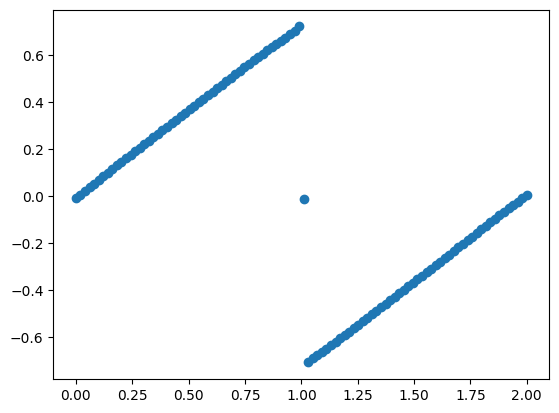

In [131]:

x = np.linspace(0.0, 2.0, 100)                                  
t = np.linspace(1.0, 1.0, 1)                                        
t_grid, x_grid = np.meshgrid(t, x)                              
T = t_grid.flatten()[:, None]                                   
X = x_grid.flatten()[:, None]                                   
x_test = np.hstack((T, X))                                      
x_test = torch.tensor(x_test, requires_grad=True, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))
res = to_numpy(model.res_pde(x_test))
d   = to_numpy(model.lambda_pde(x_test))

#loss = model.loss_pde(x_test)                                 

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.show()

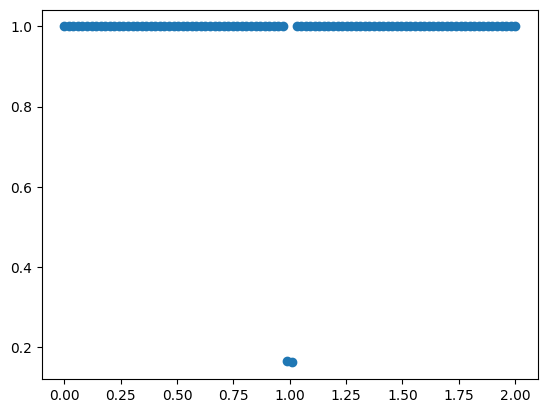

In [78]:
plt.scatter(x[:],1/d[:,0])

plt.show()